## 即時預測台北捷運各站未來1小時進出站人數
***

本專案利用過去一小時車站進出站人數資料、日期型態、時段、車站類型等特徵，建立一個可即時推估下一小時車站進出站人數之模型，期望可精進現有捷運場站交通管理策略，並提供台北捷運公司參考。

### 本專案研究範圍：
* 台北捷運系統所有營運車站 (共 108 個車站，不包含環狀線)。
* 資料來源：臺北捷運各站分時進出量統計 (Source: https://data.taipei/dataset/detail?id=63f31c7e-7fc3-418b-bd82-b95158755b4d)
* 資料期間：2017/01 至 2022/01。
* 分析時段：每日 6 時至隔日 0 時。


### 本專案建立之模型應用了以下三個機器學習模型：
* __AutoEncoder:__ 我們將訓練一個 AutoEncoder Neural Network，幫助我們將時間序列資料降維。
* __K-Means:__ 透過各車站單日時間序列資料進行分群。
* __XGBoost:__ 建立 XGBoost Regression Model 估計未來1小時捷運場站進出站人數。

## 目錄
***
### [1. 導入所需套件](#1)

### [2. 下載資料至本地端](#2)

### [3. 探索性資料分析](#3)

### [4. 特徵工程](#4)

### [5. 建立預測即時進出站人流模型](#5)

### [6. 模型績效評估](#6)

<a id="1"></a>
## 1. 導入所需套件

In [1]:
# 資料處理相關套件
import pandas as pd
import numpy as np

# 爬蟲相關套件
import os
import requests

# 機器學習相關套件
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_percentage_error as MAPE

# 繪圖相關套件
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as font

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

<a id="2"></a>
## 2. 下載資料至本地端

In [2]:
# 下載臺北捷運每日分時各站OD流量統計資料 -- 每日分時資料下載路徑
r = requests.get("https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=eb481f58-1238-4cff-8caa-fa7bb20cb4f4")
with open("source.csv", "wb") as f:
    f.write(r.content)
    f.close()
    
# 利用source.csv提供的路徑下載資料~~
data_source = pd.read_csv("source.csv", encoding="utf_8_sig", dtype={"年月": "string"})
if os.path.isdir("opendata/"):
    pass
else:
    os.makedirs("opendata/")

for i in range(data_source.shape[0]):
    r = requests.get(data_source["資料路徑"].iloc[i])
    yyyymm = data_source["年月"].iloc[i]
    filename = os.path.join("opendata/", f"{yyyymm}.csv")
    with open(filename, "wb") as f:
        f.write(r.content)
        f.close()

<a id="3"></a>
## 3. 探索性資料分析
***
* __[定義資料處理和繪圖所需函數](#3.1)__
* __[進出站人流尖峰趨勢](#3.2)__
* __[COVID-19對台北捷運運量影響](#3.3)__

<a id="3.1"></a>
### 定義資料處理和繪圖所需函數

In [3]:
# chinese_font = font(fname="C:/Hao/特殊字體/SourceHanSansTW/SourceHanSansTW-Normal.otf")   # plt顯示中文
chinese_font = font(fname="D:/Users/63984/SourceHanSansTW/SourceHanSansTW-Normal.otf")   # plt顯示中文(公司電腦)

def filt(rawdata):
    Circular_Line = {"新北產業園區", "幸福", "新埔民生", "Y板橋", "板新", "中原", "橋和", "中和", "景平", "秀朗橋", "十四張"}
    filtedData = rawdata.loc[(~rawdata["進站"].isin(Circular_Line)) & (~rawdata["出站"].isin(Circular_Line))]
    stationList = list(filtedData.groupby(["進站"]).groups.keys())
    return filtedData, stationList

def calculateIN_daily(df, month, stationName):
    if month == "12":
        dateList = list(df.groupby(["日期"]).groups.keys())[:-1]
    else:
        dateList = list(df.groupby(["日期"]).groups.keys())
    hourList = [0] + [hour for hour in range(6, 24)]
    
    inbound = df.groupby(["日期", "進站", "時段"])
    inbound_table = np.zeros((len(dateList), len(hourList)))
    for i, date in enumerate(dateList):
        for j, hour in enumerate(hourList):
            try:
                inbound_table[i][j] += inbound.get_group((date, stationName, hour))["人次"].sum()
            except KeyError:
                pass
    return inbound_table

def calculateOUT_daily(df, month, stationName):
    if month == "12":
        dateList = list(df.groupby(["日期"]).groups.keys())[:-1]
    else:
        dateList = list(df.groupby(["日期"]).groups.keys())
    hourList = [0] + [hour for hour in range(6, 24)]
    
    outbound = df.groupby(["日期", "出站", "時段"])
    outbound_table = np.zeros((len(dateList), len(hourList)))
    for i, date in enumerate(dateList):
        for j, hour in enumerate(hourList):
            try:
                outbound_table[i][j] += outbound.get_group((date, stationName, hour))["人次"].sum()
            except KeyError:
                pass
    return outbound_table

def calculateIN_monthly(df, month, stationList):
    if month == "12":
        dateList = list(df.groupby(["日期"]).groups.keys())[:-1]
    else:
        dateList = list(df.groupby(["日期"]).groups.keys())
    hourList = [0] + [hour for hour in range(6, 24)]
    
    inbound = df.groupby(["日期", "進站", "時段"])
    inbound_table = np.zeros((len(stationList), len(hourList)))
    for i, station in enumerate(stationList):
        for date in dateList:
            for j, hour in enumerate(hourList):
                try:
                    inbound_table[i][j] += inbound.get_group((date, station, hour))["人次"].sum()
                except KeyError:
                    pass
    return inbound_table

def calculateOUT_monthly(df, month, stationList):
    if month == "12":
        dateList = list(df.groupby(["日期"]).groups.keys())[:-1]
    else:
        dateList = list(df.groupby(["日期"]).groups.keys())
    hourList = [0] + [hour for hour in range(6, 24)]
    
    outbound = df.groupby(["日期", "出站", "時段"])
    outbound_table = np.zeros((len(stationList), len(hourList)))
    for i, station in enumerate(stationList):
        for date in dateList:
            for j, hour in enumerate(hourList):
                try:
                    outbound_table[i][j] += outbound.get_group((date, station, hour))["人次"].sum()
                except KeyError:
                    pass
    return outbound_table

def calculateIN_each_station_each_hour(df, month, stationList):
    if month == "12":
        dateList = list(df.groupby(["日期"]).groups.keys())[:-1]
    else:
        dateList = list(df.groupby(["日期"]).groups.keys())
    hourList = [0] + [hour for hour in range(6, 24)]
    
    inbound = df.groupby(["日期", "進站", "時段"])
    inbound_tables = []
    for date in dateList:
        inbound_table = np.zeros((len(stationList), len(hourList)))
        for i, station in enumerate(stationList):
            for j, hour in enumerate(hourList):
                try:
                    inbound_table[i][j] += inbound.get_group((date, station, hour))["人次"].sum()
                except KeyError:
                    pass
        inbound_tables.append(inbound_table)
    return np.concatenate(inbound_tables)

def calculateOUT_each_station_each_hour(df, month, stationList):
    if month == "12":
        dateList = list(df.groupby(["日期"]).groups.keys())[:-1]
    else:
        dateList = list(df.groupby(["日期"]).groups.keys())
    hourList = [0] + [hour for hour in range(6, 24)]
    
    outbound = df.groupby(["日期", "出站", "時段"])
    outbound_tables = []
    for date in dateList:
        outbound_table = np.zeros((len(stationList), len(hourList)))
        for i, station in enumerate(stationList):
            for j, hour in enumerate(hourList):
                try:
                    outbound_table[i][j] += outbound.get_group((date, station, hour))["人次"].sum()
                except KeyError:
                    pass
        outbound_tables.append(outbound_table)
    return np.concatenate(outbound_tables)

def plot_stream(stationNameList, year, month, date=None, colorList=None, figsize=(16,8)):
    df = pd.read_csv(f"opendata/{year}{month}.csv", encoding="utf_8_sig", parse_dates=["日期"])
    df, _ = filt(df)
    if date != None:
        df = df.loc[df["日期"] == pd.Timestamp(f"{year}-{month}-{date}")]
    else:
        for i, stationName in enumerate(stationNameList):
            IN = calculateIN_daily(df, month, stationName).flatten()
            OUT = calculateOUT_daily(df, month, stationName).flatten()
            fig = plt.figure(figsize=figsize)
            loc = str(len(stationNameList)) + "1" + f"{i+1}"
            plt.subplot(int(loc))
            if date != None:
                plt.title(f"{stationName}站{year}年{month}月{date}日分時進出站人數", fontproperties=chinese_font, fontsize=16)
                if colorList != None:
                    plt.plot(IN, color=colorList[i], linestyle="-", label="進站")
                    plt.plot(OUT, color=colorList[i], linestyle="--", label="出站")
                else:
                    plt.plot(IN, linestyle="-", label="進站")
                    plt.plot(OUT, linestyle="--", label="出站")
                plt.xticks([i for i in range(19)], [0]+[i for i in range(6,24)])
                plt.xlabel("時段", fontproperties=chinese_font, fontsize=12)
                plt.ylabel("人數", fontproperties=chinese_font, fontsize=12)
                plt.legend()       
                plt.tight_layout()
            else:
                plt.title(f"{stationName}站{year}年{month}月每日分時進出站人數", fontproperties=chinese_font, fontsize=16)
                plt.plot(IN, color=colorList[i], linestyle="-", label="進站")
                plt.plot(OUT, color=colorList[i], linestyle="--", label="出站")
                plt.xticks([i*19 for i in range(30)], ["%s" % i for i in range(1, 31)])
                plt.xlabel("日期", fontproperties=chinese_font, fontsize=12)
                plt.ylabel("人數", fontproperties=chinese_font, fontsize=12)
                plt.legend()       
                plt.tight_layout()

def plot_inbound_pattern(stationNameList, year, month, date=None, colorList=None, figsize=(16,8)):
    df = pd.read_csv(f"opendata/{year}{month}.csv", encoding="utf_8_sig", parse_dates=["日期"])
    df, _ = filt(df)
            
    fig = plt.figure(figsize=figsize)
    if date != None:
        df = df.loc[df["日期"] == pd.Timestamp(f"{year}-{month}-{date}")]
        plt.title(f"各站{year}年{month}月{date}日分時進站人流趨勢", fontproperties=chinese_font, fontsize=16)
        for i, stationName in enumerate(stationNameList):
            IN = calculateIN_daily(df, month, stationName)
            IN = normalize(IN).flatten()
            if colorList != None:
                plt.plot(IN, color=colorList[i], linestyle="-", label=stationName)
            else:
                plt.plot(IN, linestyle="-", label=stationName)
        plt.xticks([i for i in range(19)], [0]+[i for i in range(6,24)])
        plt.xlabel("時段", fontproperties=chinese_font, fontsize=12)
        plt.ylabel("人數(L2 Normalize)", fontproperties=chinese_font, fontsize=12)
        plt.legend()    
    else:
        plt.title(f"各站{year}年{month}月每日分時進站人流趨勢", fontproperties=chinese_font, fontsize=16)
        for i, stationName in enumerate(stationNameList):
            IN = calculateIN_daily(df, month, stationName)
            IN = normalize(IN).flatten()
            if colorList != None:
                plt.plot(IN, color=colorList[i], linestyle="-", label=stationName)
            else:
                plt.plot(IN, linestyle="-", label=stationName)
        plt.xticks([i*19 for i in range(30)], ["%s" % i for i in range(1, 31)])
        plt.xlabel("日期", fontproperties=chinese_font, fontsize=12)
        plt.ylabel("人數(L2 Normalize)", fontproperties=chinese_font, fontsize=12)
        plt.legend()
        
def plot_outbound_pattern(stationNameList, year, month, date=None, colorList=None, figsize=(16,8)):
    df = pd.read_csv(f"opendata/{year}{month}.csv", encoding="utf_8_sig", parse_dates=["日期"])
    df, _ = filt(df)
            
    fig = plt.figure(figsize=figsize)
    if date != None:
        df = df.loc[df["日期"] == pd.Timestamp(f"{year}-{month}-{date}")]
        plt.title(f"各站{year}年{month}月{date}日分時出站人流趨勢", fontproperties=chinese_font, fontsize=16)
        for i, stationName in enumerate(stationNameList):
            OUT = calculateOUT_daily(df, month, stationName)
            OUT = normalize(OUT).flatten()
            if colorList != None:
                plt.plot(OUT, color=colorList[i], linestyle="-", label=stationName)
            else:
                plt.plot(OUT, linestyle="-", label=stationName)
        plt.xticks([i for i in range(19)], [0]+[i for i in range(6,24)])
        plt.xlabel("時段", fontproperties=chinese_font, fontsize=12)
        plt.ylabel("人數(L2 Normalize)", fontproperties=chinese_font, fontsize=12)
        plt.legend()    
    else:
        plt.title(f"各站{year}年{month}月每日分時出站人流趨勢", fontproperties=chinese_font, fontsize=16)
        for i, stationName in enumerate(stationNameList):
            OUT = calculateOUT_daily(df, month, stationName)
            OUT = normalize(OUT).flatten()
            if colorList != None:
                plt.plot(OUT, color=colorList[i], linestyle="-", label=stationName)
            else:
                plt.plot(OUT, linestyle="-", label=stationName)
        plt.xticks([i*19 for i in range(30)], ["%s" % i for i in range(1, 31)])
        plt.xlabel("日期", fontproperties=chinese_font, fontsize=12)
        plt.ylabel("人數(L2 Normalize)", fontproperties=chinese_font, fontsize=12)
        plt.legend()

<a id="3.2"></a>
### 進出站人流尖峰趨勢

捷運車站的進出站人流尖峰時段，和車站周邊的土地使用分區有高度相關。在還沒有任何數據支持的情況下，我們還是可以透過主觀判定，把捷運站大致分成以下幾種類型 __(以下僅為推測，不一定正確！)__：

* __鄰近住宅區：__ 如迴龍、丹鳳、輔大、新莊、頭前庄。
* __鄰近商辦區：__ 如西湖 (內湖科技園區)、港墘 (內湖科技園區)、關渡 (士林北投科技園區)。
* __鄰近商圈：__ 如西門、中山、忠孝敦化、市政府。

位於不同土地使用分區的捷運站，進出站人流尖峰勢必不同，比方說鄰近住宅區的捷運站，可以預期上班尖峰時段進站人數多、下班尖峰時段出站人數多；而鄰近商辦區的捷運站，可以預期上班尖峰時段出站人數多、下班尖峰時段進站人數多；而鄰近商圈的捷運站，進站尖峰可能發生在假日或平日晚上。

本專案的目標是希望建立可即時預測下一小時的進出站人流的模型，我們期望將進出站人流尖峰趨勢相似的捷運車站分門別類，作為輸入模型的特徵，讓機器可以更準確預測。

以下以2019-06資料為例，我們從以上三種不同類型，各選取兩個捷運站繪製單月每日分時進出站人流趨勢。根據下圖，基本上各站進出站人流尖峰趨勢的實際情形，與我們一開始的猜想大致符合，不過中山站和西門站在平日早上尖峰時段出站人數有落差。

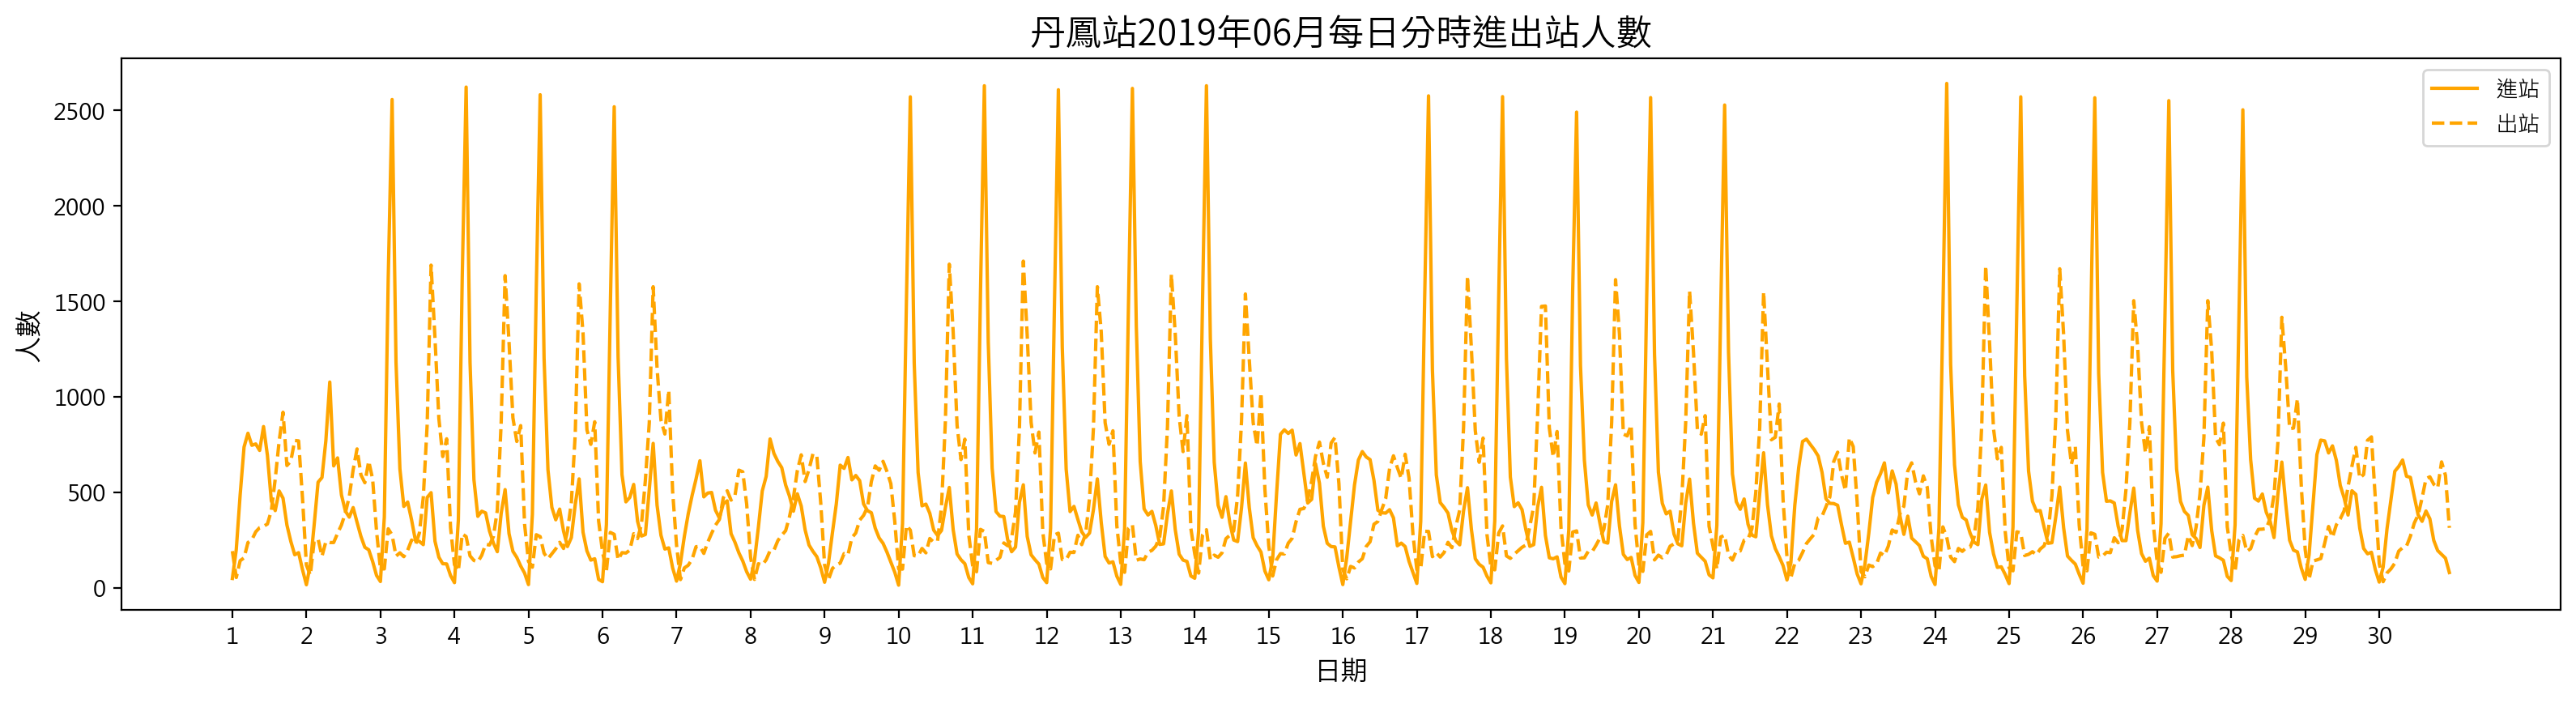

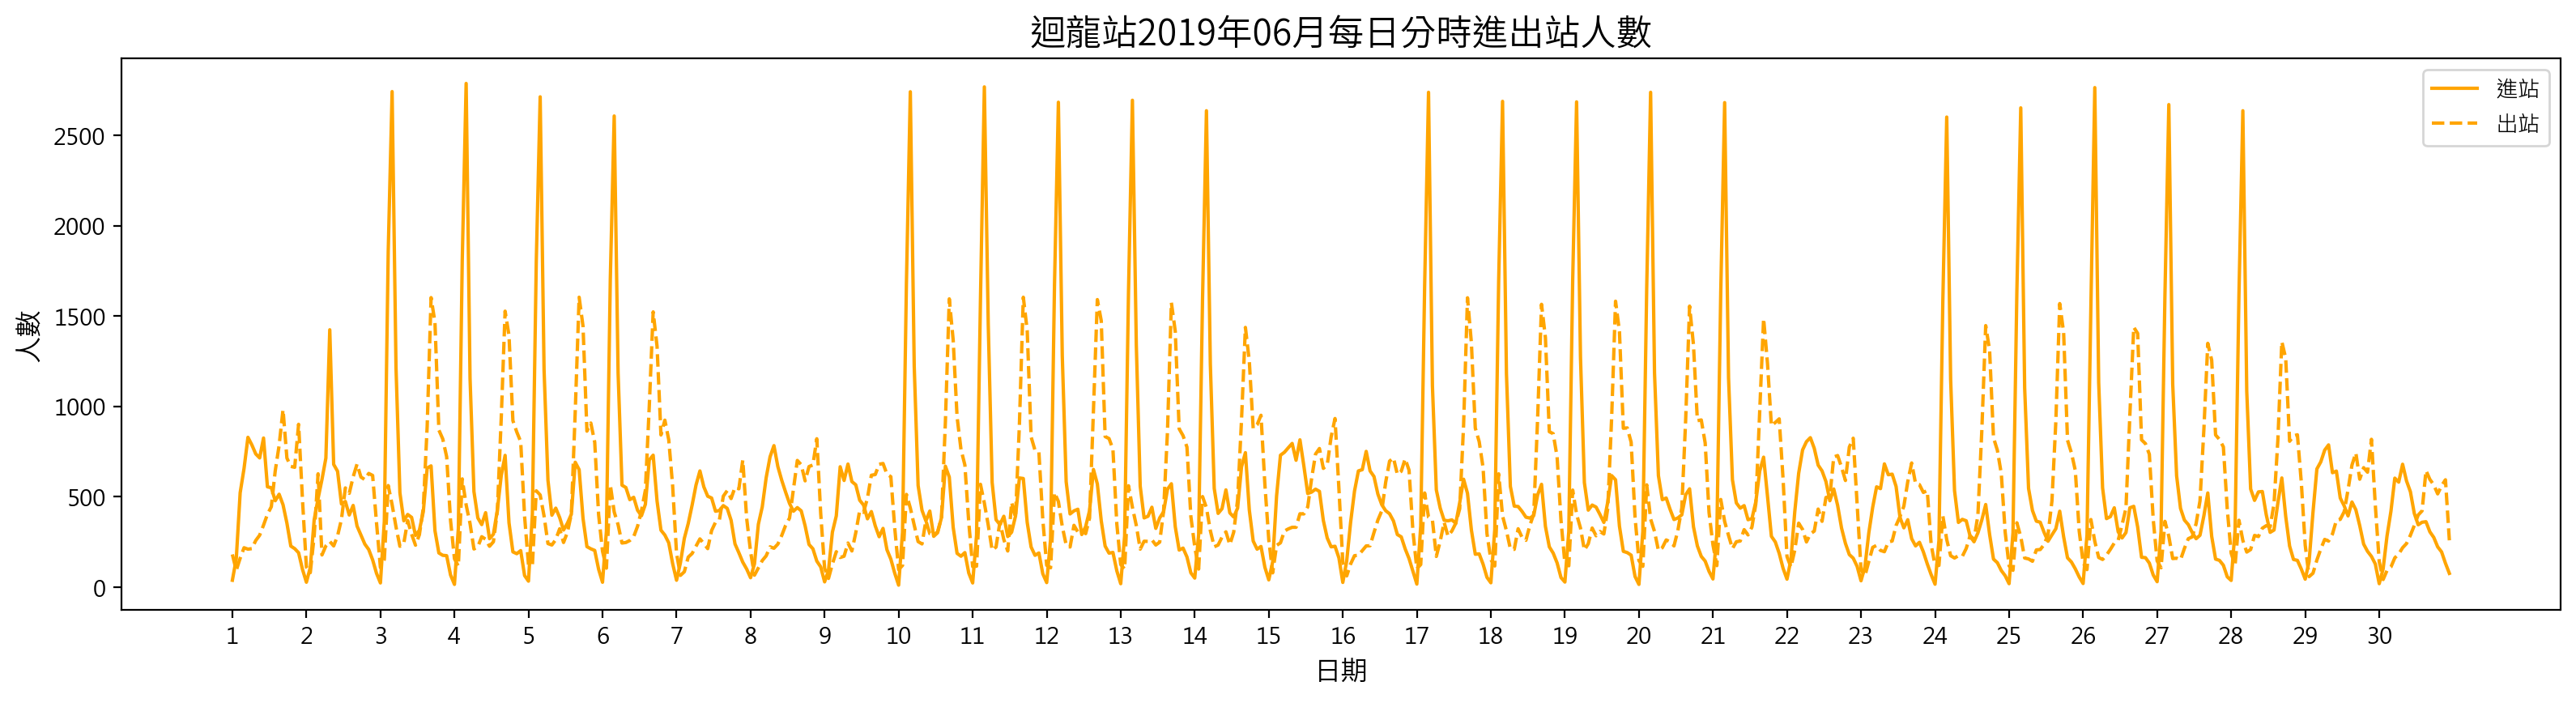

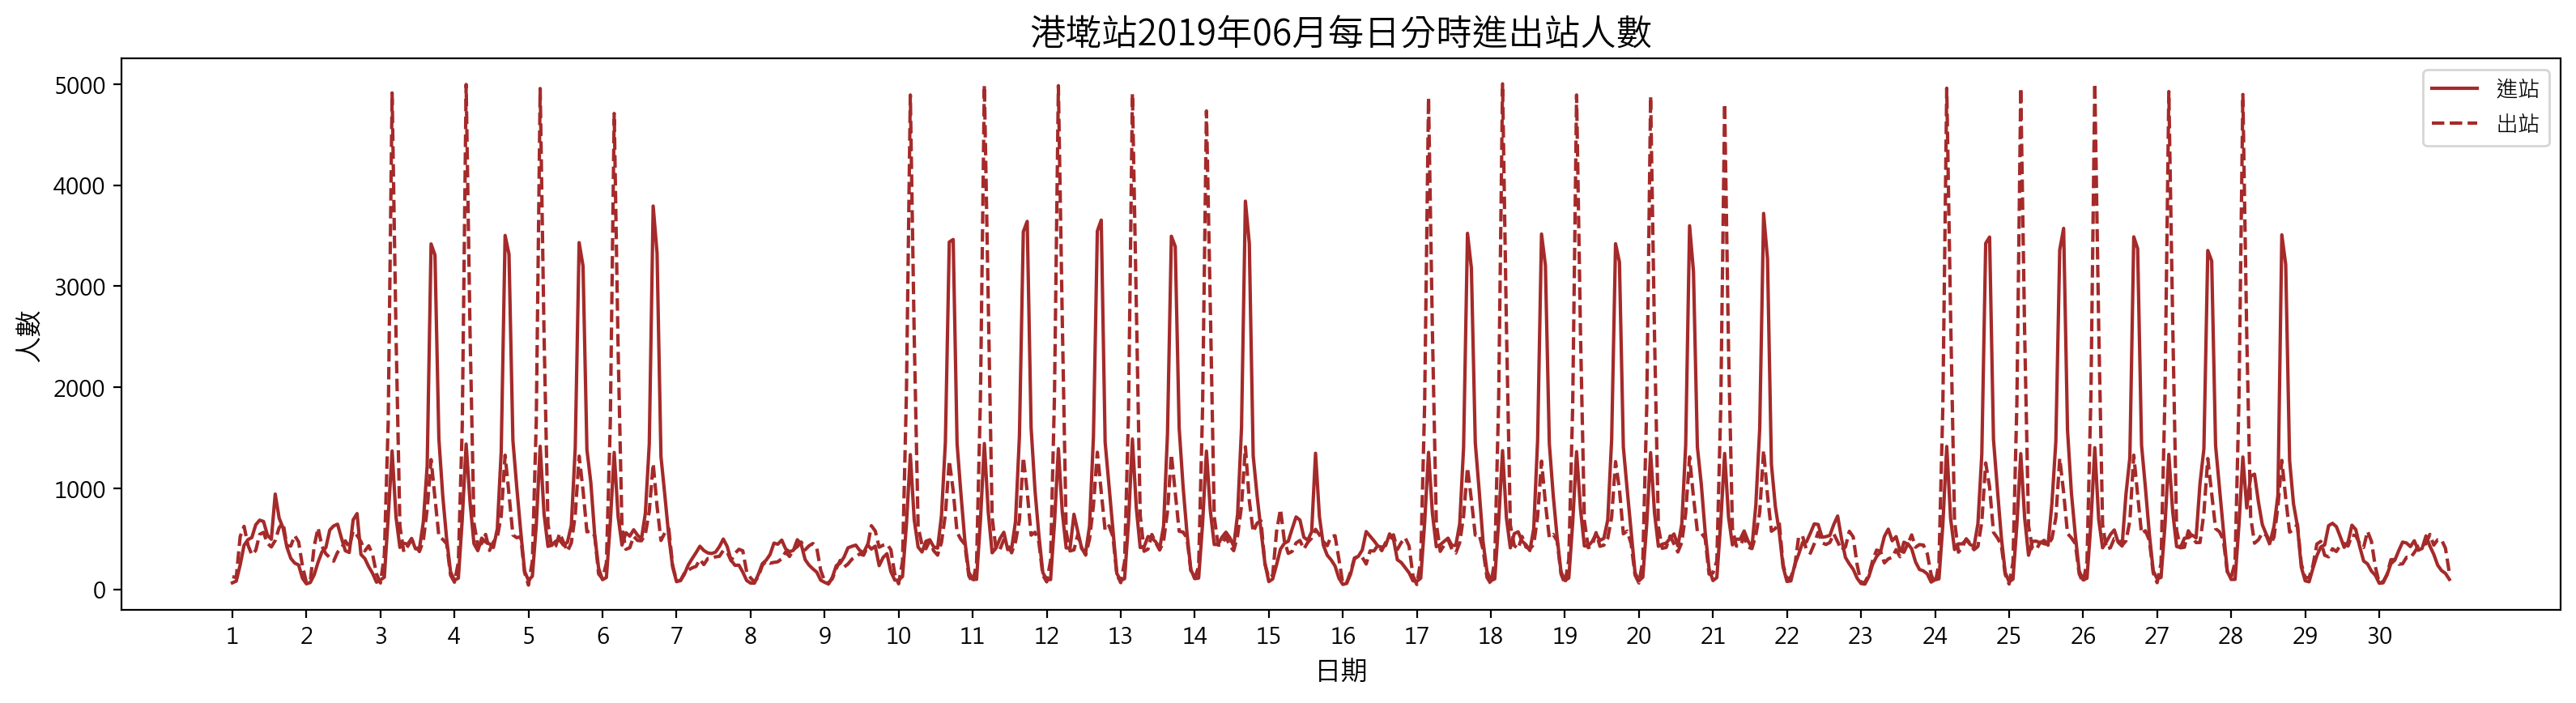

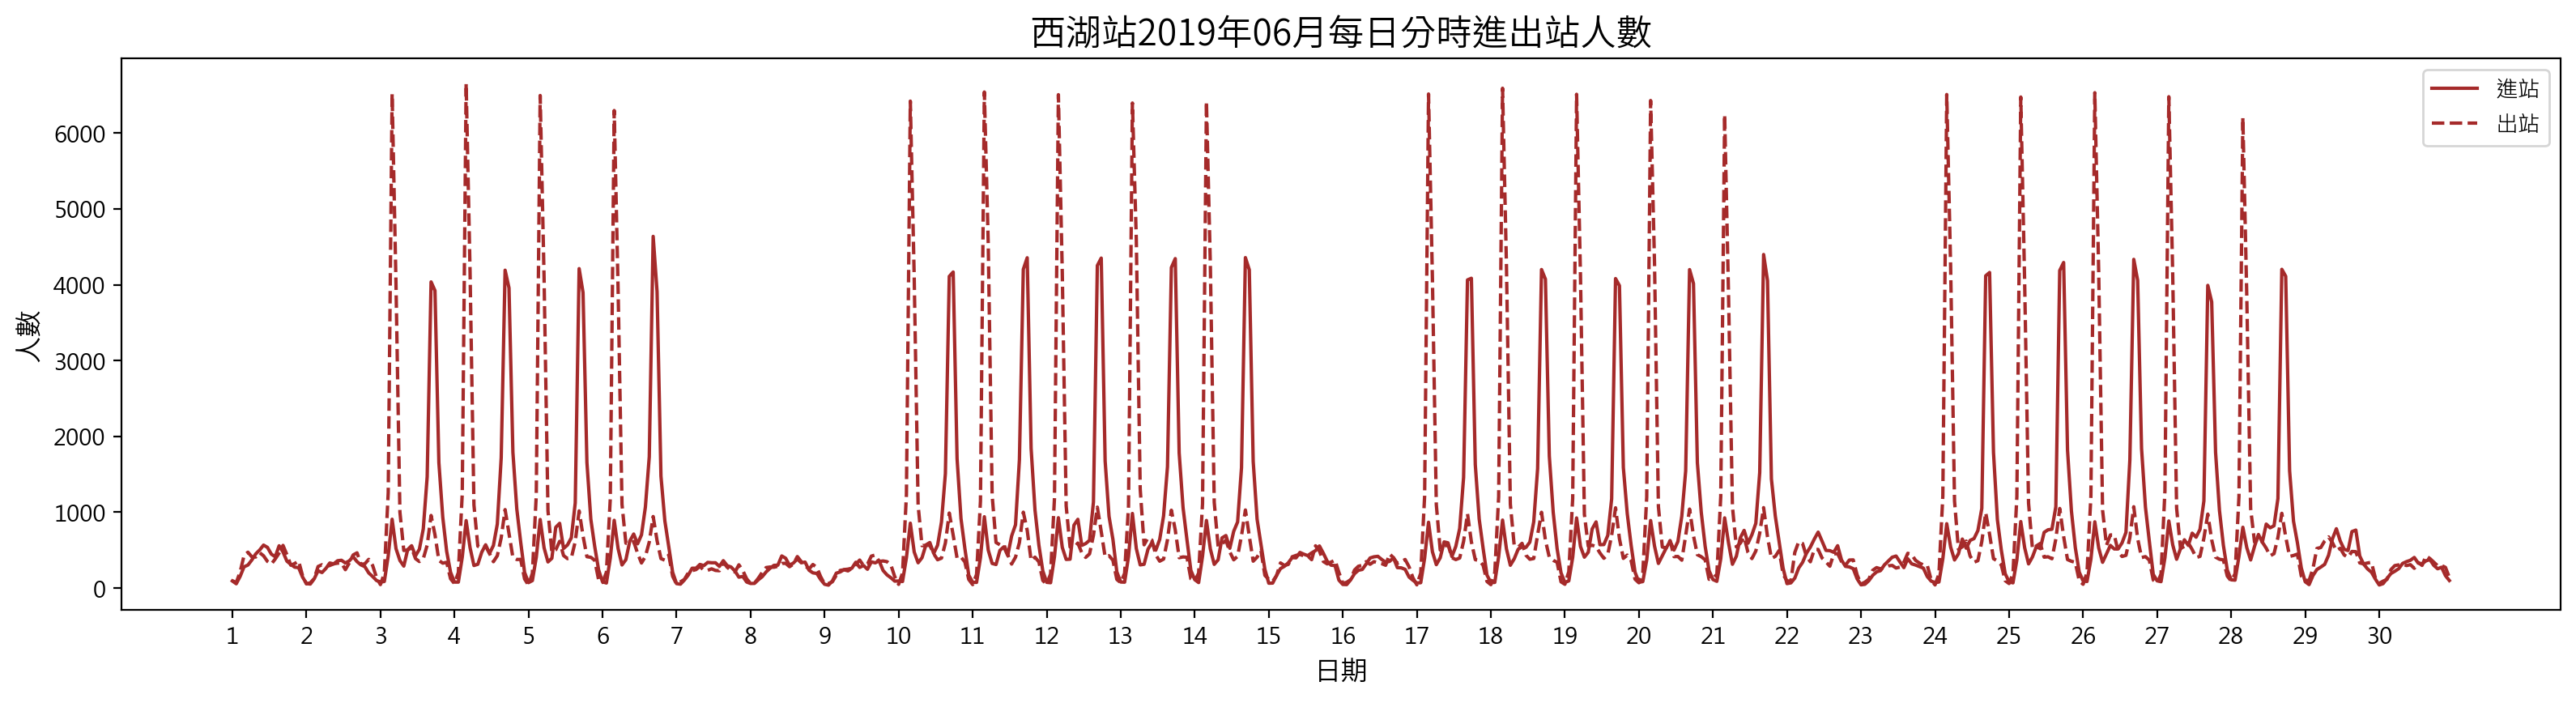

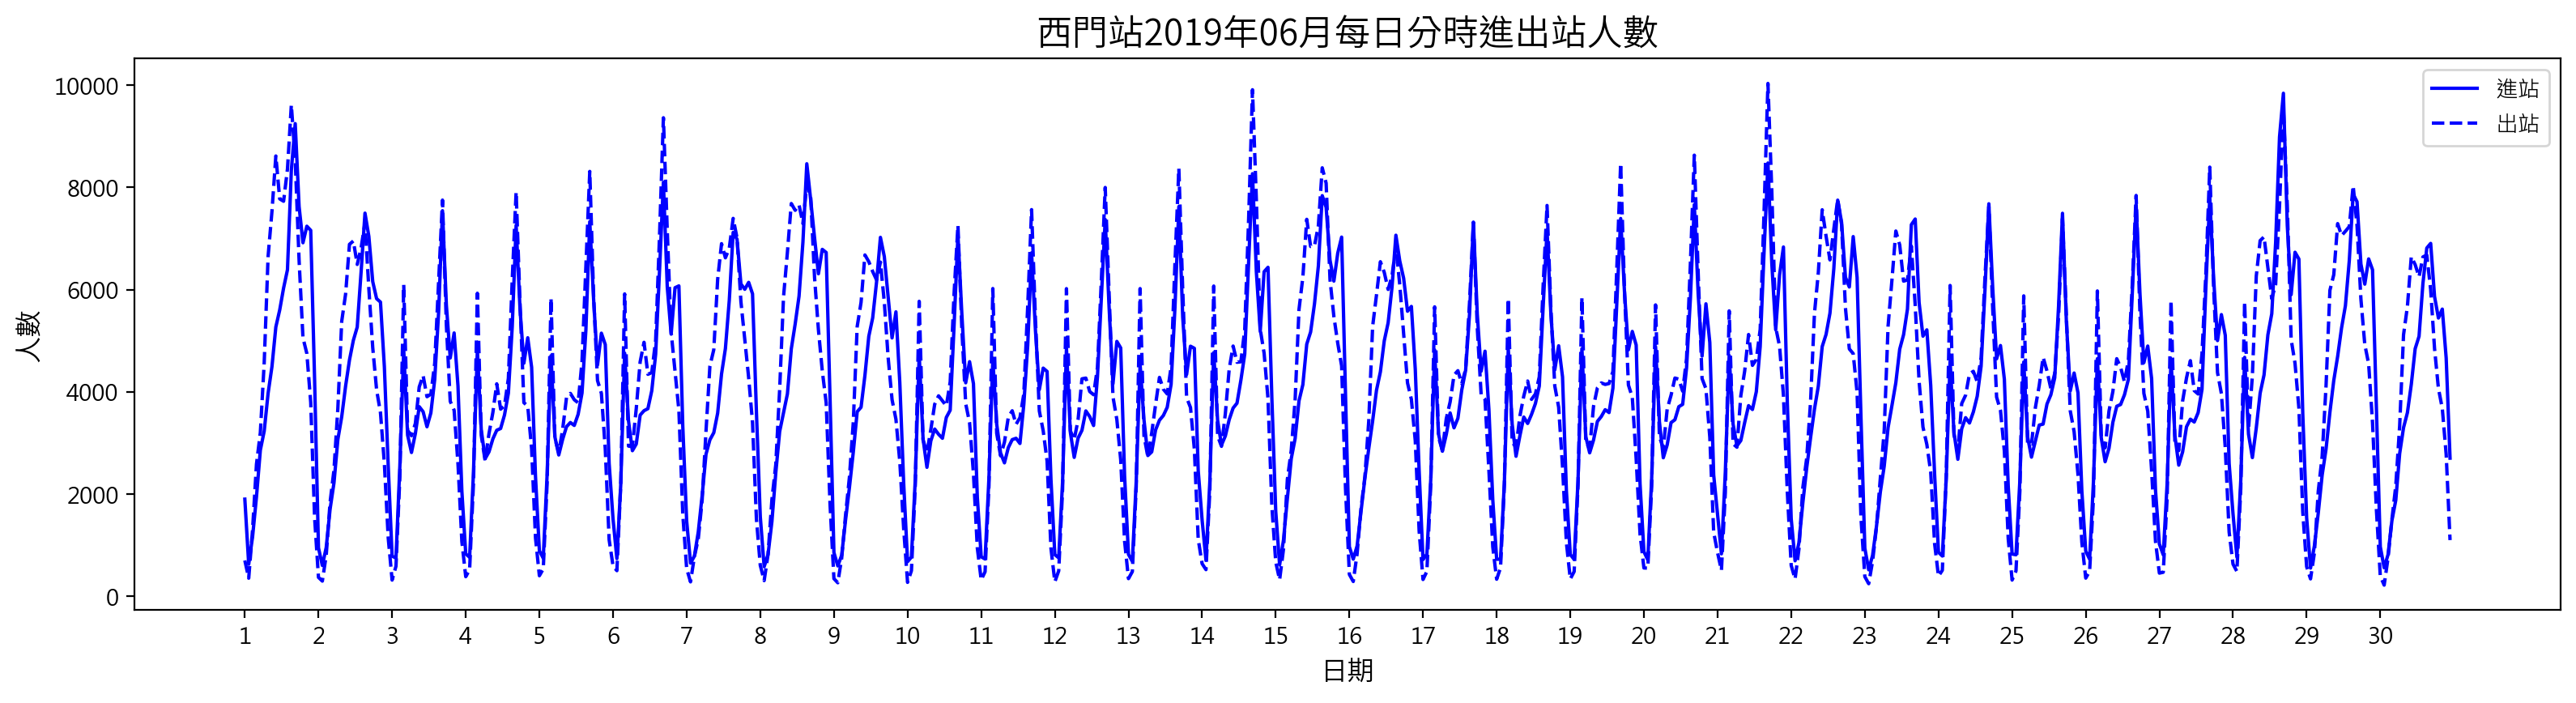

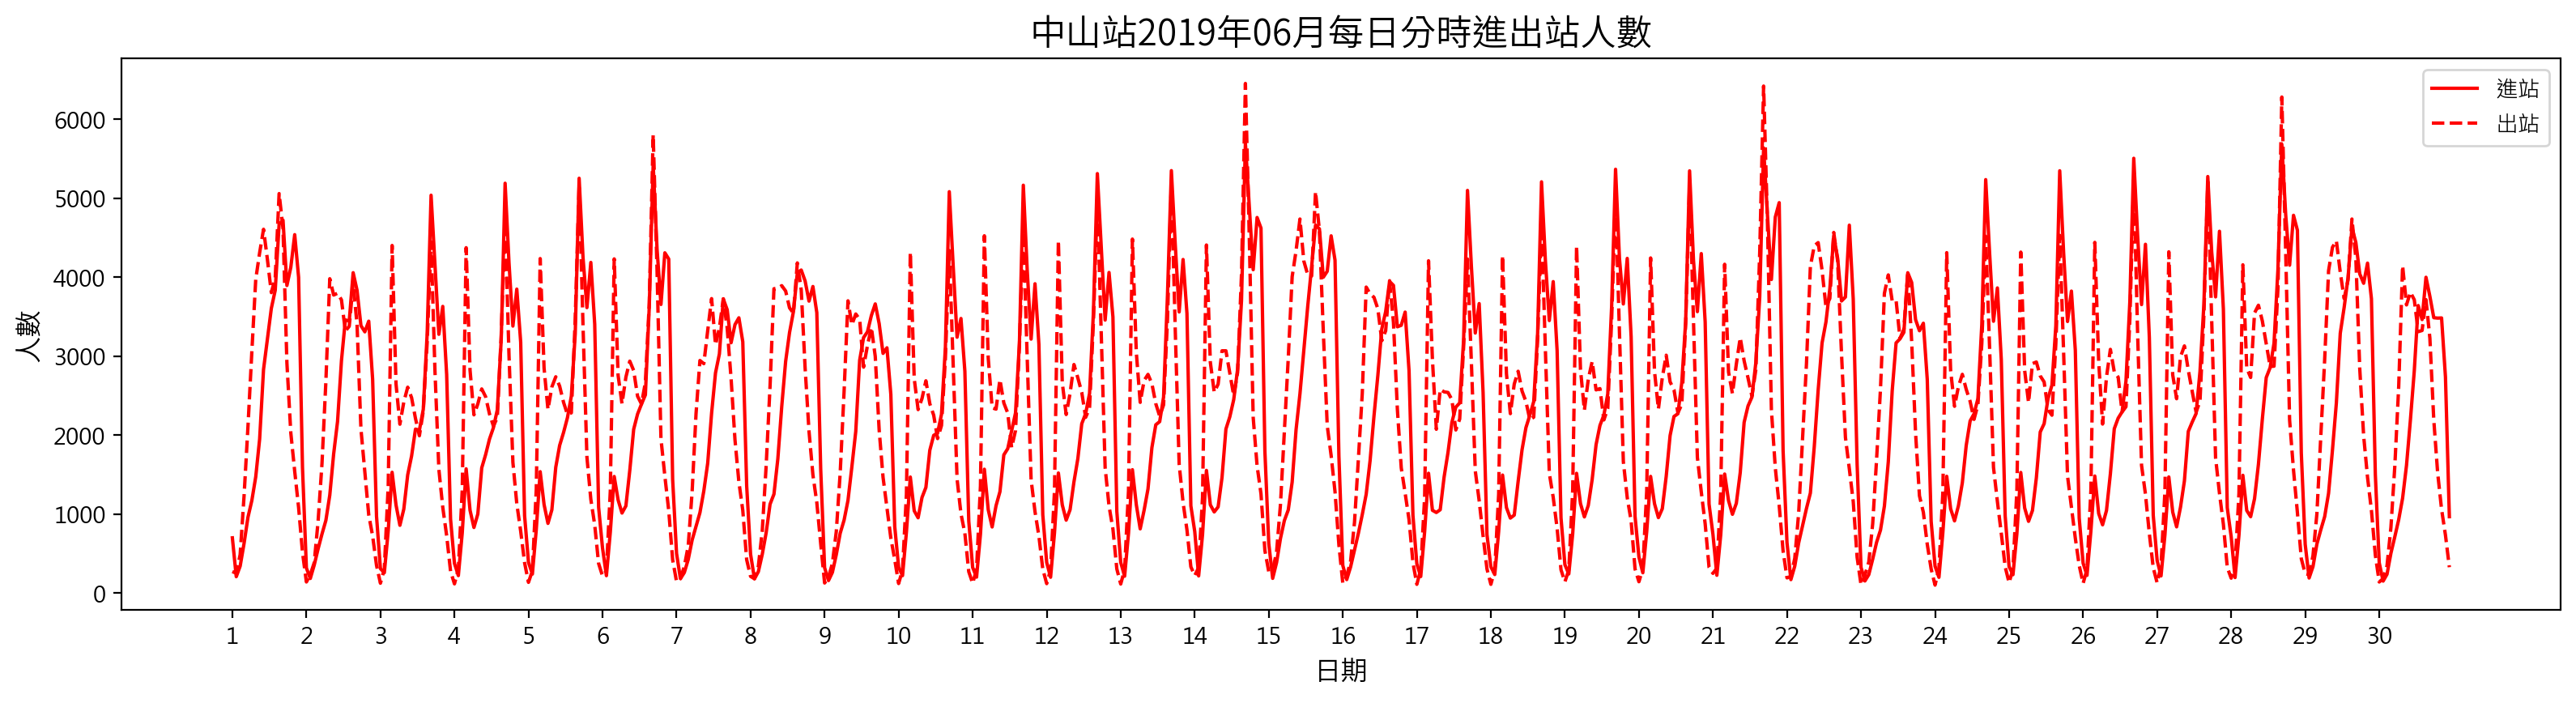

In [4]:
plot_stream(stationNameList=["丹鳳", "迴龍"], colorList=["orange", "orange"], year="2019", month="06")
plot_stream(stationNameList=["港墘", "西湖"], colorList=["brown", "brown"], year="2019", month="06")
plot_stream(stationNameList=["西門", "中山"], colorList=["blue", "red"], year="2019", month="06")

為了能更清楚呈現進出站人流趨勢，我們將進站和出站分開繪製，並且將進出站人數正規化 (normalize)，如下所示。而由下圖我們可以發現，如果用主觀判定的方式區分捷運車站，還是會存在一些瑕疵。比方說輔大站在18時有一波進站尖峰，然而丹鳳站跟迴龍站並沒有這樣的趨勢。

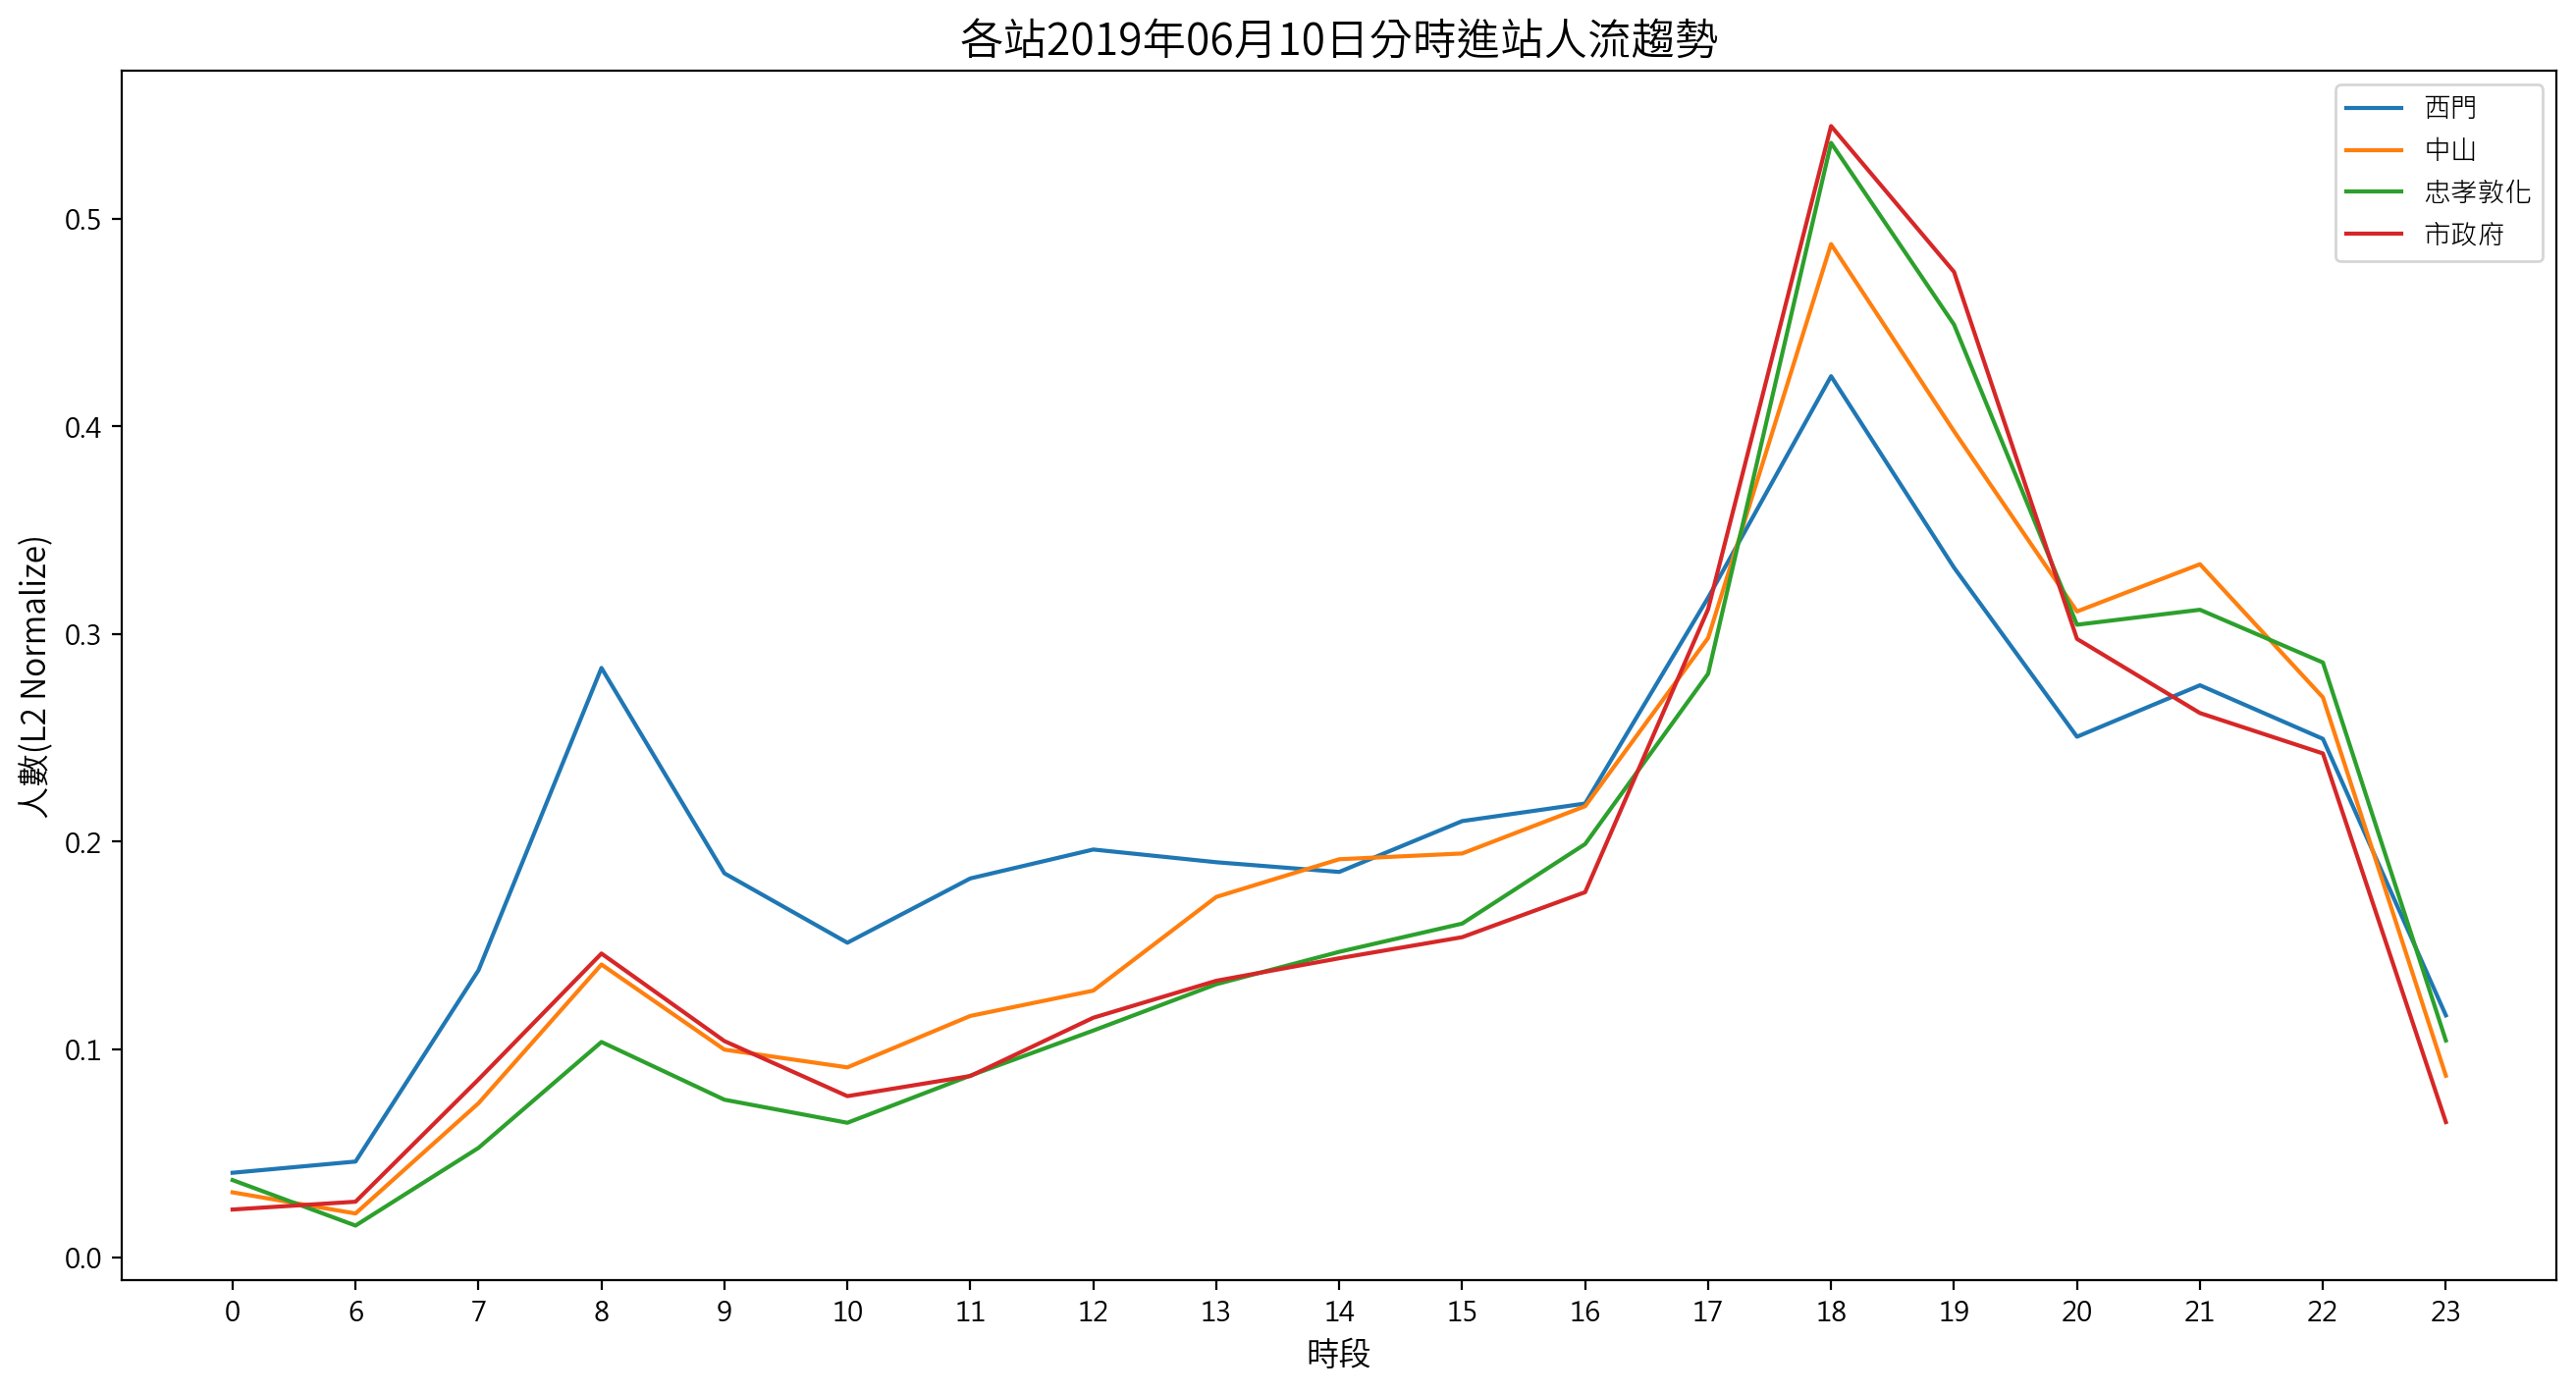

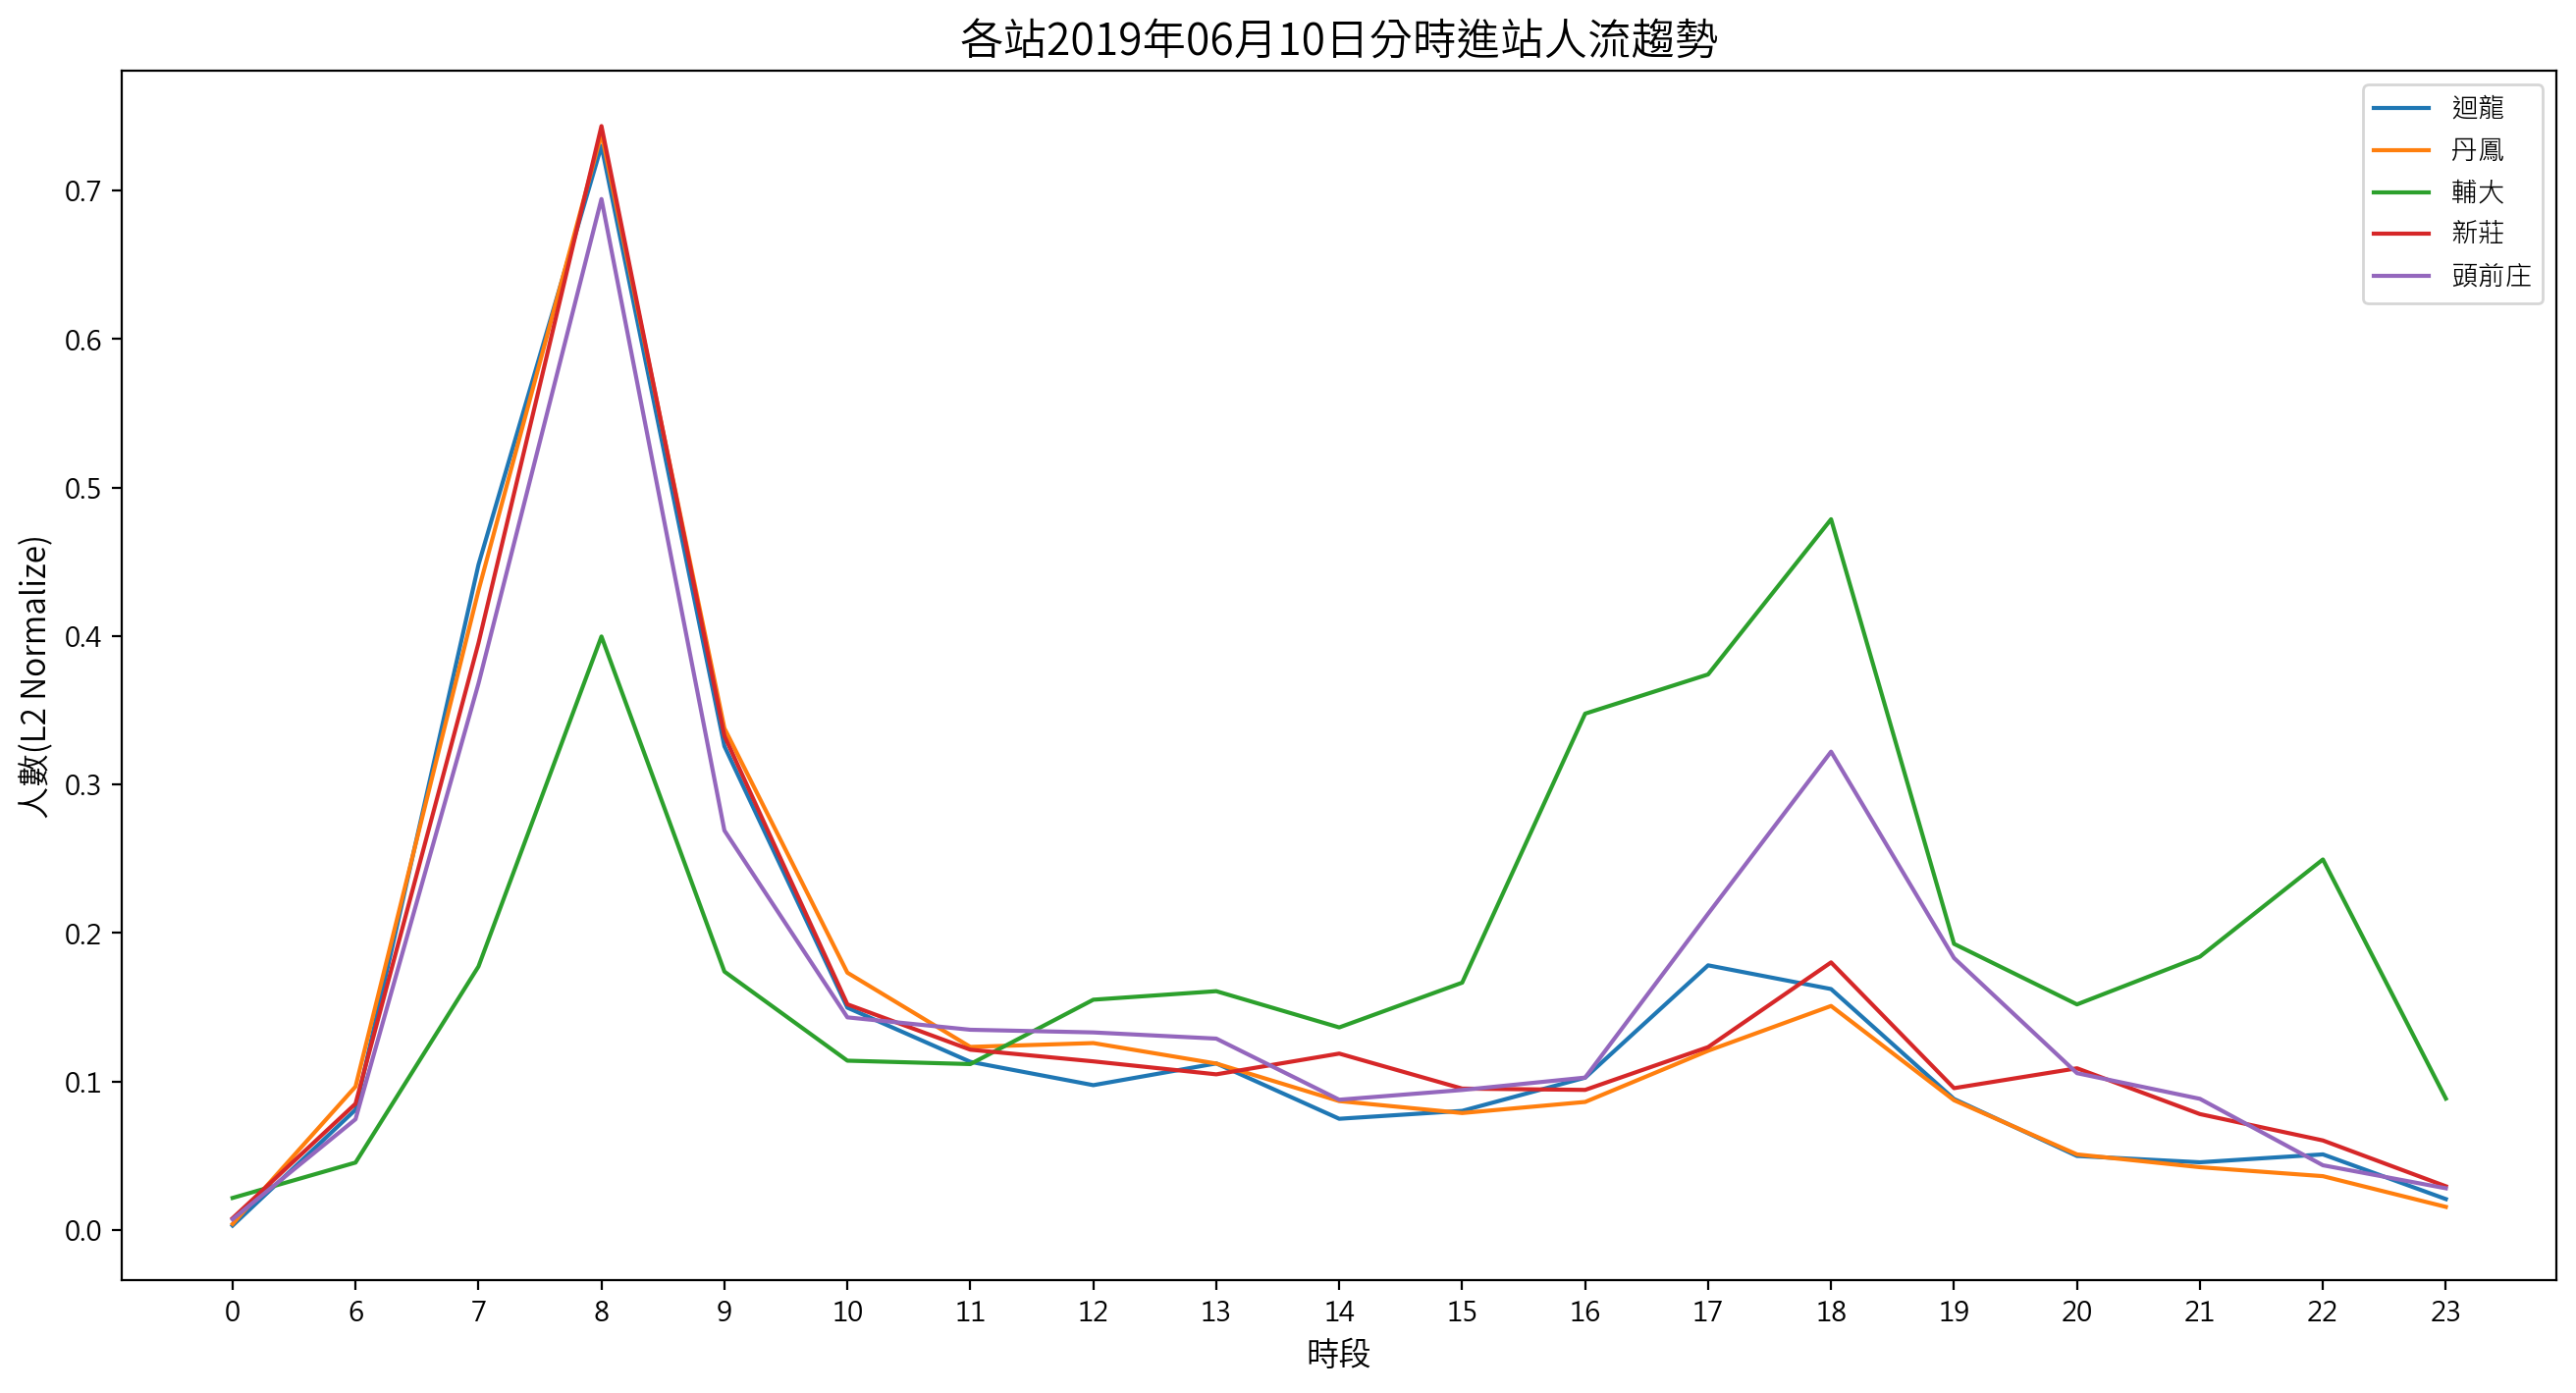

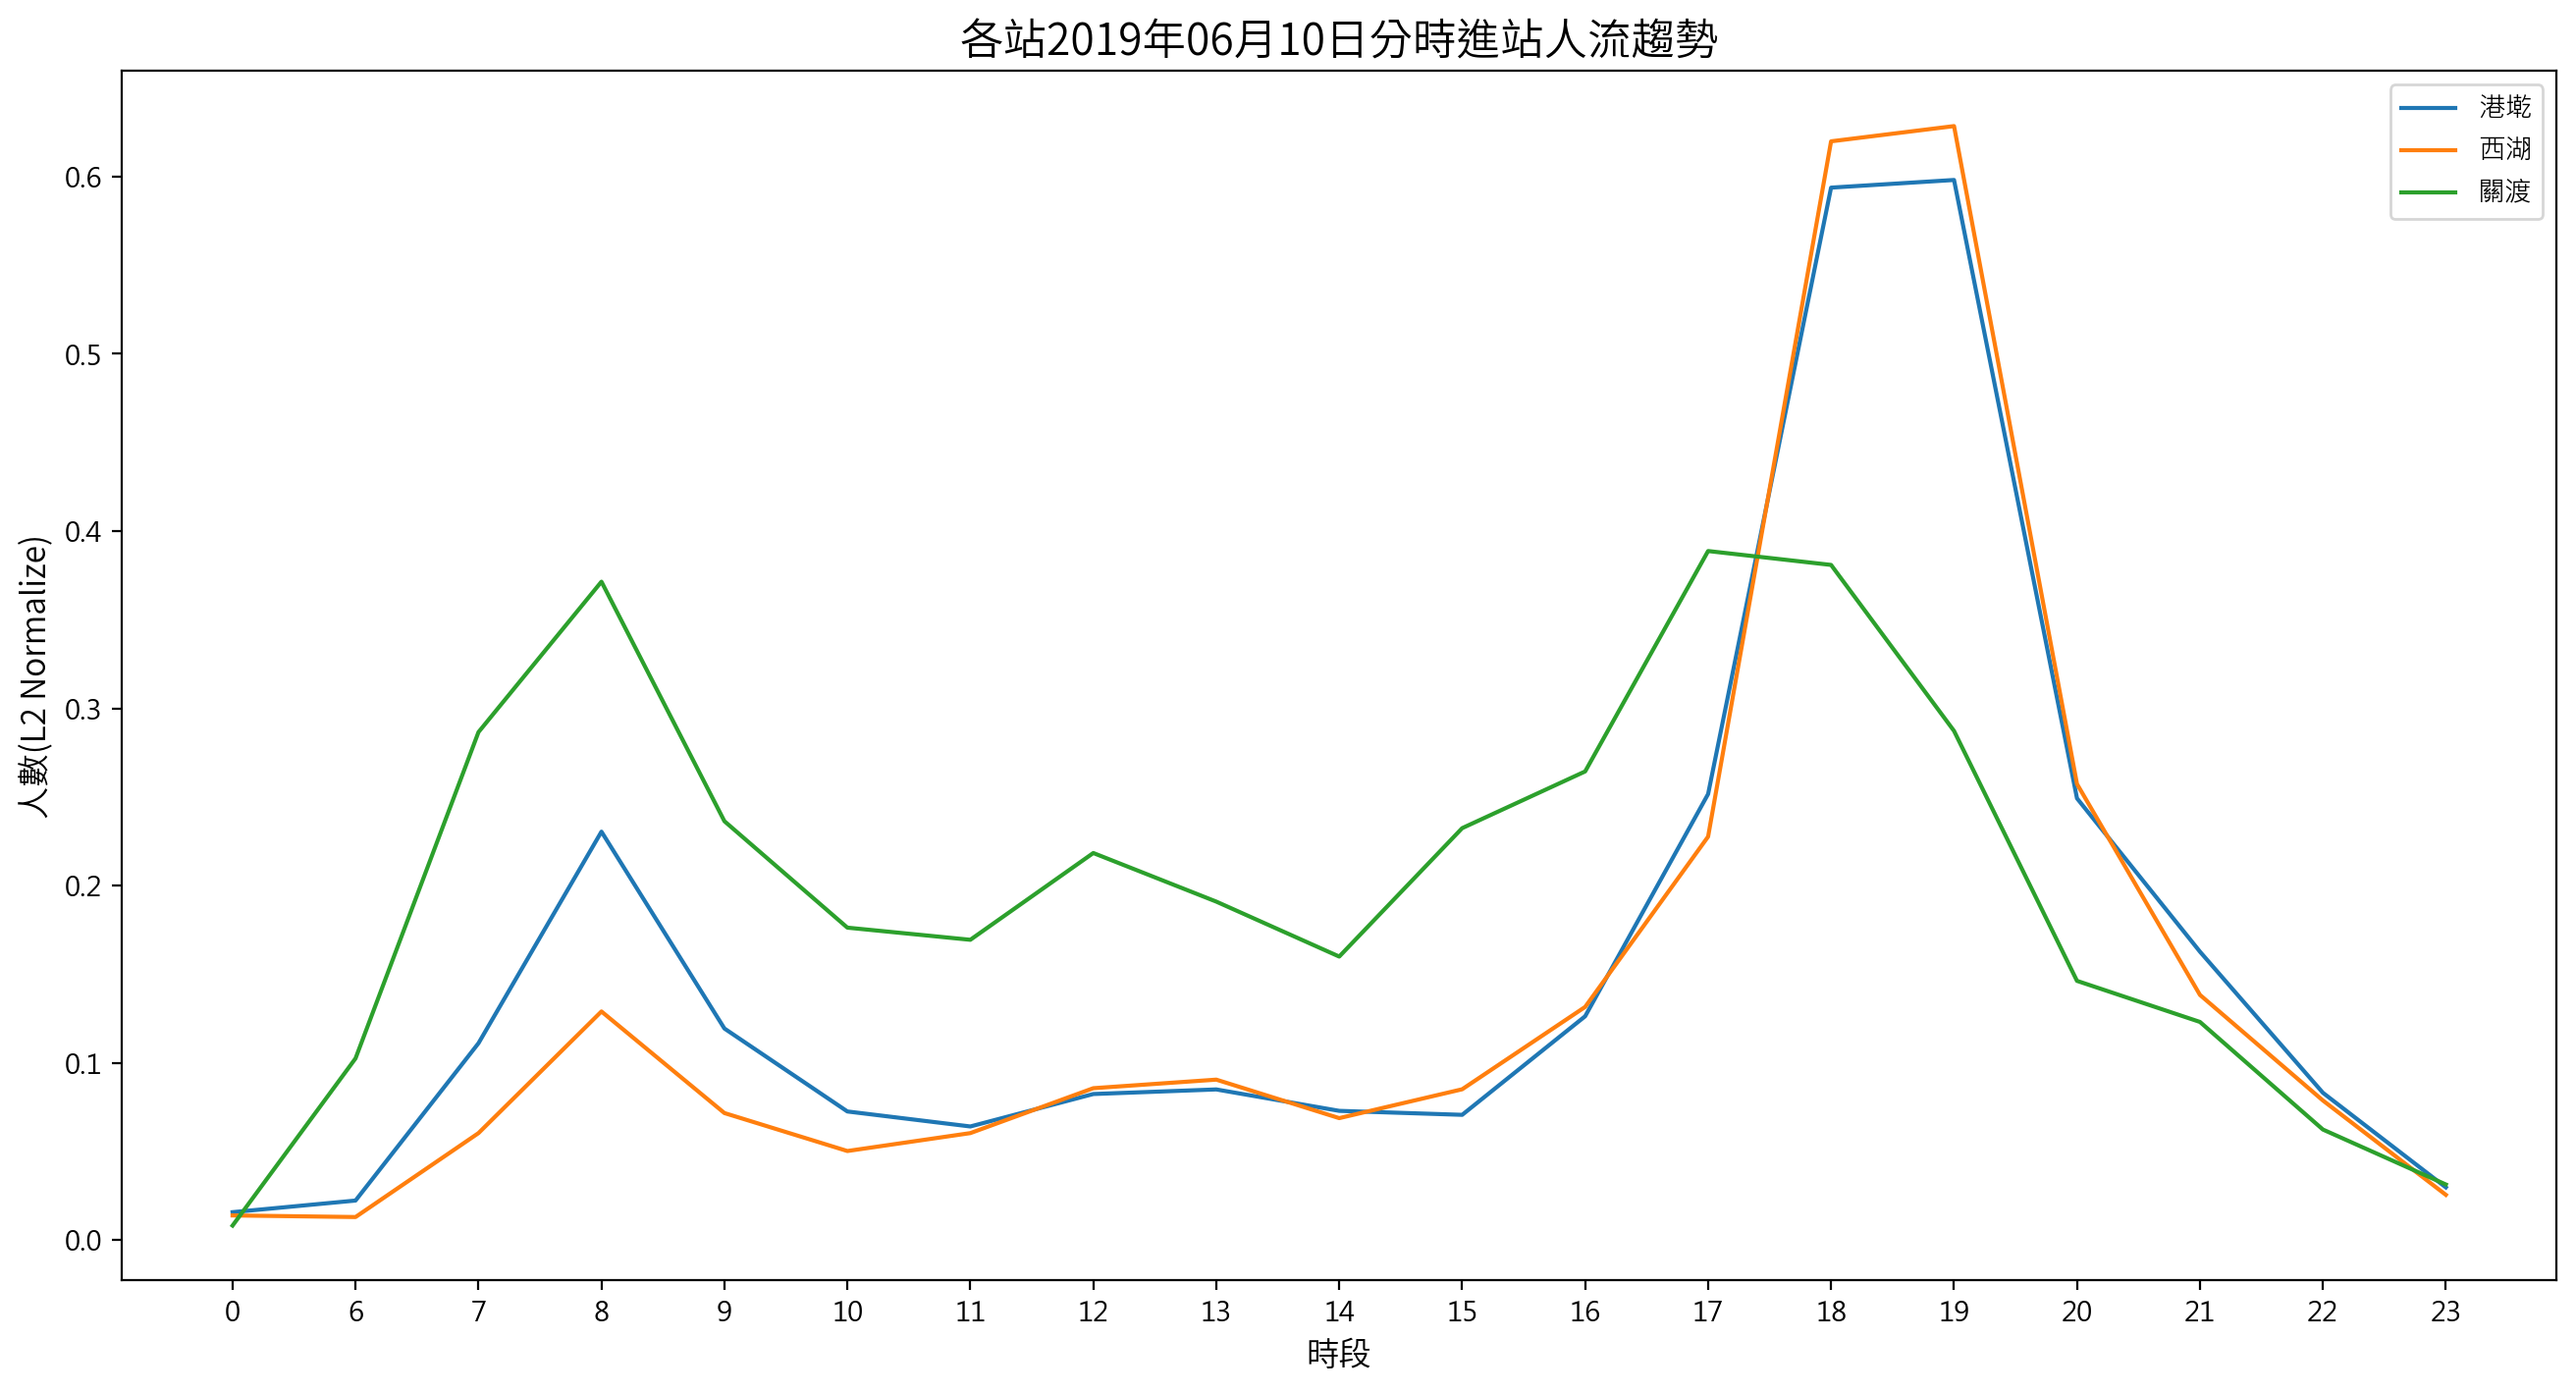

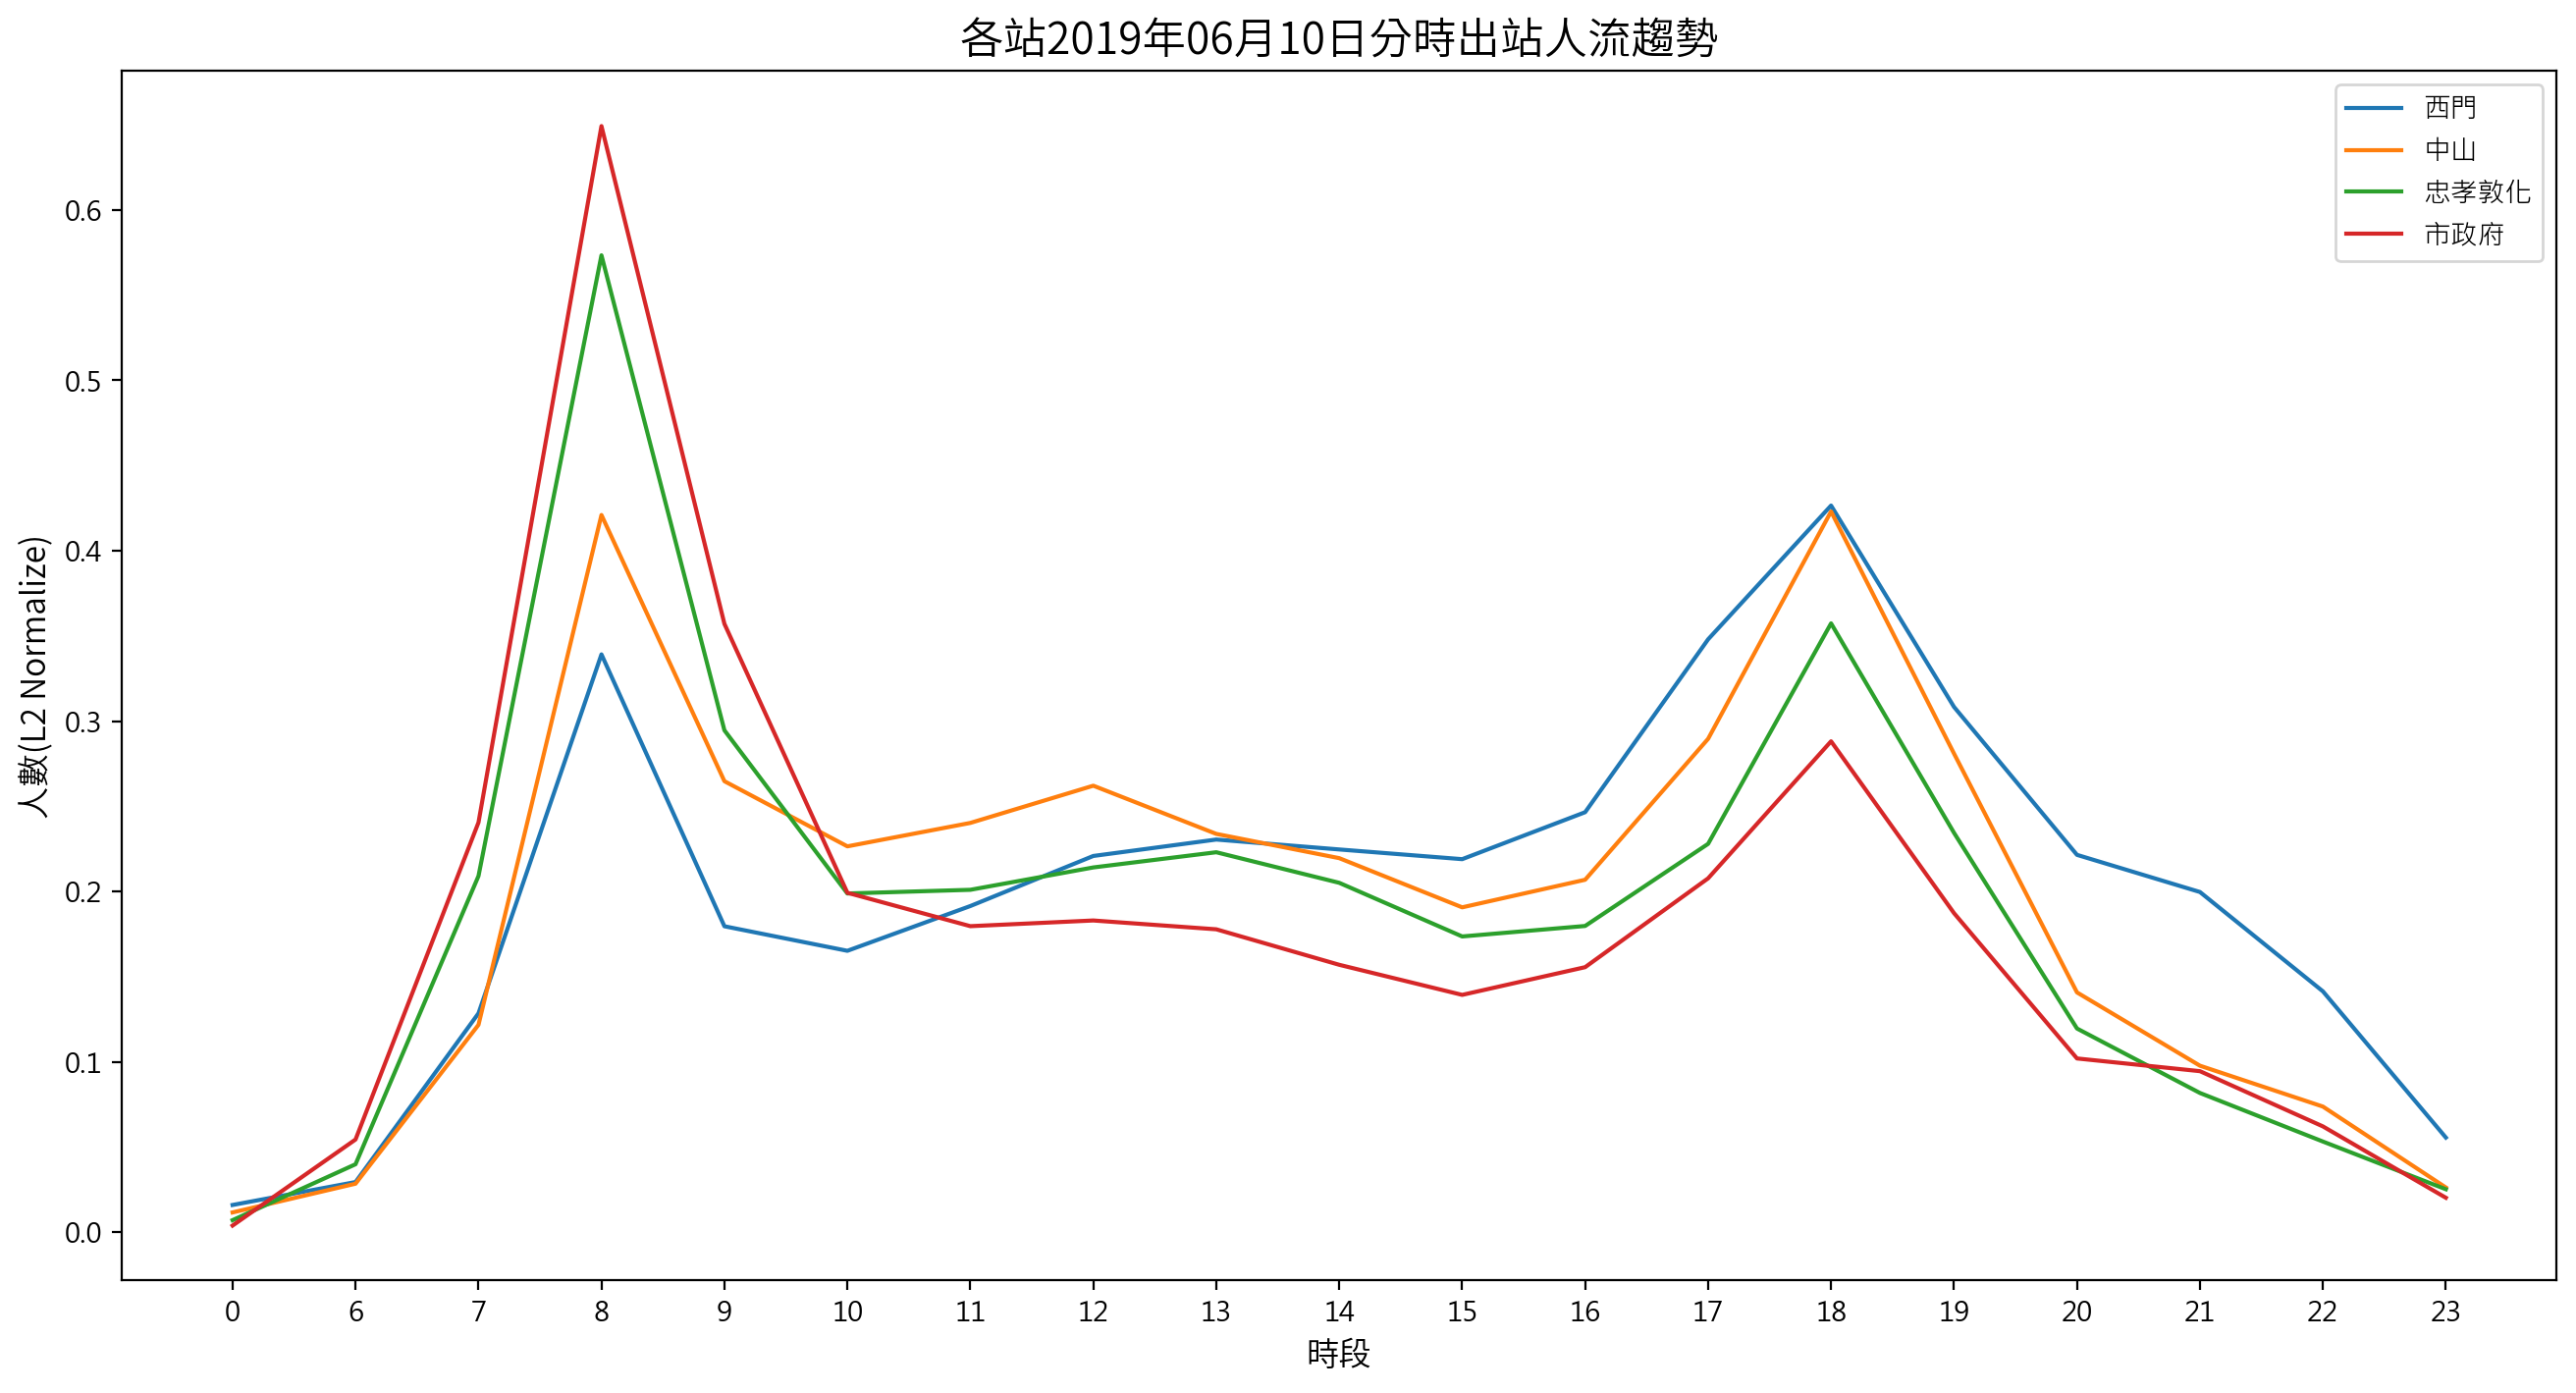

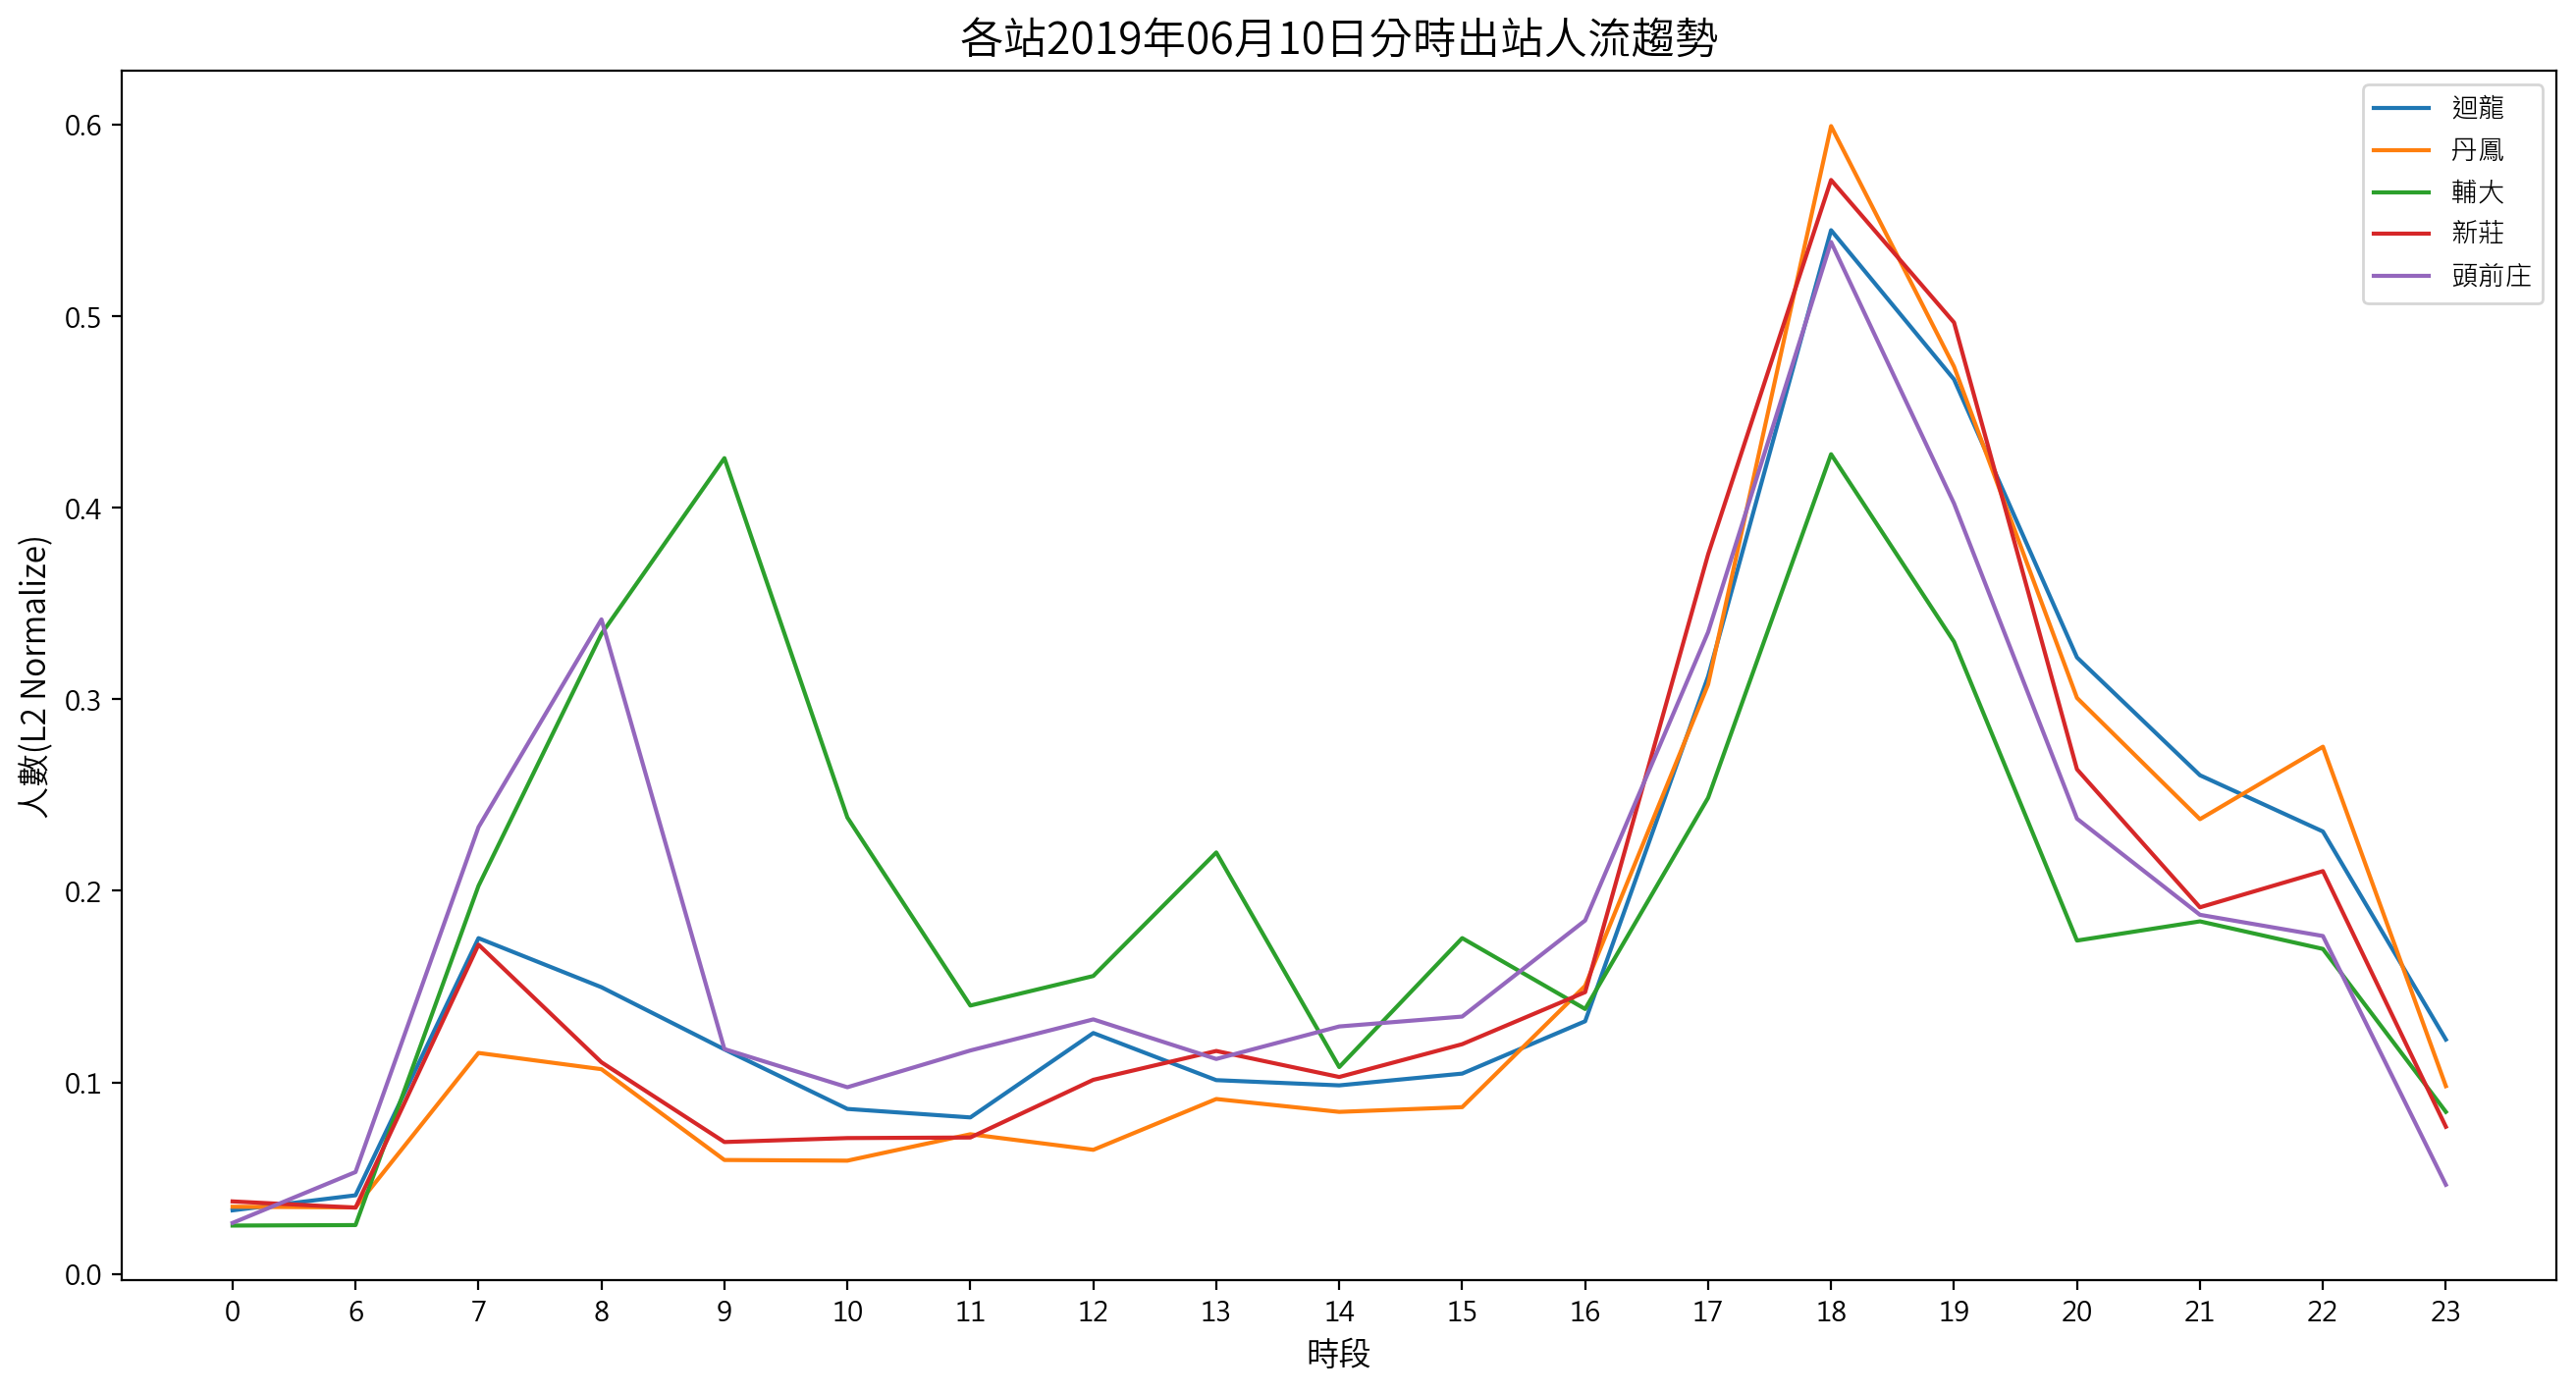

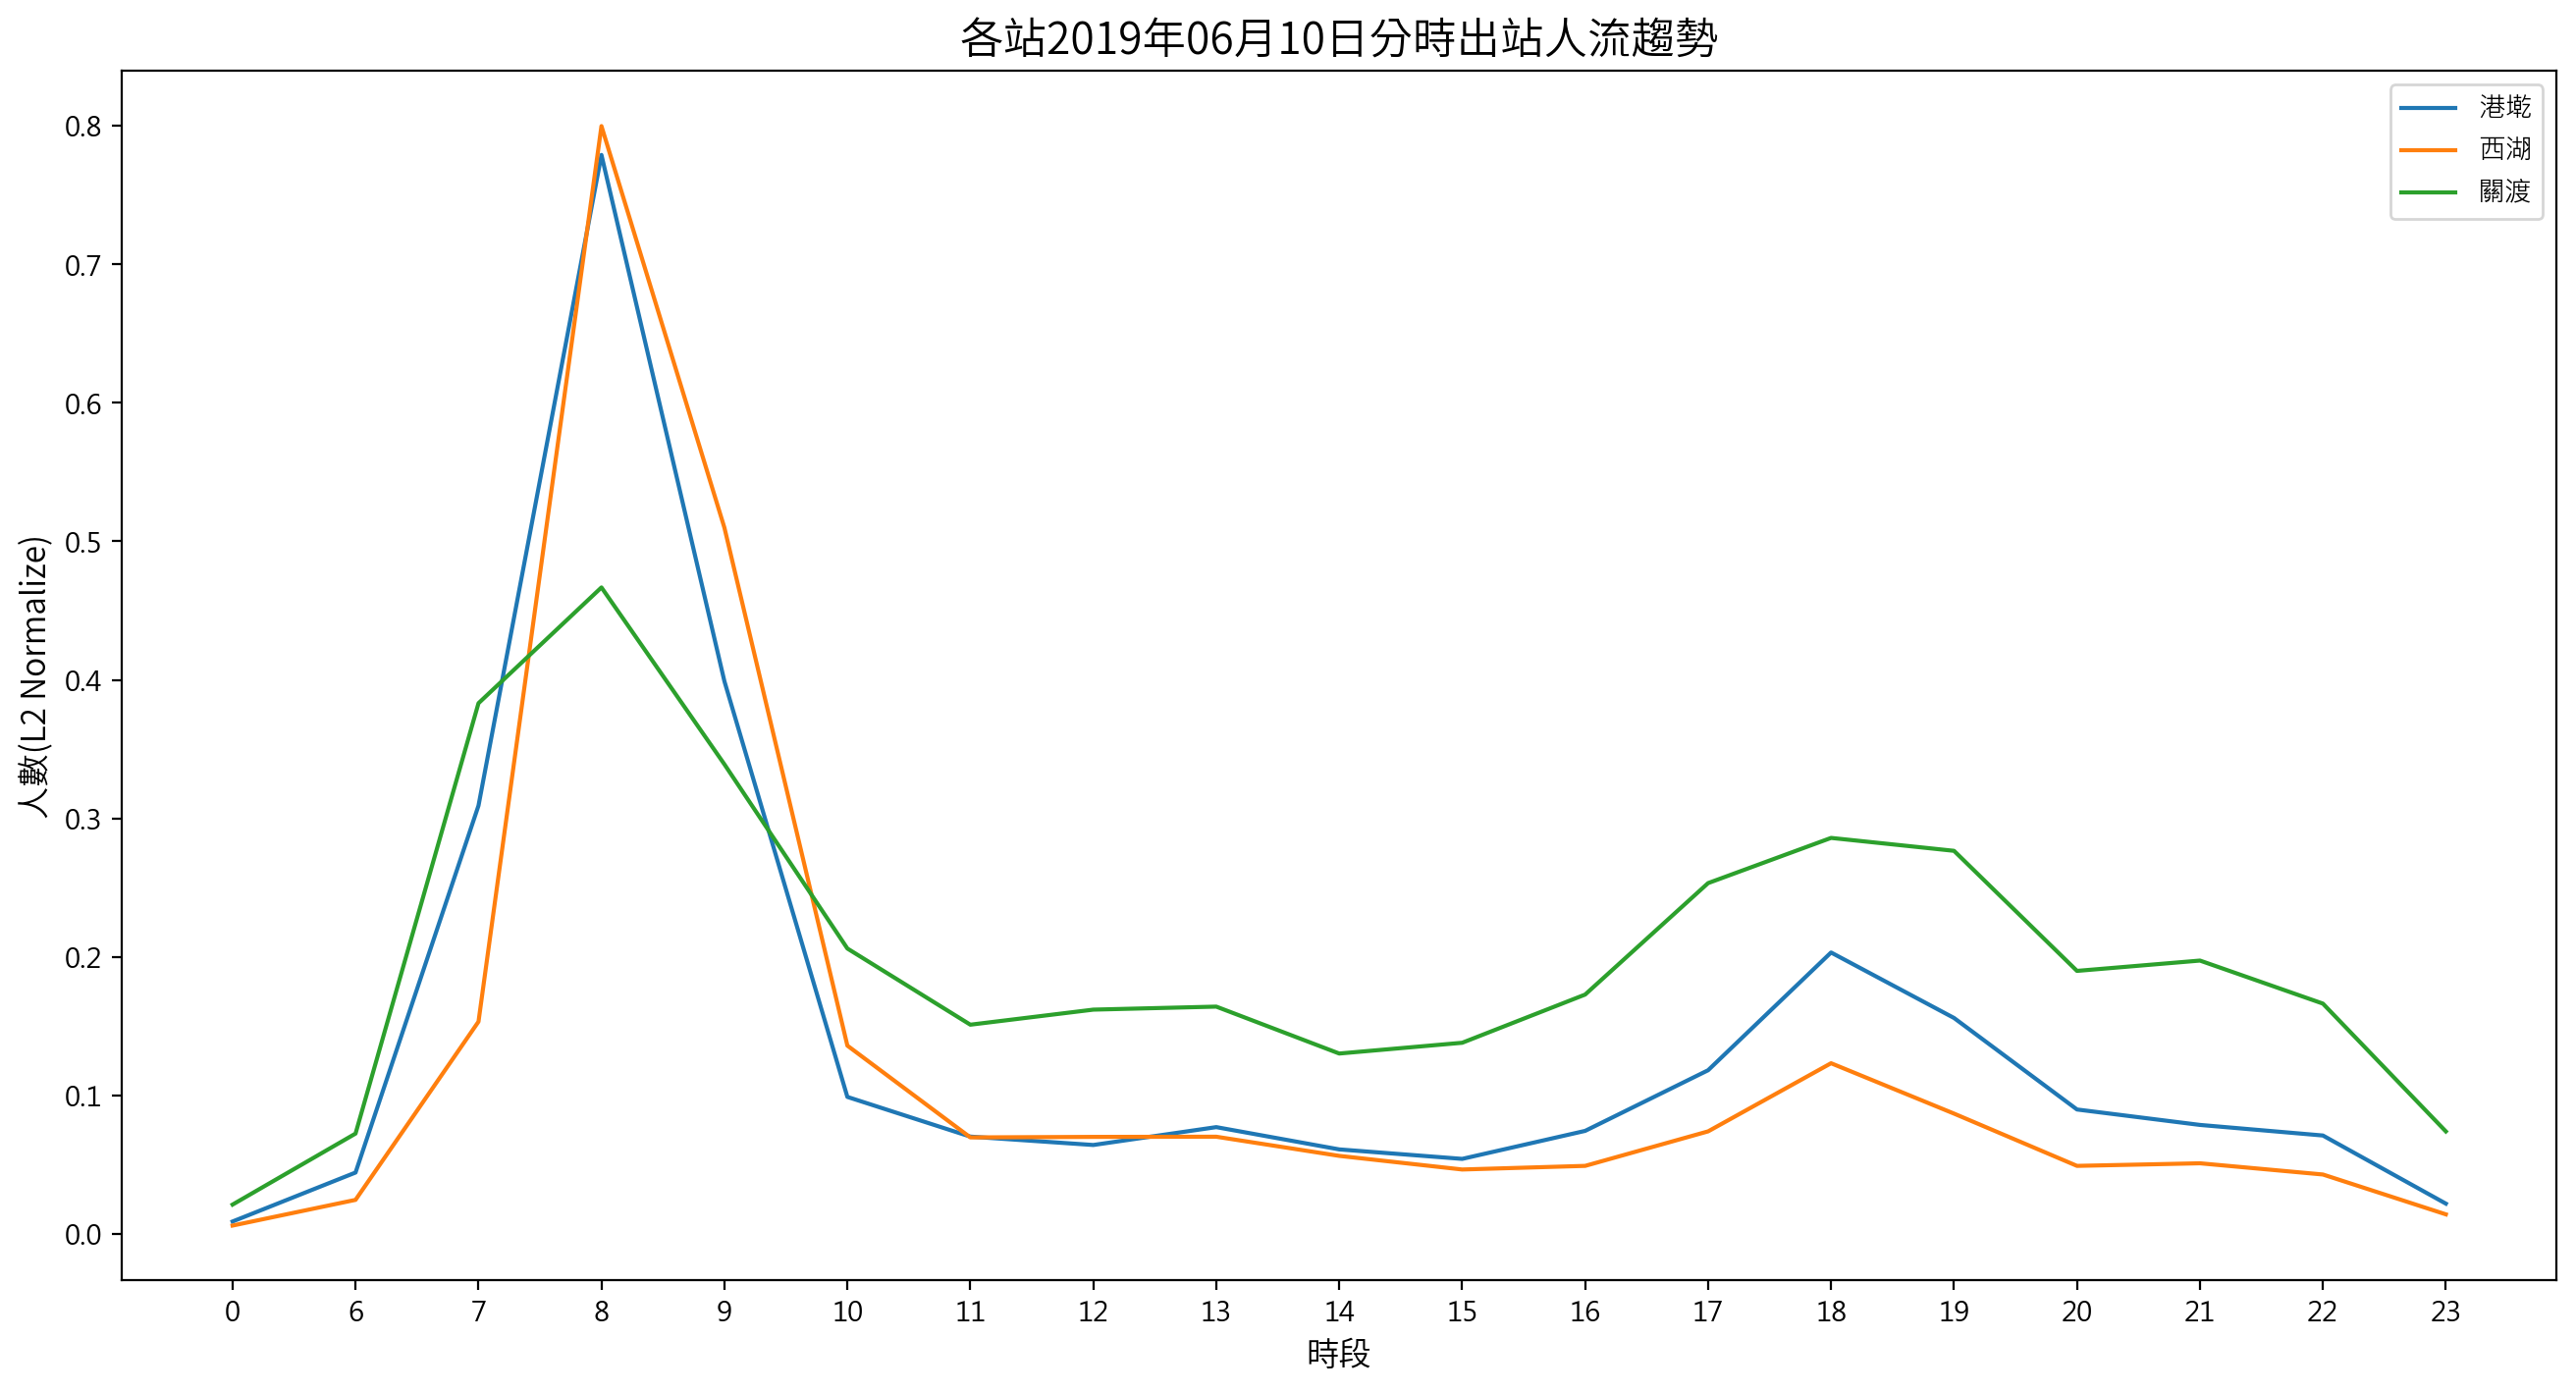

In [5]:
# 以 2019/06/10 (一) 為例
plot_inbound_pattern(stationNameList=["西門", "中山", "忠孝敦化", "市政府"],
                    year="2019", month="06", date="10")

plot_inbound_pattern(stationNameList=["迴龍", "丹鳳", "輔大", "新莊", "頭前庄"],
                     year="2019", month="06", date="10")

plot_inbound_pattern(stationNameList=["港墘", "西湖", "關渡"],
                     year="2019", month="06", date="10")

plot_outbound_pattern(stationNameList=["西門", "中山", "忠孝敦化", "市政府"],
                      year="2019", month="06", date="10")

plot_outbound_pattern(stationNameList=["迴龍", "丹鳳", "輔大", "新莊", "頭前庄"],
                      year="2019", month="06", date="10")

plot_outbound_pattern(stationNameList=["港墘", "西湖", "關渡"],
                      year="2019", month="06", date="10")

<a id="3.3"></a>
### COVID-19對台北捷運運量影響

2021 年台灣受到 COVID-19 疫情影響，並自 2021/05/15 起雙北實施三級警戒 (-2021/07/26)。三級警戒期間民眾生活型態產生變化，除捷運運量下降外，預期娛樂旅次也會降低。

因此，我們分析 2021 年 5 月進出站人數情形。透過下圖，我們可以發現在三級警戒期間，確實各站運量皆有明顯下降。不過以通勤旅次為主的車站 (如丹鳳、迴龍、港墘、西湖等站) 而言，進出站人流趨勢與實施三級警戒前相去不遠；然而像是西門站或中山站等鄰近商圈的車站，假日時段的進出站人流趨勢與實施三級警戒前有極大變化。

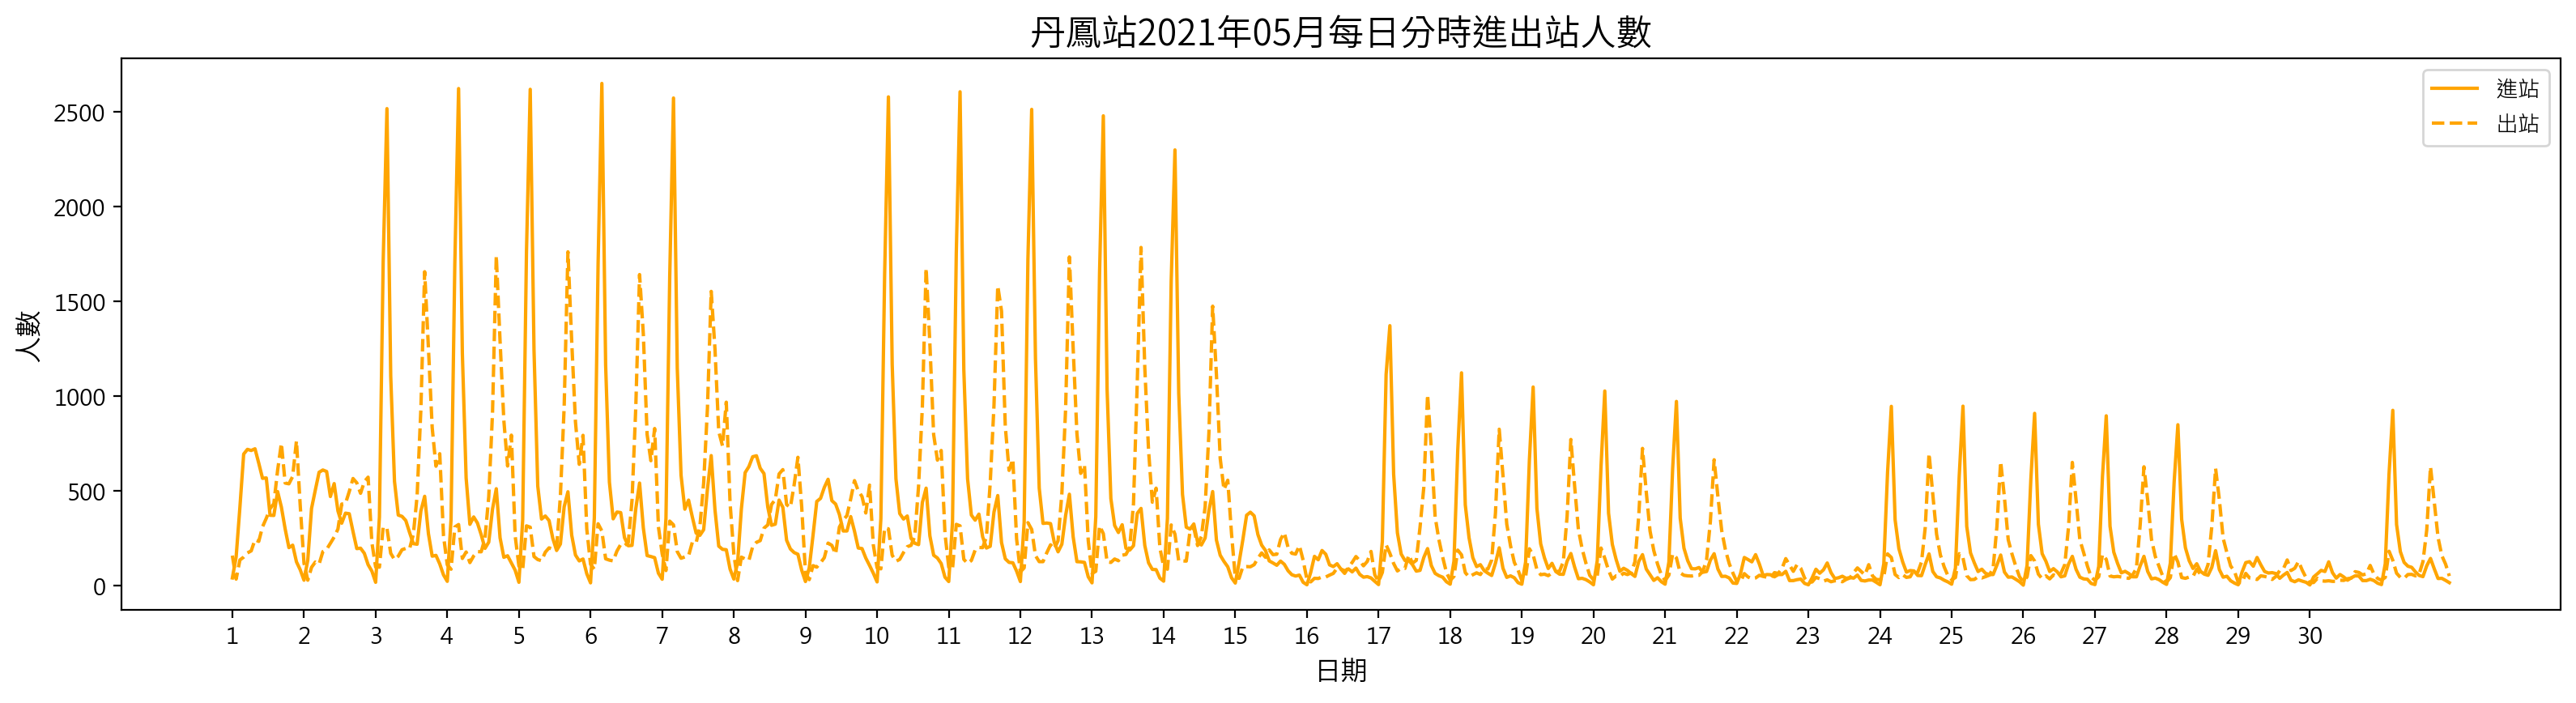

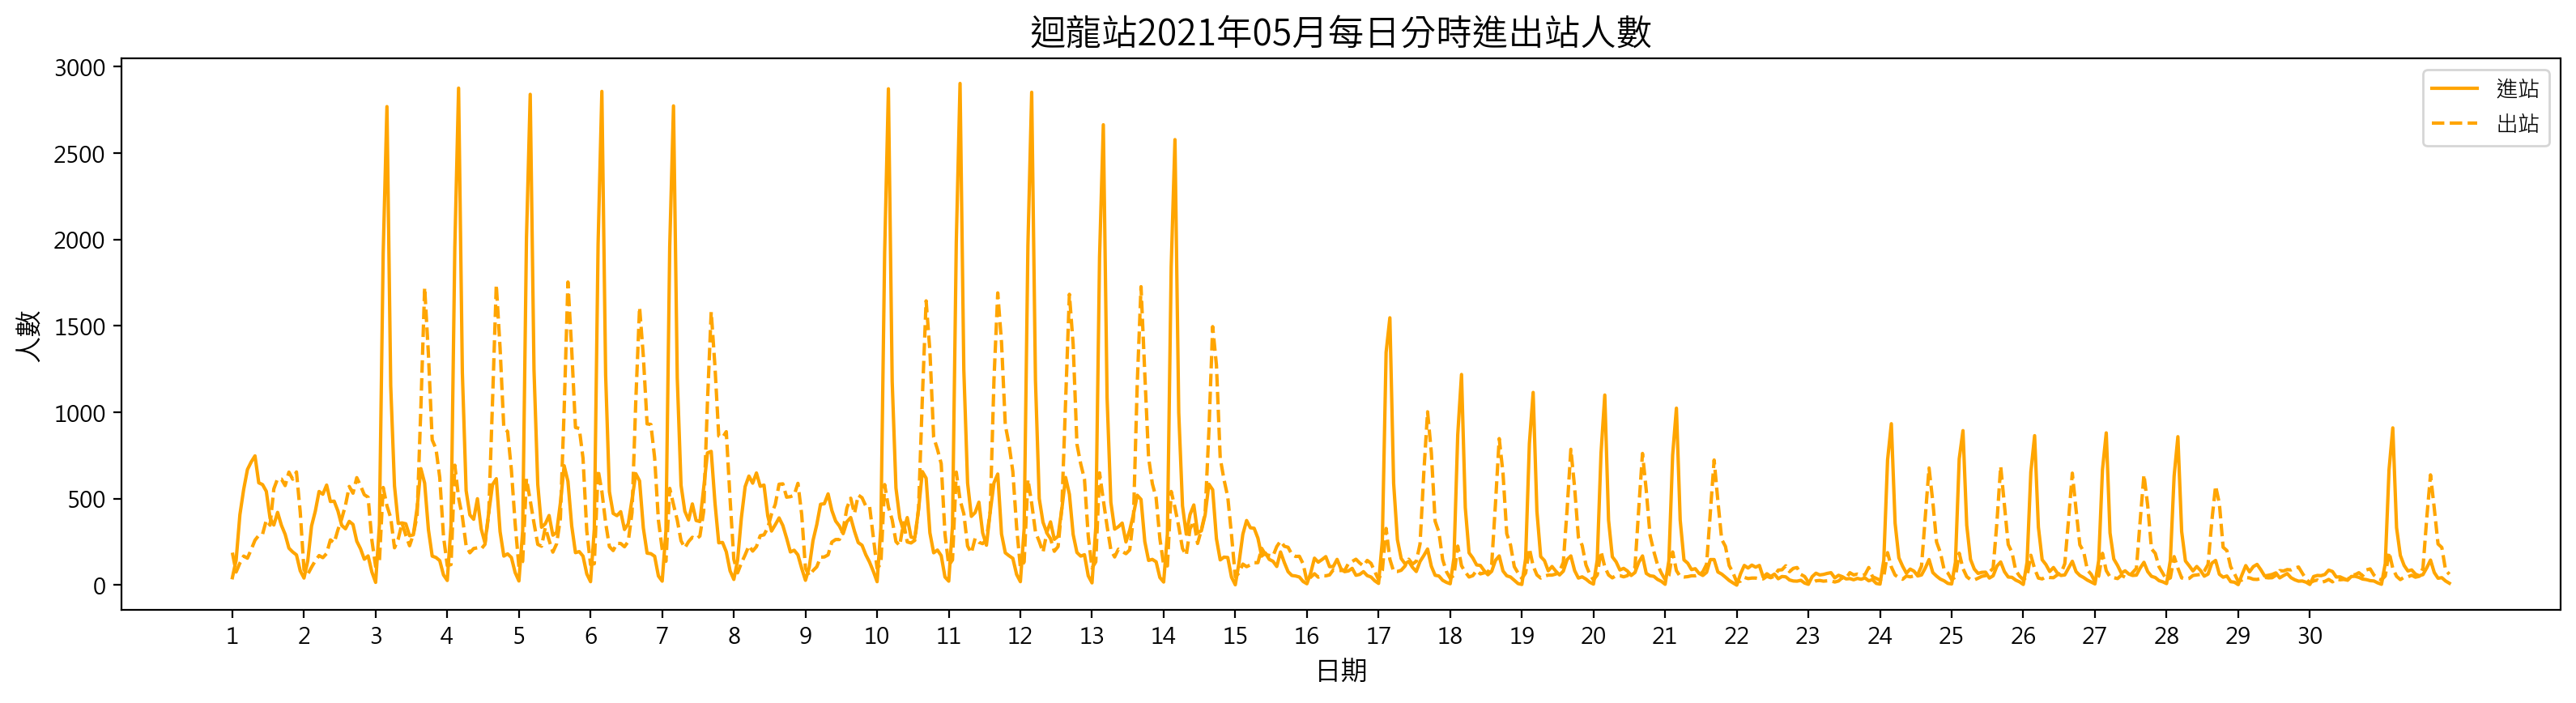

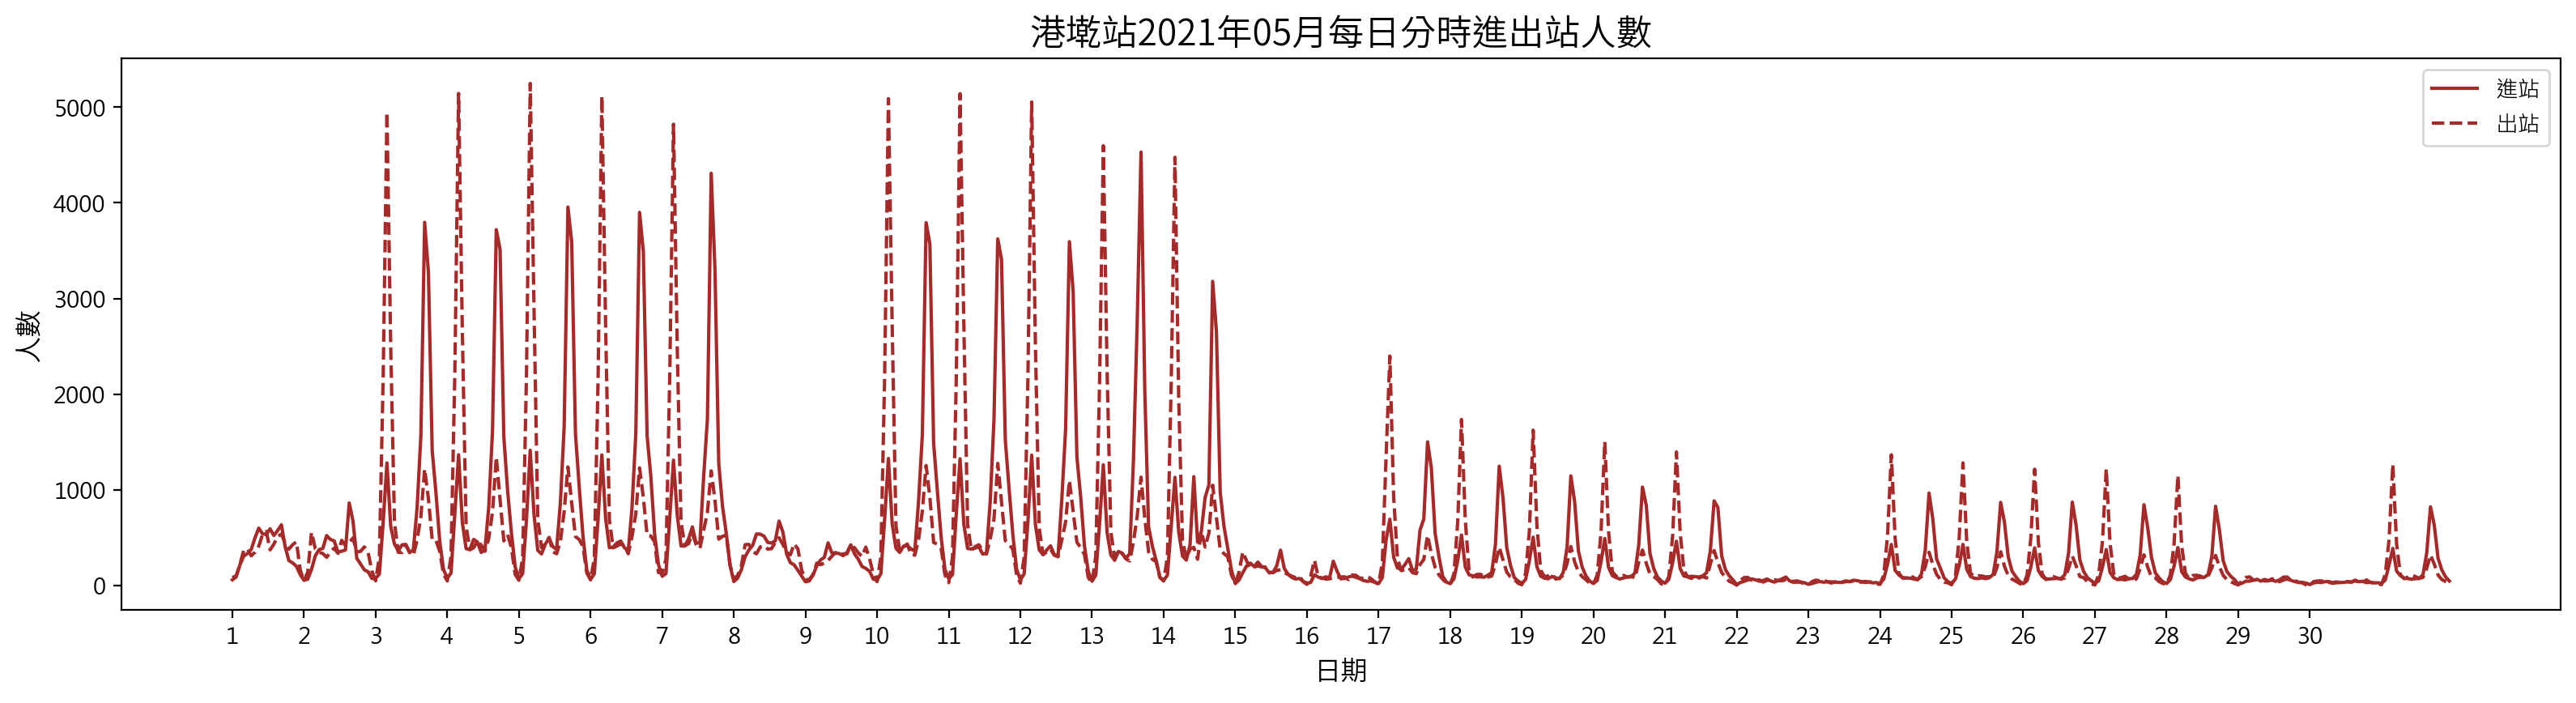

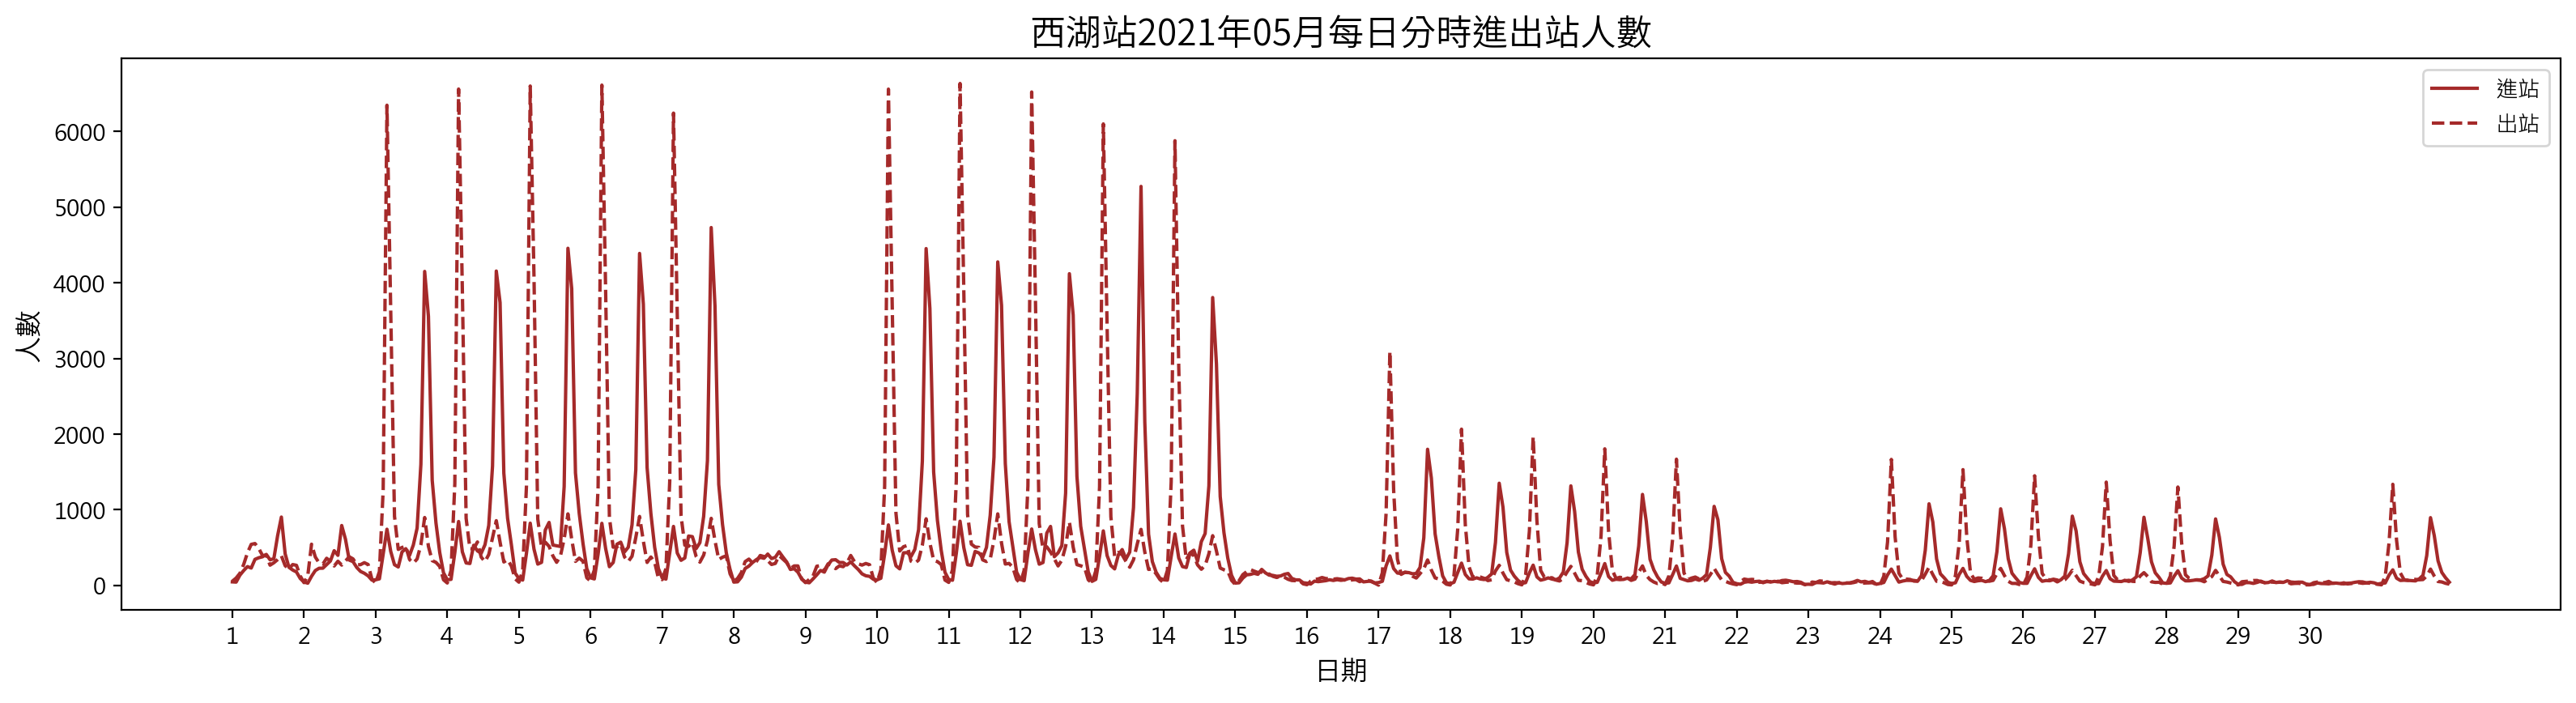

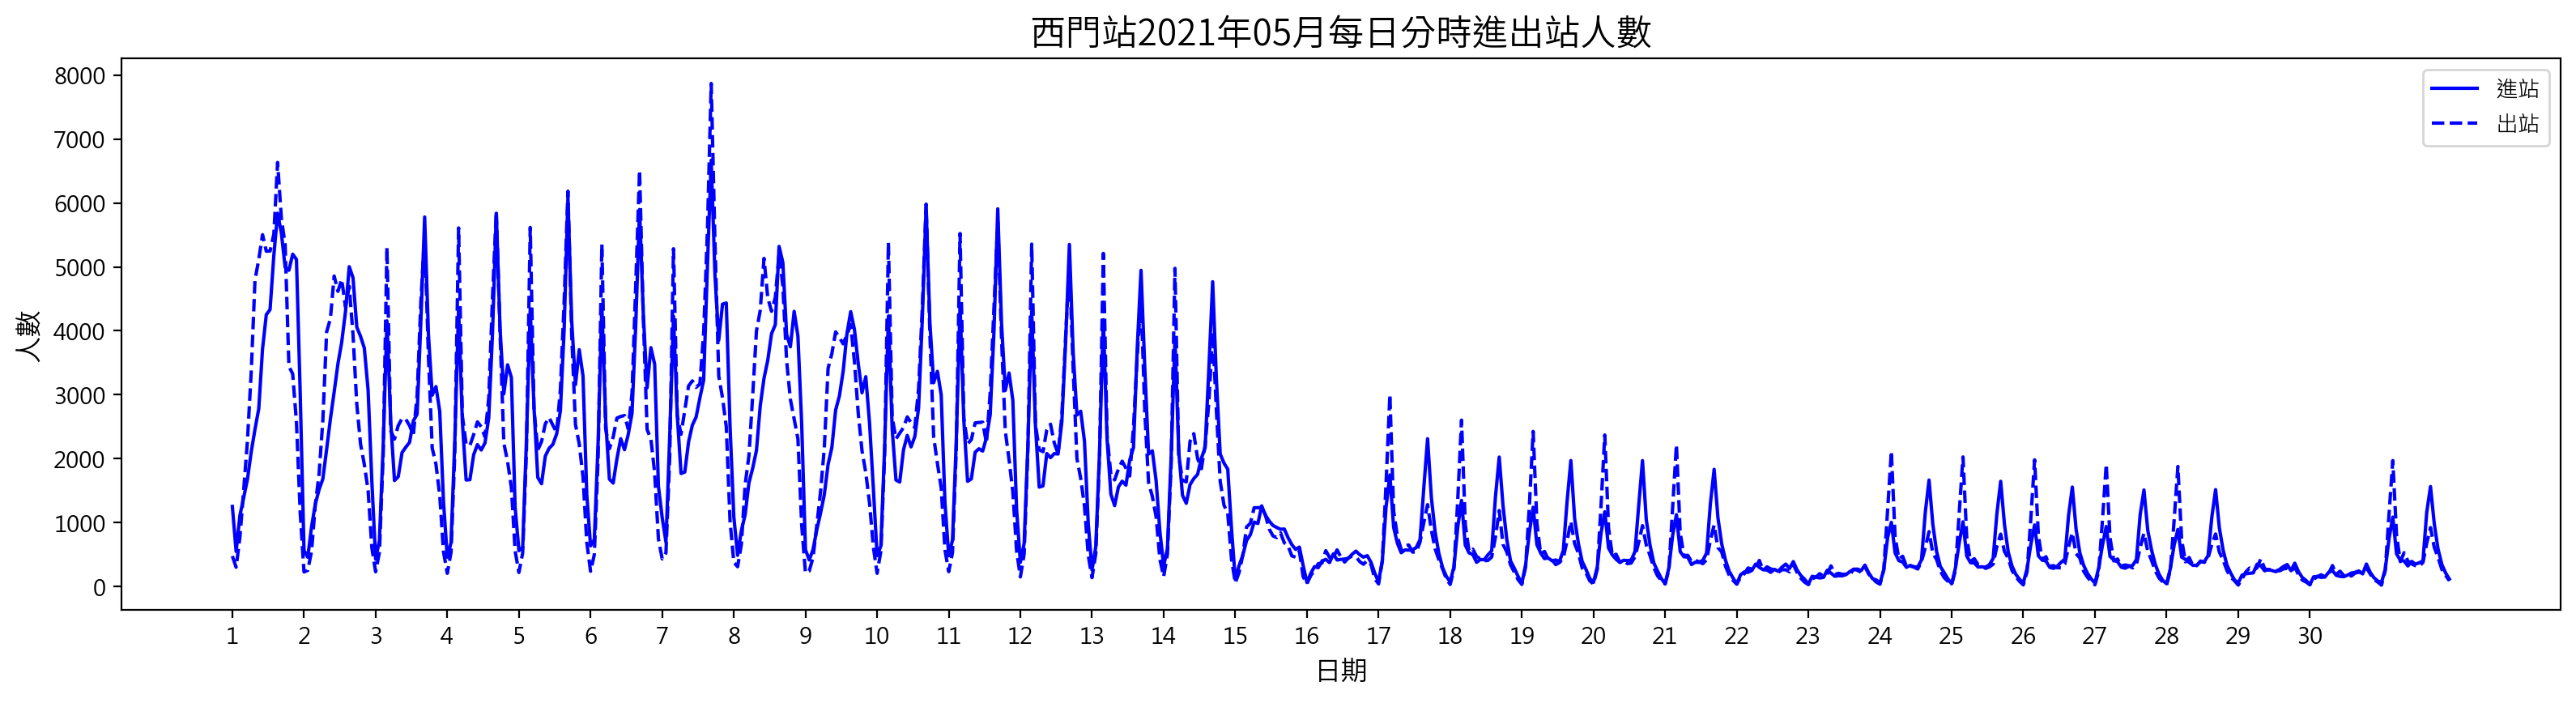

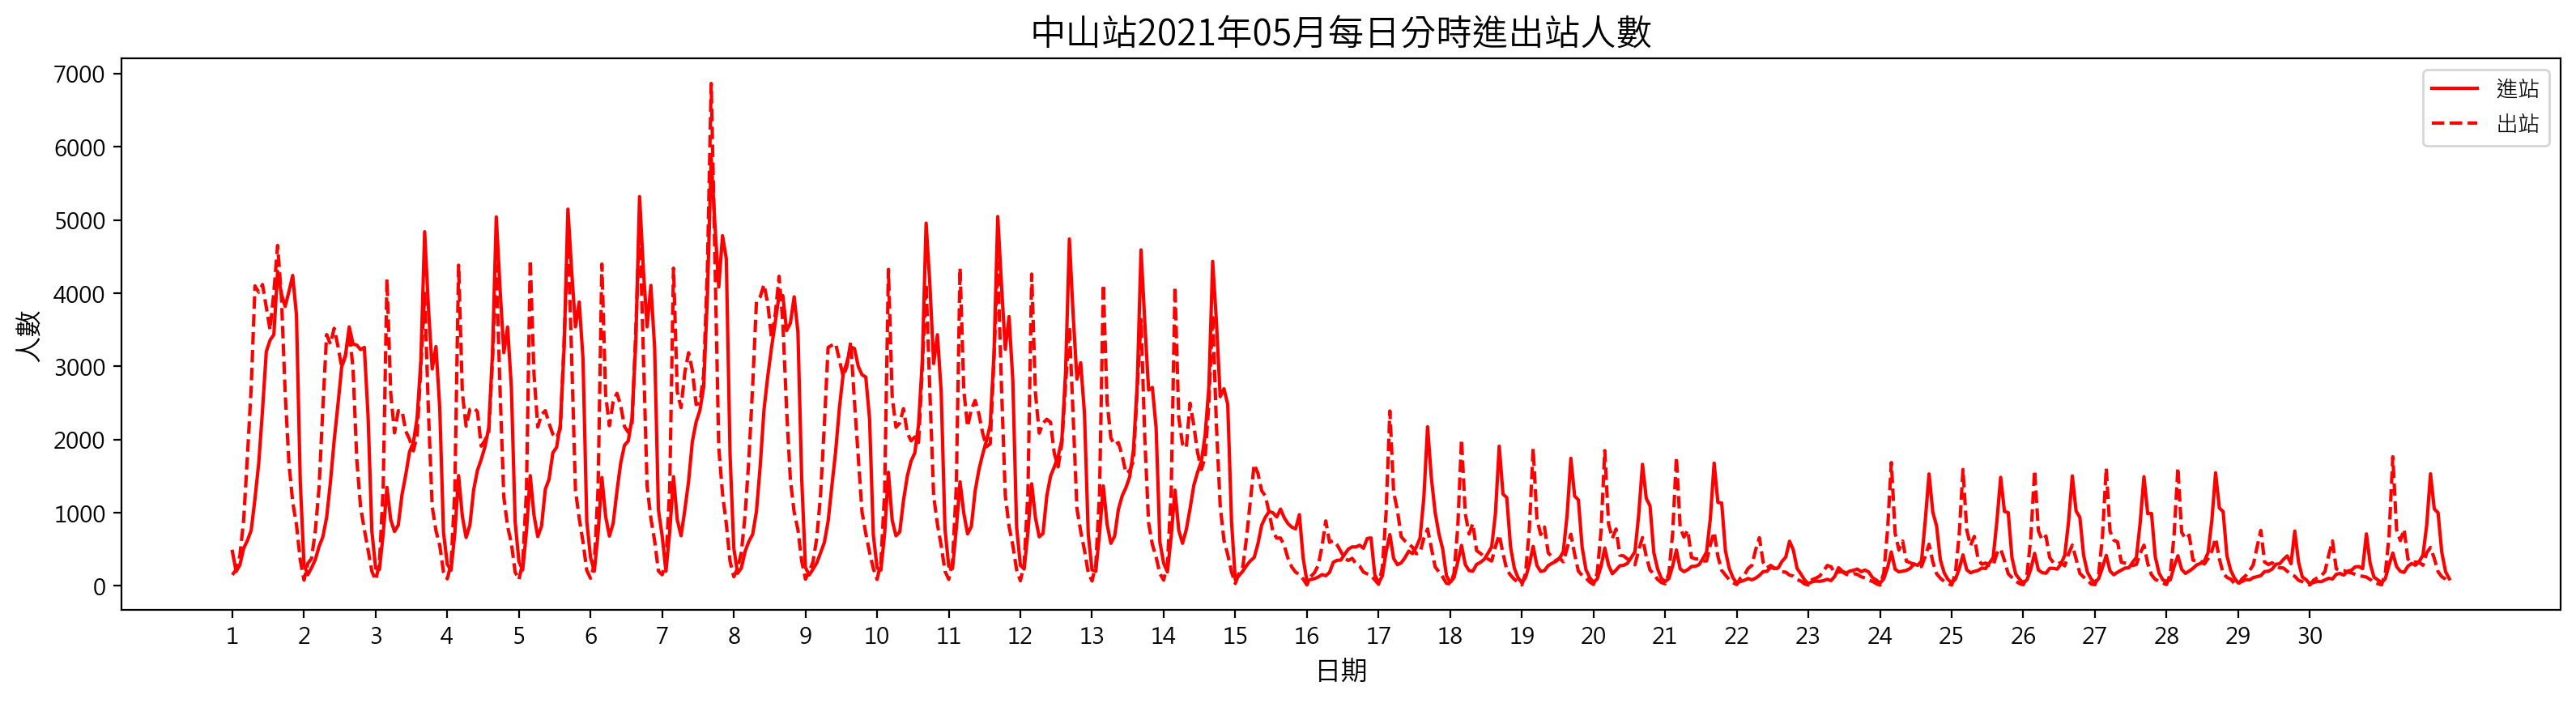

In [6]:
plot_stream(stationNameList=["丹鳳", "迴龍"], colorList=["orange", "orange"], year="2021", month="05")
plot_stream(stationNameList=["港墘", "西湖"], colorList=["brown", "brown"], year="2021", month="05")
plot_stream(stationNameList=["西門", "中山"], colorList=["blue", "red"], year="2021", month="05")

<a id="4"></a>
## 4. 特徵工程
***
* __[時間序列資料處理](#4.1)__
* __[訓練 Inbound AutoEncoder](#4.2)__
* __[訓練 Outbound AutoEncoder](#4.3)__
* __[進站趨勢分類](#4.4)__
* __[出站趨勢分類](#4.5)__
* __[車站規模分類](#4.6)__
* __[日期型態分類](#4.7)__
* __[其餘特徵提取、生成預測模型訓練資料集](#4.8)__

<a id="4.1"></a>
### 時間序列資料處理
我們在前面提到，希望可以將進出站人流趨勢類似的車站分群，而單日分時進出站人數即為一時間序列資料。

本專案預計利用 K-Means 演算法，將這些 Pattern 相似的車站分群。不過我們的資料共有 19 個維度 (6時-隔日0時)，而 K-Means 在高維度的分群表現通常不是那麼優秀，因此我們需要進行資料降維。

一個常見的資料降維技術為主成份分析 (PCA)，不過 PCA 假設各成份之間相互獨立，可能不適用於時間序列資料，且 PCA 僅能做到線性降維，在含有高度雜訊的時間序列資料，表現上可能不是那麼優秀，因此，本專案選擇利用 __AutoEncoder__ 進行 Feature Extraction。

本專案收集台北捷運系統 108 個車站 (扣除環狀線) 每日進出站人數之時間序列資料，作為 AutoEncoder 訓練資料。訓練時會區分進站和出站兩類，也就是我們會訓練兩個 AutoEncoder Neural Network。

In [7]:
years = [f"{year}" for year in range(2017, 2022)]
months = [f"{month:02d}" for month in range(1, 13)]

print("Start:", str(datetime.now())[:-7])
inbound_tables = []
outbound_tables = []

# 以下兩個是用來統計 5 年來各車站分時進出站總人數，我們會依據這個矩陣作為訓練好的 Encoder 的輸入
inbound_each_station_5yrs = np.zeros((108, 19))
outbound_each_station_5yrs = np.zeros((108, 19))

for year in years:
    for month in months:
        print(f"{year}-{month}")
        df = pd.read_csv(f"opendata/{year}{month}.csv", encoding="utf_8_sig", parse_dates=["日期"])
        df, stationList = filt(df)
        inbound_tables.append(calculateIN_each_station_each_hour(df, month, stationList))
        outbound_tables.append(calculateOUT_each_station_each_hour(df, month, stationList))
        inbound_each_station_5yrs += calculateIN_monthly(df, month, stationList)
        outbound_each_station_5yrs += calculateOUT_monthly(df, month, stationList)
        
print("2022-01")
df = pd.read_csv("opendata/202201.csv", encoding="utf_8_sig", parse_dates=["日期"])
df, stationList = filt(df)
inbound_tables.append(calculateIN_each_station_each_hour(df, "01", stationList))
outbound_tables.append(calculateOUT_each_station_each_hour(df, "01", stationList))
inbound_each_station_5yrs += calculateIN_monthly(df, "01", stationList)
outbound_each_station_5yrs += calculateOUT_monthly(df, "01", stationList)
            
inbound_table = np.concatenate(inbound_tables)
outbound_table = np.concatenate(outbound_tables)
print("End:", str(datetime.now())[:-7])
print("\n================== saving ==================")
np.savetxt("inbound_each_station_5yrs.txt", inbound_each_station_5yrs, delimiter=",")
np.savetxt("outbound_each_station_5yrs.txt", outbound_each_station_5yrs, delimiter=",")
np.savetxt("total_inbound_2017-202201.txt", inbound_table, delimiter=",")
np.savetxt("total_outbound_2017-202201.txt", outbound_table, delimiter=",")

Start: 2023-06-14 21:48:22
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-05
2019-06
2019-07
2019-08
2019-09
2019-10
2019-11
2019-12
2020-01
2020-02
2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
End: 2023-06-14 22:25:22

================== saving ==================


<a id="4.2"></a>
### 訓練 Inbound AutoEncoder

In [8]:
#==========================================================================================================================
# Load Inbound Dataset
#==========================================================================================================================
inbound_table = np.loadtxt("total_inbound_2017-202201.txt", delimiter=",")
inbound_table = normalize(inbound_table)
print("inbound_table.shape: ", inbound_table.shape)


#==========================================================================================================================
# 建立 Inbound AutoEncoder Deep Neural Network
#==========================================================================================================================

inbound_encoder_input = keras.Input(shape=(inbound_table.shape[1],))
x = keras.layers.Dense(32, activation="relu")(inbound_encoder_input)
x = keras.layers.Dense(32, activation="relu")(x)
inbound_encoder_output = keras.layers.Dense(8, activation="relu")(x)
inbound_encoder = keras.Model(inbound_encoder_input, inbound_encoder_output, name="inbound_encoder")

inbound_decoder_input = keras.layers.Dense(32, activation="relu")(inbound_encoder_output)
x = keras.layers.Dense(32, activation="relu")(inbound_decoder_input)
inbound_decoder_output = keras.layers.Dense(inbound_table.shape[1], activation="sigmoid")(x)

inbound_autoencoder = keras.Model(inbound_encoder_input, inbound_decoder_output, name="inbound_autoencoder")
inbound_autoencoder.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-3,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-08,
        decay=1e-6
    )
)
inbound_autoencoder.summary()

inbound_table.shape:  (200556, 19)
Model: "inbound_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 32)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (De

In [9]:
x_train, x_test, _, _ = train_test_split(inbound_table, inbound_table, random_state=42, test_size=0.1)

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min")

# start training
history = inbound_autoencoder.fit(
    x_train, x_train,
    validation_split=0.1,
    epochs=500,
    batch_size=32,
    shuffle=True,
    verbose=1,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/500
5077/5077 [==============================] - 17s 3ms/step - loss: 0.0018 - val_loss: 3.6458e-04
Epoch 2/500
5077/5077 [==============================] - 14s 3ms/step - loss: 3.0662e-04 - val_loss: 2.7371e-04
Epoch 3/500
5077/5077 [==============================] - 17s 3ms/step - loss: 2.5899e-04 - val_loss: 2.4607e-04
Epoch 4/500
5077/5077 [==============================] - 17s 3ms/step - loss: 2.4099e-04 - val_loss: 2.3532e-04
Epoch 5/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.3104e-04 - val_loss: 2.2732e-04
Epoch 6/500
5077/5077 [==============================] - 14s 3ms/step - loss: 2.2549e-04 - val_loss: 2.2465e-04
Epoch 7/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.2120e-04 - val_loss: 2.2090e-04
Epoch 8/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.1711e-04 - val_loss: 2.1660e-04
Epoch 9/500
5077/5077 [==============================] - 17s 3ms/step - loss: 2.1356e-04 - val_loss: 2.1915e

5077/5077 [==============================] - 17s 3ms/step - loss: 1.4513e-04 - val_loss: 1.4383e-04
Epoch 74/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4498e-04 - val_loss: 1.4395e-04
Epoch 75/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4486e-04 - val_loss: 1.4497e-04
Epoch 76/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4464e-04 - val_loss: 1.4403e-04
Epoch 77/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4450e-04 - val_loss: 1.4372e-04
Epoch 78/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4422e-04 - val_loss: 1.4339e-04
Epoch 79/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4410e-04 - val_loss: 1.4380e-04
Epoch 80/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4394e-04 - val_loss: 1.4288e-04
Epoch 81/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4374e-04 - val_loss: 1.4255e

5077/5077 [==============================] - 16s 3ms/step - loss: 1.3798e-04 - val_loss: 1.3682e-04
Epoch 146/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3753e-04 - val_loss: 1.3689e-04
Epoch 147/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3746e-04 - val_loss: 1.3656e-04
Epoch 148/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3748e-04 - val_loss: 1.3756e-04
Epoch 149/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3744e-04 - val_loss: 1.3729e-04
Epoch 150/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3709e-04 - val_loss: 1.3680e-04
Epoch 151/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3738e-04 - val_loss: 1.3773e-04
Epoch 152/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3709e-04 - val_loss: 1.3954e-04
Epoch 153/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.3719e-04 - val_loss:

Epoch 217/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1404e-04 - val_loss: 1.1272e-04
Epoch 218/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1397e-04 - val_loss: 1.1241e-04
Epoch 219/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1380e-04 - val_loss: 1.1250e-04
Epoch 220/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1368e-04 - val_loss: 1.1366e-04
Epoch 221/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1366e-04 - val_loss: 1.1279e-04
Epoch 222/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1356e-04 - val_loss: 1.1247e-04
Epoch 223/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1348e-04 - val_loss: 1.1268e-04
Epoch 224/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1330e-04 - val_loss: 1.1258e-04
Epoch 225/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1324e-

Epoch 289/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1041e-04 - val_loss: 1.1044e-04
Epoch 290/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1038e-04 - val_loss: 1.1106e-04
Epoch 291/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1032e-04 - val_loss: 1.0973e-04
Epoch 292/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1028e-04 - val_loss: 1.0994e-04
Epoch 293/500
5077/5077 [==============================] - 17s 3ms/step - loss: 1.1027e-04 - val_loss: 1.0986e-04
Epoch 294/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1021e-04 - val_loss: 1.0934e-04
Epoch 295/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1026e-04 - val_loss: 1.0878e-04
Epoch 296/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1018e-04 - val_loss: 1.0907e-04
Epoch 297/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.1012e-

Epoch 361/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0906e-04 - val_loss: 1.0931e-04
Epoch 362/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0909e-04 - val_loss: 1.0920e-04
Epoch 363/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0906e-04 - val_loss: 1.0902e-04
Epoch 364/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0908e-04 - val_loss: 1.0922e-04
Epoch 365/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0907e-04 - val_loss: 1.0823e-04
Epoch 366/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0904e-04 - val_loss: 1.0900e-04
Epoch 367/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0903e-04 - val_loss: 1.0831e-04
Epoch 368/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0898e-04 - val_loss: 1.1044e-04
Epoch 369/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0901e-

Epoch 433/500
5077/5077 [==============================] - 17s 3ms/step - loss: 1.0832e-04 - val_loss: 1.0776e-04
Epoch 434/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0831e-04 - val_loss: 1.0802e-04
Epoch 435/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0831e-04 - val_loss: 1.0887e-04
Epoch 436/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0830e-04 - val_loss: 1.0827e-04
Epoch 437/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0827e-04 - val_loss: 1.0830e-04
Epoch 438/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0831e-04 - val_loss: 1.0760e-04
Epoch 439/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0826e-04 - val_loss: 1.0892e-04
Epoch 440/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0827e-04 - val_loss: 1.0758e-04
Epoch 441/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.0825e-

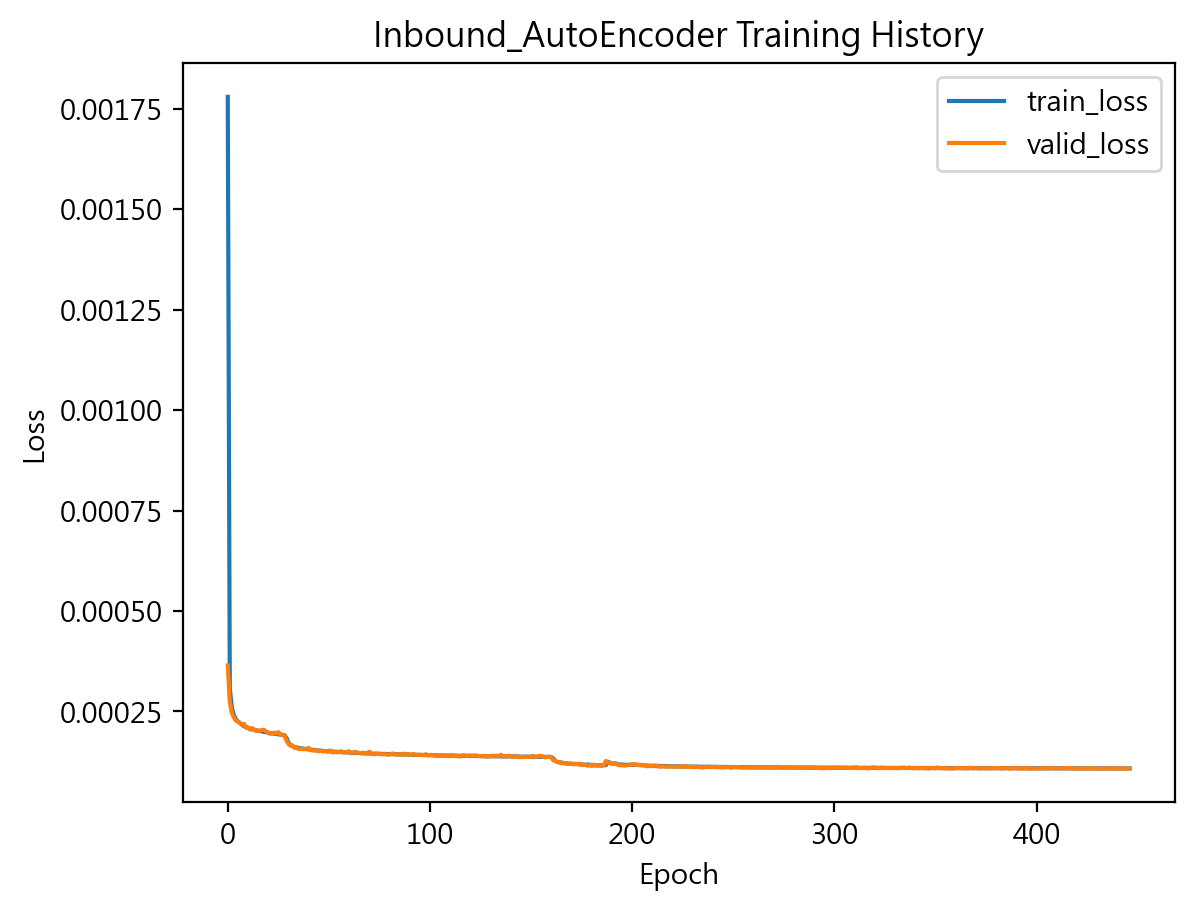

In [10]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="valid_loss")
plt.title("Inbound_AutoEncoder Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<a id="4.3"></a>
### 訓練 Outbound AutoEncoder

In [11]:
#==========================================================================================================================
# Load Outbound Dataset
#==========================================================================================================================
outbound_table = np.loadtxt("total_outbound_2017-202201.txt", delimiter=",")
outbound_table = normalize(outbound_table)
print("outbound_table.shape: ", outbound_table.shape)


#==========================================================================================================================
# 建立 Outbound AutoEncoder Deep Neural Network
#==========================================================================================================================

outbound_encoder_input = keras.Input(shape=(outbound_table.shape[1],))
x = keras.layers.Dense(32, activation="relu")(outbound_encoder_input)
x = keras.layers.Dense(32, activation="relu")(x)
outbound_encoder_output = keras.layers.Dense(8, activation="relu")(x)
outbound_encoder = keras.Model(outbound_encoder_input, outbound_encoder_output, name="outbound_encoder")

outbound_decoder_input = keras.layers.Dense(32, activation="relu")(outbound_encoder_output)
x = keras.layers.Dense(32, activation="relu")(outbound_decoder_input)
outbound_decoder_output = keras.layers.Dense(outbound_table.shape[1], activation="sigmoid")(x)

outbound_autoencoder = keras.Model(outbound_encoder_input, outbound_decoder_output, name="outbound_autoencoder")
outbound_autoencoder.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-3,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-08,
        decay=1e-6
    )
)
outbound_autoencoder.summary()

outbound_table.shape:  (200556, 19)
Model: "outbound_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                640       
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
 dense_9 (Dense)             (None, 32)                288       
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 

In [12]:
x_train, x_test, _, _ = train_test_split(outbound_table, outbound_table, random_state=42, test_size=0.1)

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min")

# start training
history = outbound_autoencoder.fit(
    x_train, x_train,
    validation_split=0.1,
    epochs=500,
    batch_size=32,
    shuffle=True,
    verbose=1,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/500
5077/5077 [==============================] - 17s 3ms/step - loss: 0.0018 - val_loss: 3.9434e-04
Epoch 2/500
5077/5077 [==============================] - 17s 3ms/step - loss: 3.4774e-04 - val_loss: 2.9917e-04
Epoch 3/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.8593e-04 - val_loss: 2.7574e-04
Epoch 4/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.6675e-04 - val_loss: 2.6281e-04
Epoch 5/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.5538e-04 - val_loss: 2.5349e-04
Epoch 6/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.4814e-04 - val_loss: 2.4622e-04
Epoch 7/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.4319e-04 - val_loss: 2.4953e-04
Epoch 8/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.3955e-04 - val_loss: 2.3977e-04
Epoch 9/500
5077/5077 [==============================] - 16s 3ms/step - loss: 2.3666e-04 - val_loss: 2.3824e

5077/5077 [==============================] - 17s 3ms/step - loss: 1.5962e-04 - val_loss: 1.6274e-04
Epoch 74/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5916e-04 - val_loss: 1.6158e-04
Epoch 75/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5970e-04 - val_loss: 1.6450e-04
Epoch 76/500
5077/5077 [==============================] - 17s 3ms/step - loss: 1.5930e-04 - val_loss: 1.6237e-04
Epoch 77/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5934e-04 - val_loss: 1.6189e-04
Epoch 78/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5835e-04 - val_loss: 1.5897e-04
Epoch 79/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5879e-04 - val_loss: 1.6056e-04
Epoch 80/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5917e-04 - val_loss: 1.6206e-04
Epoch 81/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5813e-04 - val_loss: 1.5895e

5077/5077 [==============================] - 16s 3ms/step - loss: 1.5206e-04 - val_loss: 1.5259e-04
Epoch 146/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5231e-04 - val_loss: 1.5368e-04
Epoch 147/500
5077/5077 [==============================] - 17s 3ms/step - loss: 1.5068e-04 - val_loss: 1.5221e-04
Epoch 148/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5069e-04 - val_loss: 1.5539e-04
Epoch 149/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5139e-04 - val_loss: 1.5299e-04
Epoch 150/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5180e-04 - val_loss: 1.5292e-04
Epoch 151/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5136e-04 - val_loss: 1.5210e-04
Epoch 152/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5191e-04 - val_loss: 1.5250e-04
Epoch 153/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.5058e-04 - val_loss:

Epoch 217/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4864e-04 - val_loss: 1.4986e-04
Epoch 218/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4747e-04 - val_loss: 1.5115e-04
Epoch 219/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4755e-04 - val_loss: 1.5132e-04
Epoch 220/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4745e-04 - val_loss: 1.4991e-04
Epoch 221/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4756e-04 - val_loss: 1.5166e-04
Epoch 222/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4845e-04 - val_loss: 1.5072e-04
Epoch 223/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4757e-04 - val_loss: 1.4957e-04
Epoch 224/500
5077/5077 [==============================] - 16s 3ms/step - loss: 1.4850e-04 - val_loss: 1.5130e-04
Epoch 225/500
5077/5077 [==============================] - 17s 3ms/step - loss: 1.4890e-

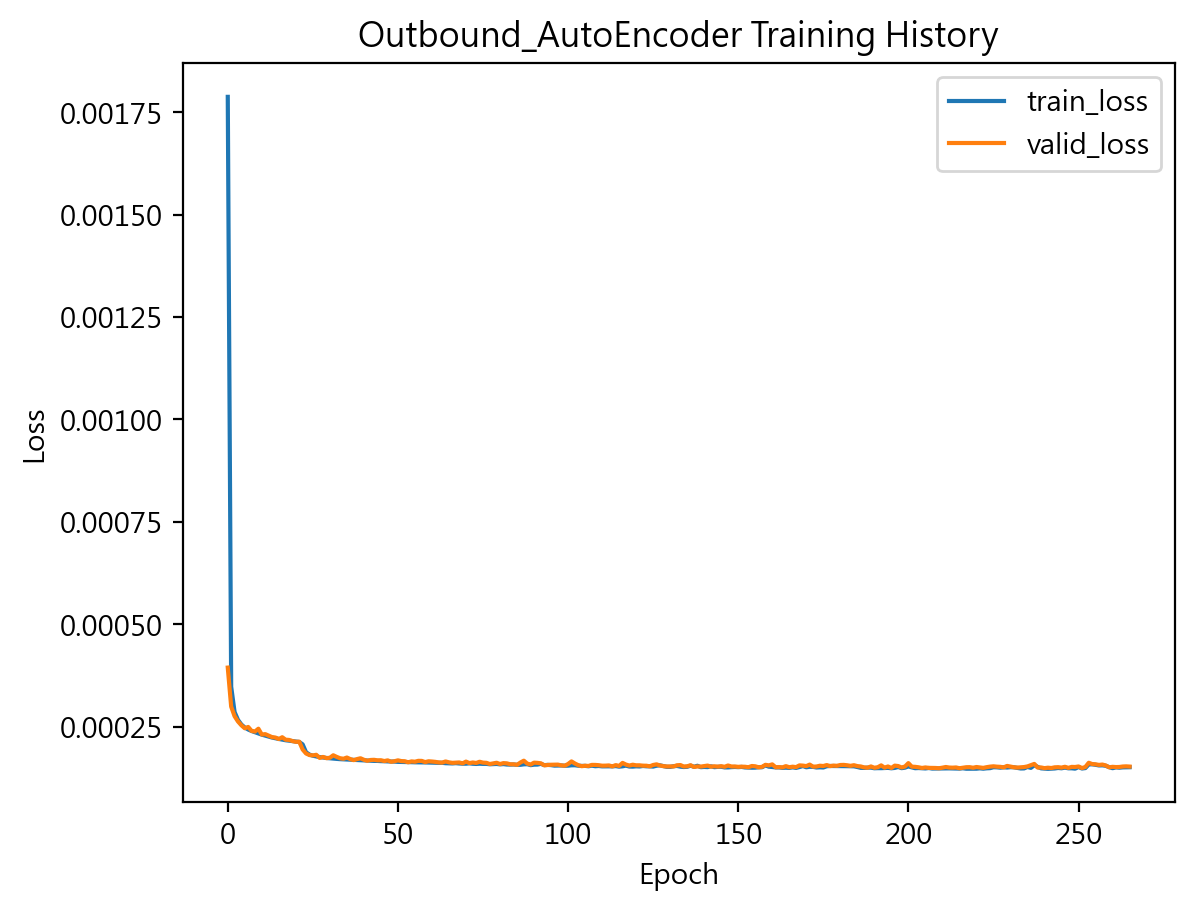

In [13]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="valid_loss")
plt.title("Outbound_AutoEncoder Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<a id="4.4"></a>
### 進站趨勢分類
首先根據進站趨勢進行分群。

將 inbound_each_station_5yrs.txt 的 array 進行 L2 Normalize 後，再投入訓練好的 Inbound Encoder 進行 Dimension Reduction。

D:\Users\63984\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


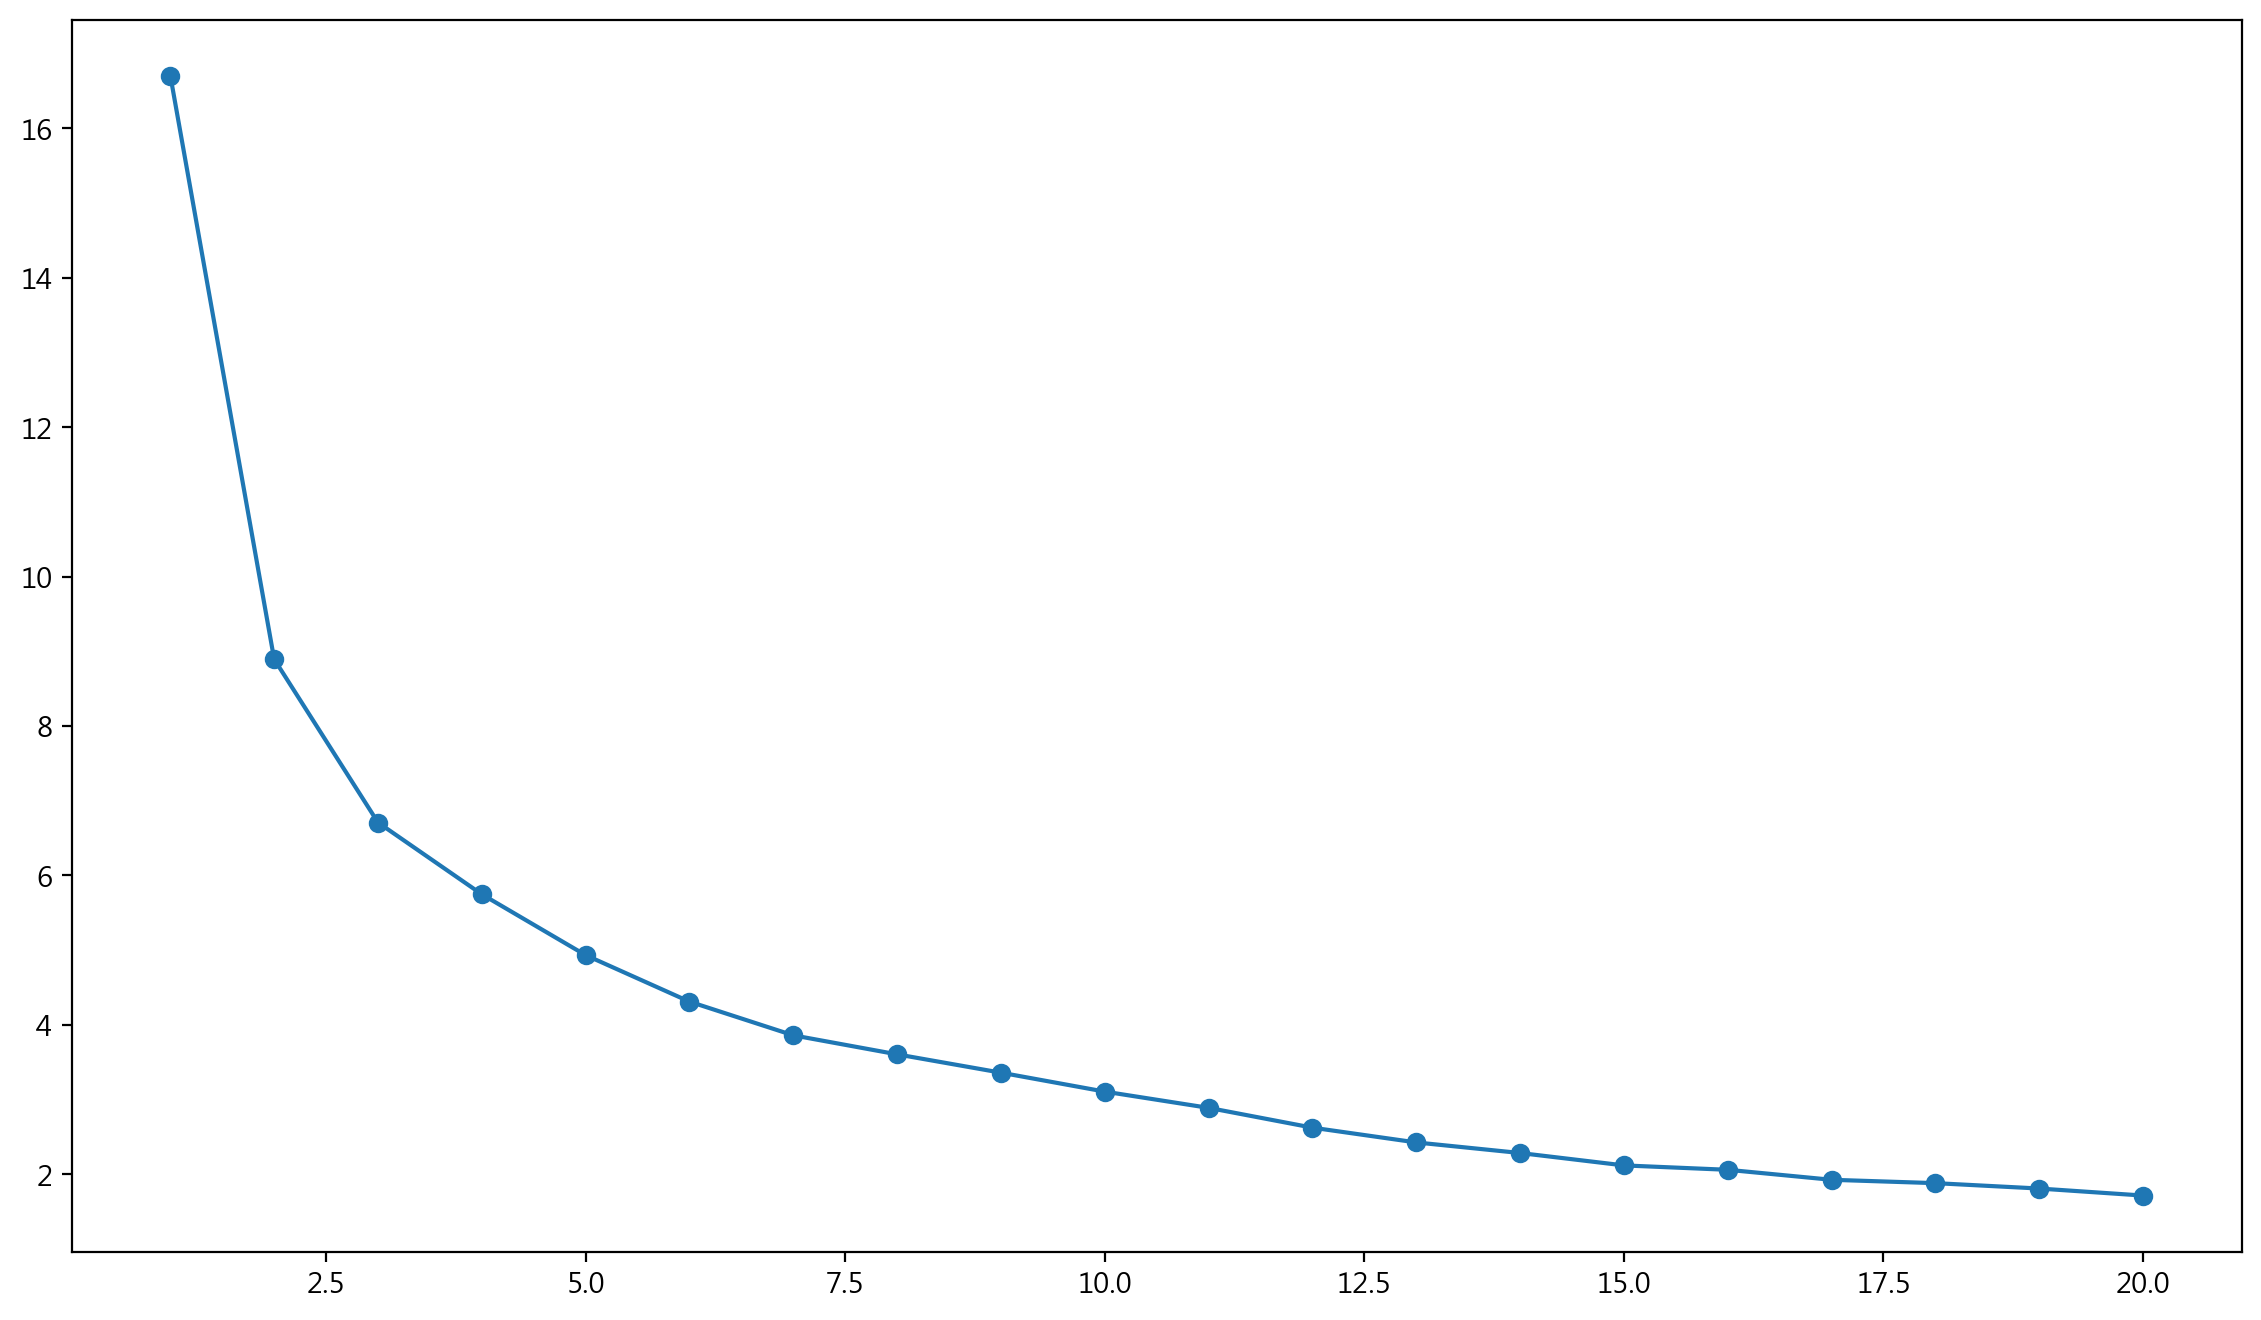

In [14]:
inbound_each_station_5yrs = np.loadtxt("inbound_each_station_5yrs.txt", delimiter=",")
inbound_each_station_5yrs = normalize(inbound_each_station_5yrs)
inbound_each_station_5yrs_t = inbound_encoder(inbound_each_station_5yrs)
inbound_each_station_5yrs_t = np.array(inbound_each_station_5yrs_t)

# 進行10次K-Means分群演算，並以elbow method求出最適分群數量
KMeans_models_IN = [KMeans(n_clusters=k).fit(inbound_each_station_5yrs_t) for k in range(1, 21)]
inertias = [model.inertia_ for model in KMeans_models_IN]
plt.figure(figsize=(14,8))
plt.plot(range(1, 21), inertias, marker="o")

In [15]:
# 由上圖，決定將進站趨勢分成 14 類，即 k=14
kmeans = KMeans_models_IN[13]

# 資料集: 2017-01 ~ 2022-01
dateRange = pd.date_range("2017-01-01", "2022-01-31")
hourList = [0] + [i for i in range(6, 24)]

cluster_labels = []
for date in dateRange:
    for hour in hourList:
        cluster_label = pd.DataFrame(kmeans.labels_, index=stationList)
        cluster_labels.append(cluster_label)
        
cluster_labels_df = pd.concat(cluster_labels[1:-1], axis=0)
dummy_cluster = pd.get_dummies(cluster_labels_df[0]).reset_index(drop=True)
dummy_cluster.to_csv("feature_AE_K14_IN.csv", index=False, header=False)

<a id="4.5"></a>
### 出站趨勢分類
接著根據出站趨勢進行分群。

將 outbound_each_station_5yrs.txt 的 array 進行 L2 Normalize 後，再投入訓練好的 Outbound Encoder 進行 Dimension Reduction。

D:\Users\63984\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


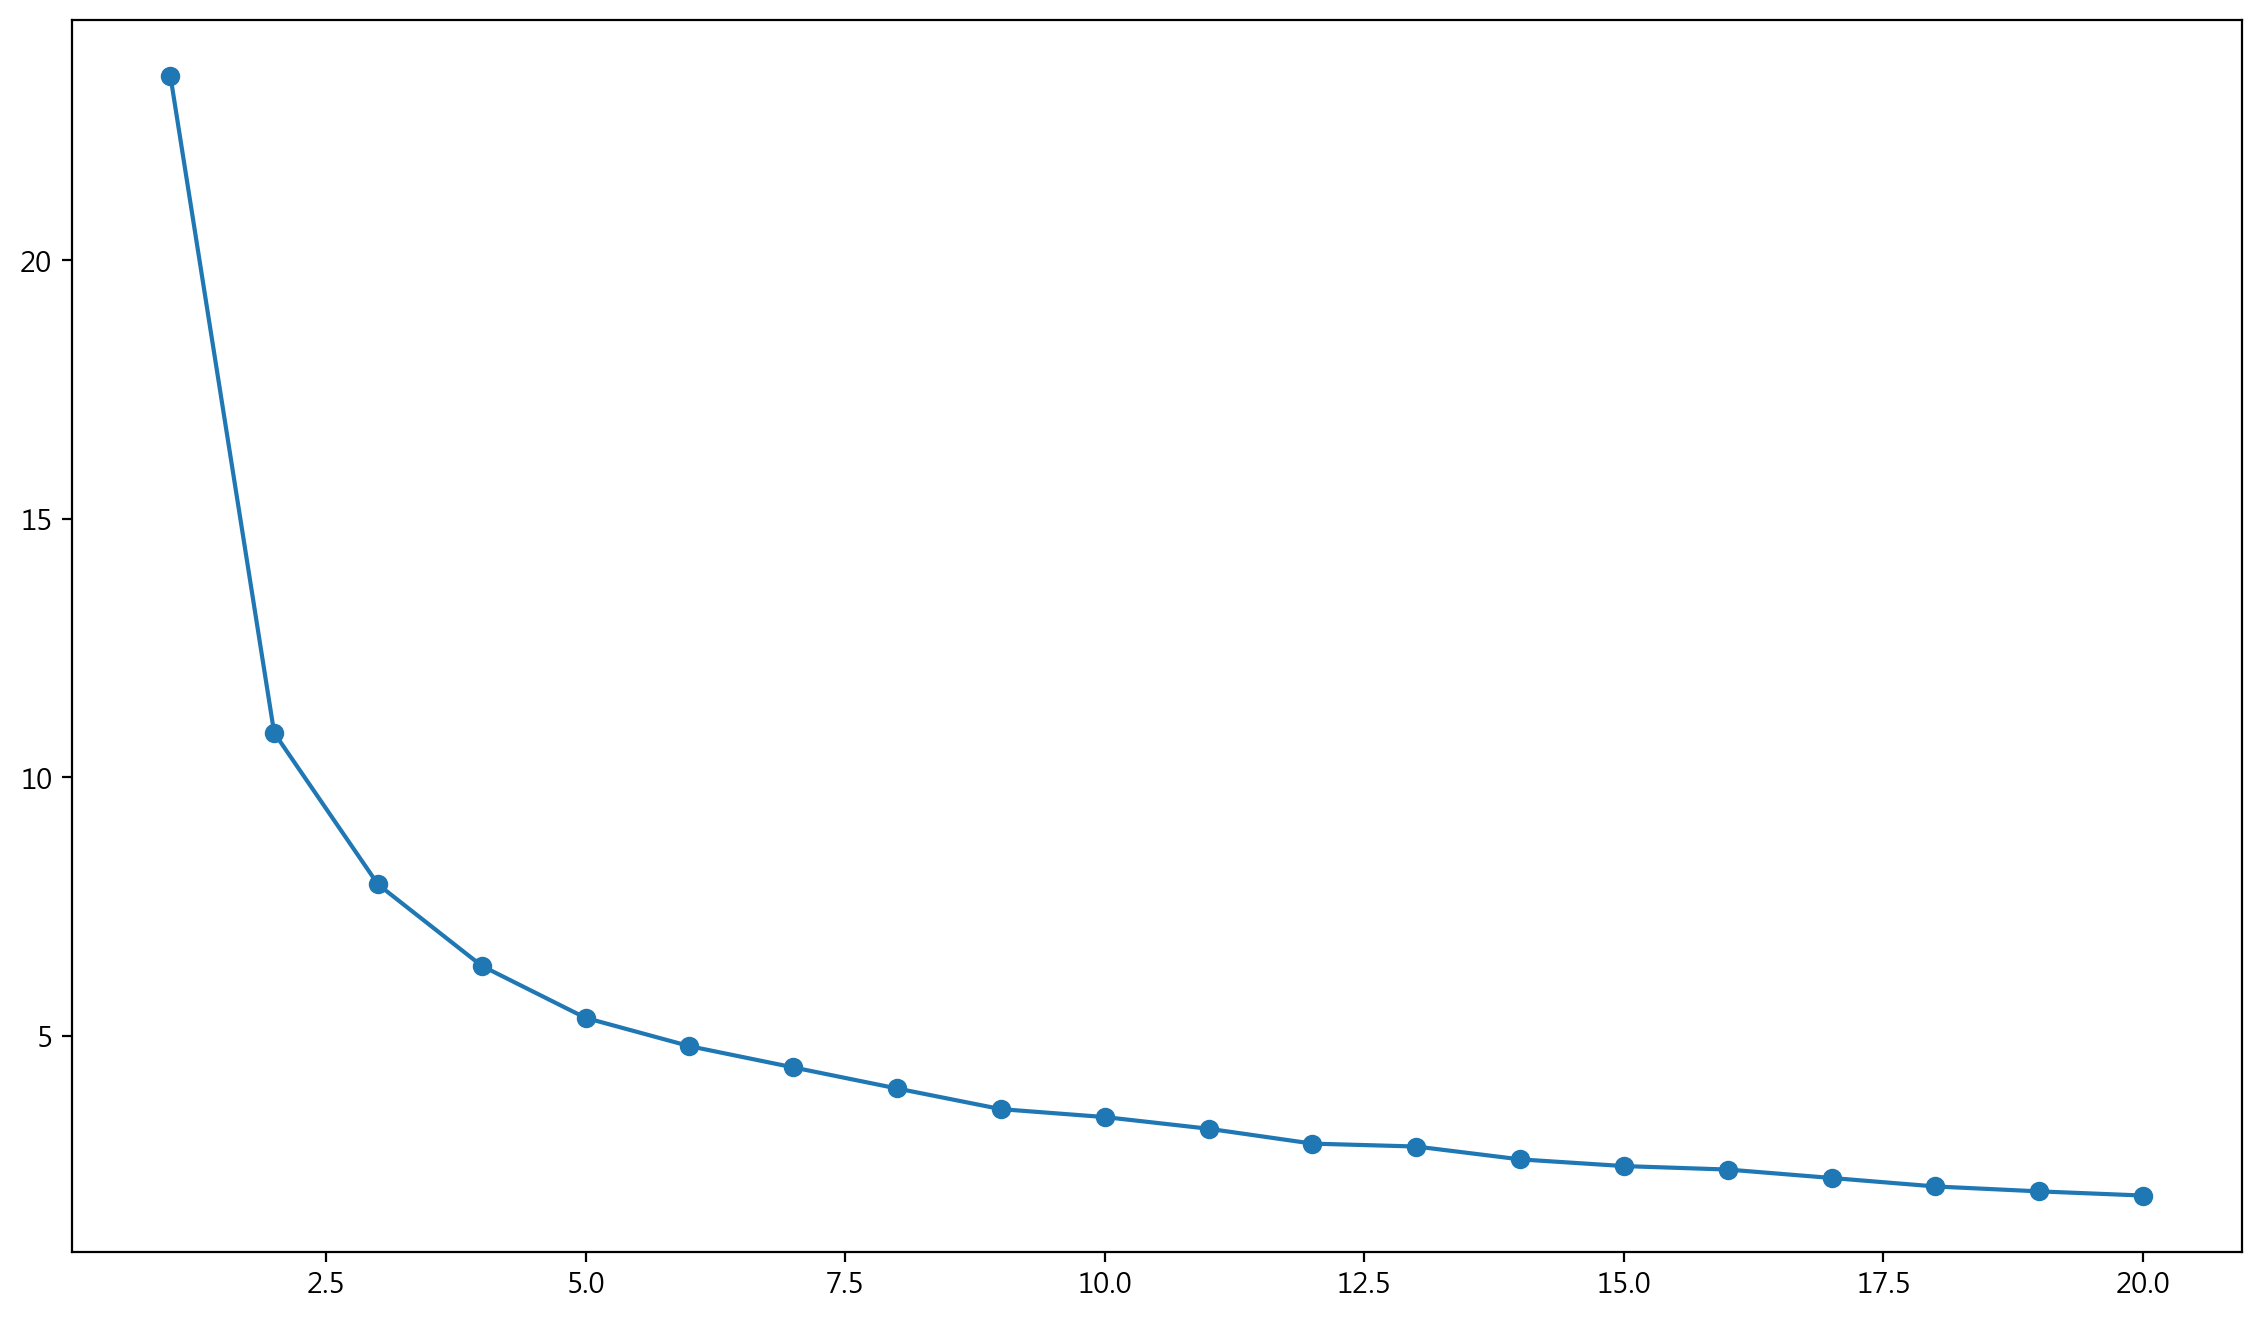

In [16]:
outbound_each_station_5yrs = np.loadtxt("outbound_each_station_5yrs.txt", delimiter=",")
outbound_each_station_5yrs = normalize(outbound_each_station_5yrs)
outbound_each_station_5yrs_t = outbound_encoder(outbound_each_station_5yrs)
outbound_each_station_5yrs_t = np.array(outbound_each_station_5yrs_t)

# 進行10次K-Means分群演算，並以elbow method求出最適分群數量
KMeans_models_OUT = [KMeans(n_clusters=k).fit(outbound_each_station_5yrs_t) for k in range(1, 21)]
inertias = [model.inertia_ for model in KMeans_models_OUT]
plt.figure(figsize=(14,8))
plt.plot(range(1, 21), inertias, marker="o")

In [17]:
# 由上圖，決定將進站趨勢分成 13 類，即 k=13
kmeans = KMeans_models_OUT[12]

# 資料集: 2017-01 ~ 2022-01
dateRange = pd.date_range("2017-01-01", "2022-01-31")
hourList = [0] + [i for i in range(6, 24)]

cluster_labels = []
for date in dateRange:
    for hour in hourList:
        cluster_label = pd.DataFrame(kmeans.labels_, index=stationList)
        cluster_labels.append(cluster_label)
        
cluster_labels_df = pd.concat(cluster_labels[1:-1], axis=0)
dummy_cluster = pd.get_dummies(cluster_labels_df[0]).reset_index(drop=True)
dummy_cluster.to_csv("feature_AE_K13_OUT.csv", index=False, header=False)

<a id="4.6"></a>
### 車站規模分類
此處根據進出站人數區分車站規模。首先計算各車站 5 年來進出站總人數，接著依據進出站總人數之第 10 百分位數、第 20 百分位數、...、第 90 百分位數，將車站規模分成 10 類。

In [18]:
inbound_each_station_5yrs = np.loadtxt("inbound_each_station_5yrs.txt", delimiter=",")
outbound_each_station_5yrs = np.loadtxt("outbound_each_station_5yrs.txt", delimiter=",")
stream_each_station_5yrs = inbound_each_station_5yrs + outbound_each_station_5yrs
total_stream_each_station_5yrs = stream_each_station_5yrs.sum(axis=1).astype(int)

total_stream_each_station_5yrs = pd.DataFrame(total_stream_each_station_5yrs, index=stationList)
describe = total_stream_each_station_5yrs.describe(percentiles=[i/10 for i in range(1, 11)]).astype({0:int})
describe

0
count        108
mean    65525335
std     59873451
min      7685612
10%     17075045
20%     29098914
30%     33465056
40%     41118994
50%     48157040
60%     66393804
70%     77244834
80%     95350945
90%    117924467
100%   509018432
max    509018432

In [19]:
scale_label = []
for i in range(total_stream_each_station_5yrs.shape[0]):
    if total_stream_each_station_5yrs[0].iloc[i] < describe.loc["10%"].item():
        scale_label.append(0)
    elif describe.loc["10%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["20%"].item():
        scale_label.append(1)
    elif describe.loc["20%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["30%"].item():
        scale_label.append(2)
    elif describe.loc["30%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["40%"].item():
        scale_label.append(3)
    elif describe.loc["40%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["50%"].item():
        scale_label.append(4)
    elif describe.loc["50%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["60%"].item():
        scale_label.append(5)
    elif describe.loc["60%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["70%"].item():
        scale_label.append(6)
    elif describe.loc["70%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["80%"].item():
        scale_label.append(7)
    elif describe.loc["80%"].item() <= total_stream_each_station_5yrs[0].iloc[i] < describe.loc["90%"].item():
        scale_label.append(8)
    elif total_stream_each_station_5yrs[0].iloc[i] >= describe.loc["90%"].item():
        scale_label.append(9)

In [20]:
# 資料集: 2017-01 ~ 2022-01
dateRange = pd.date_range("2017-01-01", "2022-01-31")
hourList = [0] + [i for i in range(6, 24)]

scale_labels = []
for date in dateRange:
    for hour in hourList:
        scale_label = pd.DataFrame(scale_label)
        scale_labels.append(scale_label)
        
scale_labels_df = pd.concat(scale_labels[1:-1], axis=0)
dummy_scale = pd.get_dummies(scale_labels_df[0]).reset_index(drop=True)
dummy_scale.to_csv("feature_scale.csv", index=False, header=False)
dummy_scale

0  1  2  3  4  5  6  7  8  9
0        0  0  0  0  0  0  0  0  0  1
1        0  0  0  0  0  1  0  0  0  0
2        0  0  0  1  0  0  0  0  0  0
3        0  0  0  1  0  0  0  0  0  0
4        0  1  0  0  0  0  0  0  0  0
...     .. .. .. .. .. .. .. .. .. ..
3810343  0  1  0  0  0  0  0  0  0  0
3810344  0  0  0  0  0  0  0  0  0  1
3810345  1  0  0  0  0  0  0  0  0  0
3810346  1  0  0  0  0  0  0  0  0  0
3810347  0  0  0  0  0  0  0  0  1  0

[3810348 rows x 10 columns]

<a id="4.7"></a>
### 日期型態分類
我們將日期型態分成工作日及非工作日兩類，非工作日的定義係參考行政院人事處公布的行政機關辦公日曆表。

__Reference:__
* 2017: https://www.dgpa.gov.tw/information?uid=2&pid=4293
* 2018: https://www.dgpa.gov.tw/information?uid=83&pid=7473
* 2019: https://www.dgpa.gov.tw/information?uid=83&pid=8150
* 2020: https://www.dgpa.gov.tw/information?uid=83&pid=9713
* 2021: https://www.dgpa.gov.tw/information?uid=83&pid=10173
* 2022: https://www.dgpa.gov.tw/information?uid=83&pid=10654

In [21]:
chinese_new_year = set()
chinese_new_year.update(pd.date_range("2017-01-27", "2017-02-01"))
chinese_new_year.update(pd.date_range("2018-02-15", "2018-02-20"))
chinese_new_year.update(pd.date_range("2019-02-02", "2019-02-10"))
chinese_new_year.update(pd.date_range("2020-01-23", "2020-01-29"))
chinese_new_year.update(pd.date_range("2021-02-10", "2021-02-16"))

holiday = set()
holiday.update(pd.date_range("2017-01-01", "2017-01-02"))  # 元旦
holiday.update(pd.date_range("2017-02-25", "2017-02-28"))  # 二二八
holiday.update(pd.date_range("2017-04-01", "2017-04-04"))  # 清明
holiday.update(pd.date_range("2017-05-27", "2017-05-30"))  # 端午
holiday.update(pd.date_range("2017-10-04", "2017-10-04"))  # 中秋
holiday.update(pd.date_range("2017-10-07", "2017-10-10"))  # 雙十

holiday.update(pd.date_range("2017-12-30", "2018-01-01"))  # 元旦
holiday.update(pd.date_range("2018-02-28", "2018-02-28"))  # 二二八
holiday.update(pd.date_range("2018-04-04", "2018-04-08"))  # 清明
holiday.update(pd.date_range("2018-06-16", "2018-06-18"))  # 端午
holiday.update(pd.date_range("2018-09-22", "2018-09-24"))  # 中秋
holiday.update(pd.date_range("2018-10-10", "2018-10-10"))  # 雙十

holiday.update(pd.date_range("2018-12-29", "2019-01-01"))  # 元旦
holiday.update(pd.date_range("2019-02-28", "2019-03-03"))  # 二二八
holiday.update(pd.date_range("2019-04-04", "2019-04-07"))  # 清明
holiday.update(pd.date_range("2019-06-07", "2019-06-09"))  # 端午
holiday.update(pd.date_range("2019-09-13", "2019-09-15"))  # 中秋
holiday.update(pd.date_range("2019-10-10", "2019-10-13"))  # 雙十

holiday.update(pd.date_range("2020-01-01", "2020-01-01"))  # 元旦
holiday.update(pd.date_range("2020-02-28", "2020-03-01"))  # 二二八
holiday.update(pd.date_range("2020-04-02", "2020-04-05"))  # 清明
holiday.update(pd.date_range("2020-06-25", "2020-06-28"))  # 端午
holiday.update(pd.date_range("2020-10-01", "2020-10-04"))  # 中秋
holiday.update(pd.date_range("2020-10-09", "2020-10-11"))  # 雙十

holiday.update(pd.date_range("2021-01-01", "2021-01-03"))  # 元旦
holiday.update(pd.date_range("2021-02-27", "2021-03-01"))  # 二二八
holiday.update(pd.date_range("2021-04-02", "2021-04-05"))  # 清明
# holiday.update(pd.date_range("2021-06-12", "2021-06-14"))  # 端午(三級警戒期間不考慮)
holiday.update(pd.date_range("2021-09-18", "2021-09-21"))  # 中秋
holiday.update(pd.date_range("2021-10-09", "2021-10-11"))  # 雙十

workday = set()
non_workday = set()

#==========================================================================================================================
# 加入補班日
#==========================================================================================================================
workday.update(pd.date_range("2017-02-18", "2017-02-18"))
workday.update(pd.date_range("2017-06-03", "2017-06-03"))
workday.update(pd.date_range("2017-09-30", "2017-09-30"))

workday.update(pd.date_range("2018-03-31", "2018-03-31"))
workday.update(pd.date_range("2018-12-22", "2018-12-22"))

workday.update(pd.date_range("2019-01-19", "2019-01-19"))
workday.update(pd.date_range("2019-02-23", "2019-02-23"))
workday.update(pd.date_range("2019-10-05", "2019-10-05"))

workday.update(pd.date_range("2020-02-15", "2020-02-15"))
workday.update(pd.date_range("2020-06-20", "2020-06-20"))
workday.update(pd.date_range("2020-09-26", "2020-09-26"))

workday.update(pd.date_range("2021-02-20", "2021-02-20"))
workday.update(pd.date_range("2021-09-11", "2021-09-11"))

period = set(pd.date_range("2017-01-01", "2022-01-31"))
non_workday.update(chinese_new_year)
non_workday.update(holiday)
for date in list(period):
    if date not in chinese_new_year:
        if date not in holiday:
            if date.isoweekday() > 5:
                if date not in workday:
                    non_workday.update(pd.date_range(date, date))
                
workday = period - non_workday

<a id="4.8"></a>
### 其餘特徵提取、生成預測模型訓練資料集
最後，有些特徵必須將原始 Open Data 讀進來後，才能提取或生成我們所需要的特徵，如日期型態、時段、分時進出站人數等。

此處讀取原始 Open Data 提取並生成我們需要的特徵資料後，最終產生一份後續預測模型所需的訓練資料集。

In [22]:
dateRange = pd.date_range("2017-01-01", "2022-01-31")
hourList = [0] + [i for i in range(6, 24)]

datetype_data = []
hour_data = []
in_out_data = []
for date in dateRange:
    df = pd.read_csv(f"opendata/{str(date.year)}{int(date.month):02d}.csv", encoding="utf_8_sig", parse_dates=["日期"])
    df, stationList = filt(df)
    for hour in hourList:
        df_ = df.loc[(df["日期"] == date) & (df["時段"] == hour)].reset_index(drop=True)
        df_IN = df_.groupby(["進站"]).agg({"人次": sum})
        df_OUT = df_.groupby(["出站"]).agg({"人次": sum})
        one_hour_data = pd.concat([df_IN, df_OUT], axis=1)
        
        df_HOUR = df_.groupby(["進站"]).agg({"時段": np.mean}).astype({"時段": "int64"})
        
        if date in workday:
            df_WORKDAY = pd.DataFrame(np.array([1 for i in range(len(df_IN))]))
        else:
            df_WORKDAY = pd.DataFrame(np.array([0 for i in range(len(df_IN))]))
            
        datetype_data.append(df_WORKDAY)
        hour_data.append(df_HOUR)
        in_out_data.append(one_hour_data)
        
datetype_data_df = pd.concat(datetype_data[1:-1], axis=0)
hour_data_df = pd.concat(hour_data[1:-1], axis=0)
in_out_data_df = pd.concat(in_out_data[1:-1], axis=0)

labels = pd.concat(in_out_data[2:], axis=0)
stream_data = pd.concat([in_out_data_df, labels], axis=1).reset_index(drop=True)


#==========================================================================================================================
# 將各個特徵資料分別儲存成 .csv
#==========================================================================================================================
dummy_datetype = pd.get_dummies(datetype_data_df[0]).reset_index(drop=True)
dummy_datetype.to_csv("feature_datetype.csv", index=False, header=False)

dummy_hour = pd.get_dummies(hour_data_df["時段"]).reset_index(drop=True)
dummy_hour.to_csv("feature_hour.csv", index=False, header=False)

stream_data.to_csv("feature_stream.csv", index=False, header=False)


#==========================================================================================================================
# 生成預測模型所需訓練資料集，並儲存成 .csv
#==========================================================================================================================
datetype = pd.read_csv("feature_datetype.csv", header=None)
hour = pd.read_csv("feature_hour.csv", header=None)
cluster_IN = pd.read_csv("feature_AE_K14_IN.csv", header=None)
cluster_OUT = pd.read_csv("feature_AE_K13_OUT.csv", header=None)
scale = pd.read_csv("feature_scale.csv", header=None)
stream = pd.read_csv("feature_stream.csv", header=None)

all_data = pd.concat([datetype, hour, cluster_IN, cluster_OUT, scale, stream], axis=1)
all_data.to_csv("dataset.csv", index=False, header=False)

<a id="5"></a>
## 5. 建立預測即時進出站人流模型
***
* __[切分資料集](#5.1)__
* __[預測模型訓練](#5.2)__
* __[檢視模型訓練績效](#5.3)__

<a id="5.1"></a>
### 切分資料集
我們將資料集切分成訓練資料集、驗證資料集、測試資料集，比例為 8:1:1。

In [23]:
all_data = pd.read_csv("dataset.csv", header=None)
X = all_data.iloc[:,:-2]
Y = all_data.iloc[:,-2:]

# train : valid : test = 8 : 1 : 1
train_X, rem_X, train_Y, rem_Y = train_test_split(X, Y, random_state=42, train_size=0.8)
valid_X, test_X, valid_Y, test_Y = train_test_split(rem_X, rem_Y, random_state=42, test_size=0.5)

<a id="5.2"></a>
### 預測模型訓練
我們使用 XGBoost Regression 預測即時進出站人流，輸出為下一小時捷運車站進站人數和出站人數。

In [24]:
xgb.set_config(verbosity=2)

model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=20000,
    booster="gbtree",
    max_depth=6,
    min_child_weight=5,
    tree_method="gpu_hist",
    objective="reg:squarederror",
    eval_metric="rmse"
)
model.fit(
    train_X, train_Y,
    eval_set=[(train_X, train_Y), (valid_X, valid_Y)],
    early_stopping_rounds=200
)

D:\Users\63984\Anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1406.84140	validation_1-rmse:1412.76588
[1]	validation_0-rmse:1279.89119	validation_1-rmse:1284.92081
[2]	validation_0-rmse:1165.71843	validation_1-rmse:1170.18534
[3]	validation_0-rmse:1064.26929	validation_1-rmse:1067.95761
[4]	validation_0-rmse:973.47704	validation_1-rmse:976.48558
[5]	validation_0-rmse:892.19780	validation_1-rmse:894.68913
[6]	validation_0-rmse:819.79174	validation_1-rmse:821.75732
[7]	validation_0-rmse:755.08417	validation_1-rmse:756.54058
[8]	validation_0-rmse:698.06568	validation_1-rmse:699.06154
[9]	validation_0-rmse:647.07980	validation_1-rmse:647.81444
[10]	validation_0-rmse:602.32851	validation_1-rmse:602.66133
[11]	validation_0-rmse:562.59873	validation_1-rmse:562.61469
[12]	validation_0-rmse:526.72622	validation_1-rmse:526.50343
[13]	validation_0-rmse:495.82408	validation_1-rmse:495.33692
[14]	validation_0-rmse:468.04161	validation_1-rmse:467.39726
[15]	validation_0-rmse:443.33926	validation_1-rmse:442.69592
[16]	validation_0-rmse:421

[134]	validation_0-rmse:198.58263	validation_1-rmse:198.80907
[135]	validation_0-rmse:198.23155	validation_1-rmse:198.46896
[136]	validation_0-rmse:197.97471	validation_1-rmse:198.21526
[137]	validation_0-rmse:197.72698	validation_1-rmse:197.97602
[138]	validation_0-rmse:197.50019	validation_1-rmse:197.73580
[139]	validation_0-rmse:197.07015	validation_1-rmse:197.31933
[140]	validation_0-rmse:196.78094	validation_1-rmse:197.04269
[141]	validation_0-rmse:196.53661	validation_1-rmse:196.78986
[142]	validation_0-rmse:196.25339	validation_1-rmse:196.52601
[143]	validation_0-rmse:195.99659	validation_1-rmse:196.28509
[144]	validation_0-rmse:195.88080	validation_1-rmse:196.17223
[145]	validation_0-rmse:195.69945	validation_1-rmse:195.99863
[146]	validation_0-rmse:195.58782	validation_1-rmse:195.89785
[147]	validation_0-rmse:195.27346	validation_1-rmse:195.60467
[148]	validation_0-rmse:194.92686	validation_1-rmse:195.24922
[149]	validation_0-rmse:194.67617	validation_1-rmse:195.00544
[150]	va

[267]	validation_0-rmse:177.32737	validation_1-rmse:178.27693
[268]	validation_0-rmse:177.23800	validation_1-rmse:178.18946
[269]	validation_0-rmse:177.11634	validation_1-rmse:178.06396
[270]	validation_0-rmse:177.04141	validation_1-rmse:178.00181
[271]	validation_0-rmse:176.96835	validation_1-rmse:177.93398
[272]	validation_0-rmse:176.85213	validation_1-rmse:177.81290
[273]	validation_0-rmse:176.78468	validation_1-rmse:177.75057
[274]	validation_0-rmse:176.70610	validation_1-rmse:177.67175
[275]	validation_0-rmse:176.65127	validation_1-rmse:177.62145
[276]	validation_0-rmse:176.50037	validation_1-rmse:177.48033
[277]	validation_0-rmse:176.42976	validation_1-rmse:177.40845
[278]	validation_0-rmse:176.36040	validation_1-rmse:177.34301
[279]	validation_0-rmse:176.25957	validation_1-rmse:177.24115
[280]	validation_0-rmse:176.15802	validation_1-rmse:177.14630
[281]	validation_0-rmse:176.11019	validation_1-rmse:177.09958
[282]	validation_0-rmse:176.00701	validation_1-rmse:176.99648
[283]	va

[400]	validation_0-rmse:169.23586	validation_1-rmse:170.57448
[401]	validation_0-rmse:169.21655	validation_1-rmse:170.55635
[402]	validation_0-rmse:169.16954	validation_1-rmse:170.51421
[403]	validation_0-rmse:169.13342	validation_1-rmse:170.48482
[404]	validation_0-rmse:169.09739	validation_1-rmse:170.45275
[405]	validation_0-rmse:169.05265	validation_1-rmse:170.40613
[406]	validation_0-rmse:169.02614	validation_1-rmse:170.38085
[407]	validation_0-rmse:169.00982	validation_1-rmse:170.36341
[408]	validation_0-rmse:168.98311	validation_1-rmse:170.34043
[409]	validation_0-rmse:168.94187	validation_1-rmse:170.29840
[410]	validation_0-rmse:168.89974	validation_1-rmse:170.26023
[411]	validation_0-rmse:168.88262	validation_1-rmse:170.24598
[412]	validation_0-rmse:168.83560	validation_1-rmse:170.20271
[413]	validation_0-rmse:168.80412	validation_1-rmse:170.17290
[414]	validation_0-rmse:168.76559	validation_1-rmse:170.13508
[415]	validation_0-rmse:168.70841	validation_1-rmse:170.08069
[416]	va

[533]	validation_0-rmse:164.95728	validation_1-rmse:166.55989
[534]	validation_0-rmse:164.92330	validation_1-rmse:166.53066
[535]	validation_0-rmse:164.90753	validation_1-rmse:166.51513
[536]	validation_0-rmse:164.89343	validation_1-rmse:166.50147
[537]	validation_0-rmse:164.87395	validation_1-rmse:166.48463
[538]	validation_0-rmse:164.86316	validation_1-rmse:166.47503
[539]	validation_0-rmse:164.82995	validation_1-rmse:166.43988
[540]	validation_0-rmse:164.80610	validation_1-rmse:166.42114
[541]	validation_0-rmse:164.78349	validation_1-rmse:166.39761
[542]	validation_0-rmse:164.76771	validation_1-rmse:166.38241
[543]	validation_0-rmse:164.74769	validation_1-rmse:166.36297
[544]	validation_0-rmse:164.72217	validation_1-rmse:166.33584
[545]	validation_0-rmse:164.70056	validation_1-rmse:166.31562
[546]	validation_0-rmse:164.65512	validation_1-rmse:166.27371
[547]	validation_0-rmse:164.61001	validation_1-rmse:166.22994
[548]	validation_0-rmse:164.58629	validation_1-rmse:166.20812
[549]	va

[666]	validation_0-rmse:162.00235	validation_1-rmse:163.91329
[667]	validation_0-rmse:161.98976	validation_1-rmse:163.90058
[668]	validation_0-rmse:161.97737	validation_1-rmse:163.89025
[669]	validation_0-rmse:161.95746	validation_1-rmse:163.86821
[670]	validation_0-rmse:161.94728	validation_1-rmse:163.85765
[671]	validation_0-rmse:161.91815	validation_1-rmse:163.83099
[672]	validation_0-rmse:161.89933	validation_1-rmse:163.81554
[673]	validation_0-rmse:161.88147	validation_1-rmse:163.80000
[674]	validation_0-rmse:161.85254	validation_1-rmse:163.77293
[675]	validation_0-rmse:161.81730	validation_1-rmse:163.74136
[676]	validation_0-rmse:161.79557	validation_1-rmse:163.72049
[677]	validation_0-rmse:161.77096	validation_1-rmse:163.69898
[678]	validation_0-rmse:161.75409	validation_1-rmse:163.68327
[679]	validation_0-rmse:161.72348	validation_1-rmse:163.65306
[680]	validation_0-rmse:161.70814	validation_1-rmse:163.63717
[681]	validation_0-rmse:161.68928	validation_1-rmse:163.62009
[682]	va

[799]	validation_0-rmse:159.85129	validation_1-rmse:162.01675
[800]	validation_0-rmse:159.82495	validation_1-rmse:161.99202
[801]	validation_0-rmse:159.80738	validation_1-rmse:161.97425
[802]	validation_0-rmse:159.78474	validation_1-rmse:161.95722
[803]	validation_0-rmse:159.76948	validation_1-rmse:161.94418
[804]	validation_0-rmse:159.75734	validation_1-rmse:161.93504
[805]	validation_0-rmse:159.74563	validation_1-rmse:161.92491
[806]	validation_0-rmse:159.72440	validation_1-rmse:161.90593
[807]	validation_0-rmse:159.71356	validation_1-rmse:161.89548
[808]	validation_0-rmse:159.69934	validation_1-rmse:161.88268
[809]	validation_0-rmse:159.68335	validation_1-rmse:161.87108
[810]	validation_0-rmse:159.67109	validation_1-rmse:161.86009
[811]	validation_0-rmse:159.65788	validation_1-rmse:161.84893
[812]	validation_0-rmse:159.64713	validation_1-rmse:161.83818
[813]	validation_0-rmse:159.62697	validation_1-rmse:161.81924
[814]	validation_0-rmse:159.61472	validation_1-rmse:161.80573
[815]	va

[932]	validation_0-rmse:158.06091	validation_1-rmse:160.43315
[933]	validation_0-rmse:158.05463	validation_1-rmse:160.42673
[934]	validation_0-rmse:158.04307	validation_1-rmse:160.41534
[935]	validation_0-rmse:158.03417	validation_1-rmse:160.40889
[936]	validation_0-rmse:158.02189	validation_1-rmse:160.39941
[937]	validation_0-rmse:158.01695	validation_1-rmse:160.39559
[938]	validation_0-rmse:157.99985	validation_1-rmse:160.38096
[939]	validation_0-rmse:157.99142	validation_1-rmse:160.37291
[940]	validation_0-rmse:157.98054	validation_1-rmse:160.36242
[941]	validation_0-rmse:157.97771	validation_1-rmse:160.35936
[942]	validation_0-rmse:157.96571	validation_1-rmse:160.35149
[943]	validation_0-rmse:157.94988	validation_1-rmse:160.33557
[944]	validation_0-rmse:157.94029	validation_1-rmse:160.32888
[945]	validation_0-rmse:157.93204	validation_1-rmse:160.32220
[946]	validation_0-rmse:157.92880	validation_1-rmse:160.31922
[947]	validation_0-rmse:157.92189	validation_1-rmse:160.31471
[948]	va

[1064]	validation_0-rmse:156.71848	validation_1-rmse:159.29436
[1065]	validation_0-rmse:156.70204	validation_1-rmse:159.28128
[1066]	validation_0-rmse:156.69479	validation_1-rmse:159.27586
[1067]	validation_0-rmse:156.68139	validation_1-rmse:159.26871
[1068]	validation_0-rmse:156.67363	validation_1-rmse:159.26179
[1069]	validation_0-rmse:156.66129	validation_1-rmse:159.25093
[1070]	validation_0-rmse:156.65212	validation_1-rmse:159.24419
[1071]	validation_0-rmse:156.64065	validation_1-rmse:159.23566
[1072]	validation_0-rmse:156.63473	validation_1-rmse:159.22979
[1073]	validation_0-rmse:156.62658	validation_1-rmse:159.22249
[1074]	validation_0-rmse:156.61861	validation_1-rmse:159.21714
[1075]	validation_0-rmse:156.60915	validation_1-rmse:159.21287
[1076]	validation_0-rmse:156.59979	validation_1-rmse:159.20422
[1077]	validation_0-rmse:156.58962	validation_1-rmse:159.19546
[1078]	validation_0-rmse:156.58358	validation_1-rmse:159.18968
[1079]	validation_0-rmse:156.57605	validation_1-rmse:15

[1195]	validation_0-rmse:155.66118	validation_1-rmse:158.42483
[1196]	validation_0-rmse:155.65467	validation_1-rmse:158.42251
[1197]	validation_0-rmse:155.64430	validation_1-rmse:158.41265
[1198]	validation_0-rmse:155.63865	validation_1-rmse:158.40836
[1199]	validation_0-rmse:155.63410	validation_1-rmse:158.40407
[1200]	validation_0-rmse:155.62738	validation_1-rmse:158.39821
[1201]	validation_0-rmse:155.61570	validation_1-rmse:158.38780
[1202]	validation_0-rmse:155.60757	validation_1-rmse:158.38092
[1203]	validation_0-rmse:155.59845	validation_1-rmse:158.37918
[1204]	validation_0-rmse:155.59417	validation_1-rmse:158.37577
[1205]	validation_0-rmse:155.58802	validation_1-rmse:158.37255
[1206]	validation_0-rmse:155.58261	validation_1-rmse:158.36830
[1207]	validation_0-rmse:155.57847	validation_1-rmse:158.36565
[1208]	validation_0-rmse:155.57341	validation_1-rmse:158.36406
[1209]	validation_0-rmse:155.56504	validation_1-rmse:158.35761
[1210]	validation_0-rmse:155.55314	validation_1-rmse:15

[1326]	validation_0-rmse:154.71859	validation_1-rmse:157.69953
[1327]	validation_0-rmse:154.71302	validation_1-rmse:157.69433
[1328]	validation_0-rmse:154.70749	validation_1-rmse:157.69119
[1329]	validation_0-rmse:154.69902	validation_1-rmse:157.68821
[1330]	validation_0-rmse:154.68517	validation_1-rmse:157.67458
[1331]	validation_0-rmse:154.67640	validation_1-rmse:157.66645
[1332]	validation_0-rmse:154.66539	validation_1-rmse:157.65618
[1333]	validation_0-rmse:154.65951	validation_1-rmse:157.65186
[1334]	validation_0-rmse:154.65429	validation_1-rmse:157.64674
[1335]	validation_0-rmse:154.64357	validation_1-rmse:157.63607
[1336]	validation_0-rmse:154.63654	validation_1-rmse:157.62997
[1337]	validation_0-rmse:154.63015	validation_1-rmse:157.62325
[1338]	validation_0-rmse:154.62480	validation_1-rmse:157.61776
[1339]	validation_0-rmse:154.61979	validation_1-rmse:157.61186
[1340]	validation_0-rmse:154.60927	validation_1-rmse:157.60193
[1341]	validation_0-rmse:154.60360	validation_1-rmse:15

[1457]	validation_0-rmse:153.88994	validation_1-rmse:157.05177
[1458]	validation_0-rmse:153.88412	validation_1-rmse:157.04722
[1459]	validation_0-rmse:153.87836	validation_1-rmse:157.04315
[1460]	validation_0-rmse:153.86944	validation_1-rmse:157.03337
[1461]	validation_0-rmse:153.86086	validation_1-rmse:157.02739
[1462]	validation_0-rmse:153.85096	validation_1-rmse:157.01953
[1463]	validation_0-rmse:153.84320	validation_1-rmse:157.01298
[1464]	validation_0-rmse:153.83771	validation_1-rmse:157.00748
[1465]	validation_0-rmse:153.83346	validation_1-rmse:157.00492
[1466]	validation_0-rmse:153.82993	validation_1-rmse:157.00132
[1467]	validation_0-rmse:153.82324	validation_1-rmse:156.99692
[1468]	validation_0-rmse:153.81189	validation_1-rmse:156.98702
[1469]	validation_0-rmse:153.80743	validation_1-rmse:156.98437
[1470]	validation_0-rmse:153.80095	validation_1-rmse:156.97869
[1471]	validation_0-rmse:153.79788	validation_1-rmse:156.97723
[1472]	validation_0-rmse:153.79010	validation_1-rmse:15

[1588]	validation_0-rmse:153.11546	validation_1-rmse:156.46375
[1589]	validation_0-rmse:153.10826	validation_1-rmse:156.45717
[1590]	validation_0-rmse:153.10537	validation_1-rmse:156.45499
[1591]	validation_0-rmse:153.09864	validation_1-rmse:156.44867
[1592]	validation_0-rmse:153.09568	validation_1-rmse:156.44691
[1593]	validation_0-rmse:153.09243	validation_1-rmse:156.44495
[1594]	validation_0-rmse:153.08990	validation_1-rmse:156.44289
[1595]	validation_0-rmse:153.08630	validation_1-rmse:156.43869
[1596]	validation_0-rmse:153.08271	validation_1-rmse:156.43525
[1597]	validation_0-rmse:153.07650	validation_1-rmse:156.43103
[1598]	validation_0-rmse:153.06999	validation_1-rmse:156.42724
[1599]	validation_0-rmse:153.06651	validation_1-rmse:156.42522
[1600]	validation_0-rmse:153.06196	validation_1-rmse:156.42170
[1601]	validation_0-rmse:153.05831	validation_1-rmse:156.41895
[1602]	validation_0-rmse:153.05224	validation_1-rmse:156.41365
[1603]	validation_0-rmse:153.04645	validation_1-rmse:15

[1719]	validation_0-rmse:152.45969	validation_1-rmse:155.95309
[1720]	validation_0-rmse:152.45574	validation_1-rmse:155.95128
[1721]	validation_0-rmse:152.44830	validation_1-rmse:155.94491
[1722]	validation_0-rmse:152.44283	validation_1-rmse:155.94114
[1723]	validation_0-rmse:152.43464	validation_1-rmse:155.93456
[1724]	validation_0-rmse:152.42623	validation_1-rmse:155.92897
[1725]	validation_0-rmse:152.42050	validation_1-rmse:155.92661
[1726]	validation_0-rmse:152.41471	validation_1-rmse:155.92157
[1727]	validation_0-rmse:152.41034	validation_1-rmse:155.91794
[1728]	validation_0-rmse:152.40492	validation_1-rmse:155.91451
[1729]	validation_0-rmse:152.40153	validation_1-rmse:155.91027
[1730]	validation_0-rmse:152.39780	validation_1-rmse:155.90794
[1731]	validation_0-rmse:152.39575	validation_1-rmse:155.90751
[1732]	validation_0-rmse:152.38845	validation_1-rmse:155.90078
[1733]	validation_0-rmse:152.38480	validation_1-rmse:155.89765
[1734]	validation_0-rmse:152.38204	validation_1-rmse:15

[1850]	validation_0-rmse:151.83897	validation_1-rmse:155.50582
[1851]	validation_0-rmse:151.83398	validation_1-rmse:155.50403
[1852]	validation_0-rmse:151.82919	validation_1-rmse:155.50058
[1853]	validation_0-rmse:151.82255	validation_1-rmse:155.49641
[1854]	validation_0-rmse:151.81576	validation_1-rmse:155.49073
[1855]	validation_0-rmse:151.81186	validation_1-rmse:155.48643
[1856]	validation_0-rmse:151.80086	validation_1-rmse:155.48042
[1857]	validation_0-rmse:151.79650	validation_1-rmse:155.47797
[1858]	validation_0-rmse:151.79254	validation_1-rmse:155.47582
[1859]	validation_0-rmse:151.78714	validation_1-rmse:155.47249
[1860]	validation_0-rmse:151.78320	validation_1-rmse:155.46944
[1861]	validation_0-rmse:151.78002	validation_1-rmse:155.46673
[1862]	validation_0-rmse:151.77725	validation_1-rmse:155.46492
[1863]	validation_0-rmse:151.77405	validation_1-rmse:155.46469
[1864]	validation_0-rmse:151.76861	validation_1-rmse:155.46152
[1865]	validation_0-rmse:151.76237	validation_1-rmse:15

[1981]	validation_0-rmse:151.32469	validation_1-rmse:155.12984
[1982]	validation_0-rmse:151.31897	validation_1-rmse:155.12339
[1983]	validation_0-rmse:151.31539	validation_1-rmse:155.11999
[1984]	validation_0-rmse:151.30860	validation_1-rmse:155.11896
[1985]	validation_0-rmse:151.30377	validation_1-rmse:155.11529
[1986]	validation_0-rmse:151.29753	validation_1-rmse:155.11024
[1987]	validation_0-rmse:151.29208	validation_1-rmse:155.10601
[1988]	validation_0-rmse:151.28978	validation_1-rmse:155.10465
[1989]	validation_0-rmse:151.28469	validation_1-rmse:155.10035
[1990]	validation_0-rmse:151.28063	validation_1-rmse:155.09667
[1991]	validation_0-rmse:151.27688	validation_1-rmse:155.09406
[1992]	validation_0-rmse:151.27085	validation_1-rmse:155.08796
[1993]	validation_0-rmse:151.26726	validation_1-rmse:155.08350
[1994]	validation_0-rmse:151.26595	validation_1-rmse:155.08266
[1995]	validation_0-rmse:151.26388	validation_1-rmse:155.08038
[1996]	validation_0-rmse:151.26074	validation_1-rmse:15

[2112]	validation_0-rmse:150.85253	validation_1-rmse:154.78096
[2113]	validation_0-rmse:150.84817	validation_1-rmse:154.77811
[2114]	validation_0-rmse:150.84529	validation_1-rmse:154.77587
[2115]	validation_0-rmse:150.84222	validation_1-rmse:154.77548
[2116]	validation_0-rmse:150.84021	validation_1-rmse:154.77374
[2117]	validation_0-rmse:150.83681	validation_1-rmse:154.77151
[2118]	validation_0-rmse:150.83347	validation_1-rmse:154.76830
[2119]	validation_0-rmse:150.82946	validation_1-rmse:154.76478
[2120]	validation_0-rmse:150.82576	validation_1-rmse:154.76126
[2121]	validation_0-rmse:150.82038	validation_1-rmse:154.75962
[2122]	validation_0-rmse:150.81746	validation_1-rmse:154.75783
[2123]	validation_0-rmse:150.81431	validation_1-rmse:154.75716
[2124]	validation_0-rmse:150.80876	validation_1-rmse:154.75228
[2125]	validation_0-rmse:150.80653	validation_1-rmse:154.75174
[2126]	validation_0-rmse:150.80440	validation_1-rmse:154.75027
[2127]	validation_0-rmse:150.80005	validation_1-rmse:15

[2243]	validation_0-rmse:150.41950	validation_1-rmse:154.49802
[2244]	validation_0-rmse:150.41272	validation_1-rmse:154.49164
[2245]	validation_0-rmse:150.41066	validation_1-rmse:154.49042
[2246]	validation_0-rmse:150.40892	validation_1-rmse:154.49012
[2247]	validation_0-rmse:150.40634	validation_1-rmse:154.48915
[2248]	validation_0-rmse:150.40321	validation_1-rmse:154.48765
[2249]	validation_0-rmse:150.40126	validation_1-rmse:154.48522
[2250]	validation_0-rmse:150.39555	validation_1-rmse:154.48059
[2251]	validation_0-rmse:150.39346	validation_1-rmse:154.47942
[2252]	validation_0-rmse:150.38871	validation_1-rmse:154.48247
[2253]	validation_0-rmse:150.38565	validation_1-rmse:154.47992
[2254]	validation_0-rmse:150.38310	validation_1-rmse:154.47645
[2255]	validation_0-rmse:150.38058	validation_1-rmse:154.47439
[2256]	validation_0-rmse:150.37915	validation_1-rmse:154.47353
[2257]	validation_0-rmse:150.37606	validation_1-rmse:154.47165
[2258]	validation_0-rmse:150.37346	validation_1-rmse:15

[2374]	validation_0-rmse:150.04118	validation_1-rmse:154.26102
[2375]	validation_0-rmse:150.03977	validation_1-rmse:154.26011
[2376]	validation_0-rmse:150.03807	validation_1-rmse:154.25812
[2377]	validation_0-rmse:150.03618	validation_1-rmse:154.25578
[2378]	validation_0-rmse:150.03327	validation_1-rmse:154.25205
[2379]	validation_0-rmse:150.03062	validation_1-rmse:154.24945
[2380]	validation_0-rmse:150.02756	validation_1-rmse:154.24826
[2381]	validation_0-rmse:150.02590	validation_1-rmse:154.24665
[2382]	validation_0-rmse:150.02061	validation_1-rmse:154.24196
[2383]	validation_0-rmse:150.01775	validation_1-rmse:154.24097
[2384]	validation_0-rmse:150.01553	validation_1-rmse:154.24013
[2385]	validation_0-rmse:150.01476	validation_1-rmse:154.23982
[2386]	validation_0-rmse:150.01159	validation_1-rmse:154.23946
[2387]	validation_0-rmse:150.00871	validation_1-rmse:154.23798
[2388]	validation_0-rmse:150.00734	validation_1-rmse:154.23707
[2389]	validation_0-rmse:150.00307	validation_1-rmse:15

[2505]	validation_0-rmse:149.66288	validation_1-rmse:154.00948
[2506]	validation_0-rmse:149.66032	validation_1-rmse:154.00751
[2507]	validation_0-rmse:149.65812	validation_1-rmse:154.00650
[2508]	validation_0-rmse:149.65590	validation_1-rmse:154.00463
[2509]	validation_0-rmse:149.65403	validation_1-rmse:154.00434
[2510]	validation_0-rmse:149.65226	validation_1-rmse:154.00656
[2511]	validation_0-rmse:149.65034	validation_1-rmse:154.00568
[2512]	validation_0-rmse:149.64943	validation_1-rmse:154.00539
[2513]	validation_0-rmse:149.64521	validation_1-rmse:154.00421
[2514]	validation_0-rmse:149.64308	validation_1-rmse:154.00272
[2515]	validation_0-rmse:149.64063	validation_1-rmse:154.00005
[2516]	validation_0-rmse:149.63976	validation_1-rmse:153.99942
[2517]	validation_0-rmse:149.63846	validation_1-rmse:153.99956
[2518]	validation_0-rmse:149.63729	validation_1-rmse:153.99908
[2519]	validation_0-rmse:149.63514	validation_1-rmse:153.99701
[2520]	validation_0-rmse:149.63375	validation_1-rmse:15

[2636]	validation_0-rmse:149.27694	validation_1-rmse:153.76153
[2637]	validation_0-rmse:149.27382	validation_1-rmse:153.75623
[2638]	validation_0-rmse:149.27188	validation_1-rmse:153.75501
[2639]	validation_0-rmse:149.26997	validation_1-rmse:153.75358
[2640]	validation_0-rmse:149.26718	validation_1-rmse:153.75099
[2641]	validation_0-rmse:149.26328	validation_1-rmse:153.74967
[2642]	validation_0-rmse:149.26116	validation_1-rmse:153.74835
[2643]	validation_0-rmse:149.25880	validation_1-rmse:153.74680
[2644]	validation_0-rmse:149.25651	validation_1-rmse:153.74404
[2645]	validation_0-rmse:149.25407	validation_1-rmse:153.74149
[2646]	validation_0-rmse:149.25224	validation_1-rmse:153.73997
[2647]	validation_0-rmse:149.25051	validation_1-rmse:153.73880
[2648]	validation_0-rmse:149.24873	validation_1-rmse:153.73709
[2649]	validation_0-rmse:149.24527	validation_1-rmse:153.73274
[2650]	validation_0-rmse:149.24229	validation_1-rmse:153.73042
[2651]	validation_0-rmse:149.24060	validation_1-rmse:15

[2767]	validation_0-rmse:148.96496	validation_1-rmse:153.56374
[2768]	validation_0-rmse:148.96369	validation_1-rmse:153.56418
[2769]	validation_0-rmse:148.96126	validation_1-rmse:153.56335
[2770]	validation_0-rmse:148.95904	validation_1-rmse:153.56178
[2771]	validation_0-rmse:148.95658	validation_1-rmse:153.55907
[2772]	validation_0-rmse:148.95435	validation_1-rmse:153.55744
[2773]	validation_0-rmse:148.95270	validation_1-rmse:153.55570
[2774]	validation_0-rmse:148.94952	validation_1-rmse:153.55261
[2775]	validation_0-rmse:148.94771	validation_1-rmse:153.55098
[2776]	validation_0-rmse:148.94541	validation_1-rmse:153.55096
[2777]	validation_0-rmse:148.94313	validation_1-rmse:153.54893
[2778]	validation_0-rmse:148.93956	validation_1-rmse:153.54778
[2779]	validation_0-rmse:148.93774	validation_1-rmse:153.54724
[2780]	validation_0-rmse:148.93490	validation_1-rmse:153.54484
[2781]	validation_0-rmse:148.93288	validation_1-rmse:153.54252
[2782]	validation_0-rmse:148.93162	validation_1-rmse:15

[2898]	validation_0-rmse:148.68358	validation_1-rmse:153.39091
[2899]	validation_0-rmse:148.68157	validation_1-rmse:153.39004
[2900]	validation_0-rmse:148.67960	validation_1-rmse:153.38959
[2901]	validation_0-rmse:148.67789	validation_1-rmse:153.38801
[2902]	validation_0-rmse:148.67569	validation_1-rmse:153.38643
[2903]	validation_0-rmse:148.67325	validation_1-rmse:153.38534
[2904]	validation_0-rmse:148.67222	validation_1-rmse:153.38416
[2905]	validation_0-rmse:148.67036	validation_1-rmse:153.38383
[2906]	validation_0-rmse:148.66848	validation_1-rmse:153.38296
[2907]	validation_0-rmse:148.66719	validation_1-rmse:153.38205
[2908]	validation_0-rmse:148.66605	validation_1-rmse:153.38127
[2909]	validation_0-rmse:148.66396	validation_1-rmse:153.37936
[2910]	validation_0-rmse:148.66148	validation_1-rmse:153.37726
[2911]	validation_0-rmse:148.66021	validation_1-rmse:153.37885
[2912]	validation_0-rmse:148.65821	validation_1-rmse:153.37760
[2913]	validation_0-rmse:148.65632	validation_1-rmse:15

[3029]	validation_0-rmse:148.39095	validation_1-rmse:153.21346
[3030]	validation_0-rmse:148.38931	validation_1-rmse:153.21144
[3031]	validation_0-rmse:148.38837	validation_1-rmse:153.21090
[3032]	validation_0-rmse:148.38686	validation_1-rmse:153.20986
[3033]	validation_0-rmse:148.38481	validation_1-rmse:153.20831
[3034]	validation_0-rmse:148.38285	validation_1-rmse:153.20868
[3035]	validation_0-rmse:148.37956	validation_1-rmse:153.20734
[3036]	validation_0-rmse:148.37611	validation_1-rmse:153.20478
[3037]	validation_0-rmse:148.37241	validation_1-rmse:153.20198
[3038]	validation_0-rmse:148.37053	validation_1-rmse:153.20153
[3039]	validation_0-rmse:148.36907	validation_1-rmse:153.20060
[3040]	validation_0-rmse:148.36771	validation_1-rmse:153.20018
[3041]	validation_0-rmse:148.36650	validation_1-rmse:153.19935
[3042]	validation_0-rmse:148.36342	validation_1-rmse:153.19546
[3043]	validation_0-rmse:148.36204	validation_1-rmse:153.19461
[3044]	validation_0-rmse:148.36050	validation_1-rmse:15

[3160]	validation_0-rmse:148.11231	validation_1-rmse:153.03511
[3161]	validation_0-rmse:148.10986	validation_1-rmse:153.03279
[3162]	validation_0-rmse:148.10811	validation_1-rmse:153.03080
[3163]	validation_0-rmse:148.10634	validation_1-rmse:153.02946
[3164]	validation_0-rmse:148.10459	validation_1-rmse:153.02854
[3165]	validation_0-rmse:148.10327	validation_1-rmse:153.02673
[3166]	validation_0-rmse:148.10203	validation_1-rmse:153.02791
[3167]	validation_0-rmse:148.10082	validation_1-rmse:153.02731
[3168]	validation_0-rmse:148.09963	validation_1-rmse:153.02621
[3169]	validation_0-rmse:148.09855	validation_1-rmse:153.02699
[3170]	validation_0-rmse:148.09751	validation_1-rmse:153.02657
[3171]	validation_0-rmse:148.09601	validation_1-rmse:153.02709
[3172]	validation_0-rmse:148.09528	validation_1-rmse:153.02610
[3173]	validation_0-rmse:148.09422	validation_1-rmse:153.02449
[3174]	validation_0-rmse:148.09210	validation_1-rmse:153.02345
[3175]	validation_0-rmse:148.09090	validation_1-rmse:15

[3291]	validation_0-rmse:147.87459	validation_1-rmse:152.89972
[3292]	validation_0-rmse:147.87321	validation_1-rmse:152.89947
[3293]	validation_0-rmse:147.87048	validation_1-rmse:152.89710
[3294]	validation_0-rmse:147.86938	validation_1-rmse:152.89617
[3295]	validation_0-rmse:147.86745	validation_1-rmse:152.89525
[3296]	validation_0-rmse:147.86392	validation_1-rmse:152.89677
[3297]	validation_0-rmse:147.86159	validation_1-rmse:152.89423
[3298]	validation_0-rmse:147.85987	validation_1-rmse:152.89392
[3299]	validation_0-rmse:147.85658	validation_1-rmse:152.89175
[3300]	validation_0-rmse:147.85495	validation_1-rmse:152.89097
[3301]	validation_0-rmse:147.85365	validation_1-rmse:152.89101
[3302]	validation_0-rmse:147.85222	validation_1-rmse:152.88944
[3303]	validation_0-rmse:147.84821	validation_1-rmse:152.88864
[3304]	validation_0-rmse:147.84552	validation_1-rmse:152.88664
[3305]	validation_0-rmse:147.84381	validation_1-rmse:152.88683
[3306]	validation_0-rmse:147.83897	validation_1-rmse:15

[3422]	validation_0-rmse:147.62760	validation_1-rmse:152.77191
[3423]	validation_0-rmse:147.62672	validation_1-rmse:152.77158
[3424]	validation_0-rmse:147.62536	validation_1-rmse:152.77172
[3425]	validation_0-rmse:147.62128	validation_1-rmse:152.77087
[3426]	validation_0-rmse:147.62058	validation_1-rmse:152.77054
[3427]	validation_0-rmse:147.61874	validation_1-rmse:152.76960
[3428]	validation_0-rmse:147.61524	validation_1-rmse:152.76746
[3429]	validation_0-rmse:147.61375	validation_1-rmse:152.76703
[3430]	validation_0-rmse:147.60995	validation_1-rmse:152.76456
[3431]	validation_0-rmse:147.60814	validation_1-rmse:152.76276
[3432]	validation_0-rmse:147.60691	validation_1-rmse:152.76093
[3433]	validation_0-rmse:147.60412	validation_1-rmse:152.75904
[3434]	validation_0-rmse:147.60196	validation_1-rmse:152.75740
[3435]	validation_0-rmse:147.60117	validation_1-rmse:152.75689
[3436]	validation_0-rmse:147.59923	validation_1-rmse:152.75576
[3437]	validation_0-rmse:147.59718	validation_1-rmse:15

[3553]	validation_0-rmse:147.38015	validation_1-rmse:152.66190
[3554]	validation_0-rmse:147.37805	validation_1-rmse:152.66008
[3555]	validation_0-rmse:147.37681	validation_1-rmse:152.65974
[3556]	validation_0-rmse:147.37487	validation_1-rmse:152.65852
[3557]	validation_0-rmse:147.37277	validation_1-rmse:152.65814
[3558]	validation_0-rmse:147.37033	validation_1-rmse:152.65675
[3559]	validation_0-rmse:147.36606	validation_1-rmse:152.65518
[3560]	validation_0-rmse:147.36475	validation_1-rmse:152.65343
[3561]	validation_0-rmse:147.36381	validation_1-rmse:152.65164
[3562]	validation_0-rmse:147.36238	validation_1-rmse:152.65276
[3563]	validation_0-rmse:147.36008	validation_1-rmse:152.65128
[3564]	validation_0-rmse:147.35894	validation_1-rmse:152.65060
[3565]	validation_0-rmse:147.35567	validation_1-rmse:152.64832
[3566]	validation_0-rmse:147.35418	validation_1-rmse:152.64695
[3567]	validation_0-rmse:147.35277	validation_1-rmse:152.64584
[3568]	validation_0-rmse:147.35075	validation_1-rmse:15

[3684]	validation_0-rmse:147.11356	validation_1-rmse:152.52113
[3685]	validation_0-rmse:147.11222	validation_1-rmse:152.52091
[3686]	validation_0-rmse:147.11103	validation_1-rmse:152.51954
[3687]	validation_0-rmse:147.11001	validation_1-rmse:152.51850
[3688]	validation_0-rmse:147.10891	validation_1-rmse:152.51835
[3689]	validation_0-rmse:147.10667	validation_1-rmse:152.51626
[3690]	validation_0-rmse:147.10514	validation_1-rmse:152.51549
[3691]	validation_0-rmse:147.10302	validation_1-rmse:152.51473
[3692]	validation_0-rmse:147.10172	validation_1-rmse:152.51410
[3693]	validation_0-rmse:147.10043	validation_1-rmse:152.51395
[3694]	validation_0-rmse:147.09955	validation_1-rmse:152.51376
[3695]	validation_0-rmse:147.09826	validation_1-rmse:152.51296
[3696]	validation_0-rmse:147.09630	validation_1-rmse:152.51179
[3697]	validation_0-rmse:147.09386	validation_1-rmse:152.51153
[3698]	validation_0-rmse:147.09179	validation_1-rmse:152.50969
[3699]	validation_0-rmse:147.08943	validation_1-rmse:15

[3815]	validation_0-rmse:146.89955	validation_1-rmse:152.41547
[3816]	validation_0-rmse:146.89881	validation_1-rmse:152.41519
[3817]	validation_0-rmse:146.89804	validation_1-rmse:152.41473
[3818]	validation_0-rmse:146.89677	validation_1-rmse:152.41344
[3819]	validation_0-rmse:146.89633	validation_1-rmse:152.41318
[3820]	validation_0-rmse:146.89480	validation_1-rmse:152.41270
[3821]	validation_0-rmse:146.89352	validation_1-rmse:152.41176
[3822]	validation_0-rmse:146.89265	validation_1-rmse:152.41131
[3823]	validation_0-rmse:146.89189	validation_1-rmse:152.41091
[3824]	validation_0-rmse:146.89031	validation_1-rmse:152.40968
[3825]	validation_0-rmse:146.88860	validation_1-rmse:152.40994
[3826]	validation_0-rmse:146.88663	validation_1-rmse:152.40884
[3827]	validation_0-rmse:146.88573	validation_1-rmse:152.40814
[3828]	validation_0-rmse:146.88158	validation_1-rmse:152.40768
[3829]	validation_0-rmse:146.88014	validation_1-rmse:152.40866
[3830]	validation_0-rmse:146.87930	validation_1-rmse:15

[3946]	validation_0-rmse:146.69509	validation_1-rmse:152.31555
[3947]	validation_0-rmse:146.69339	validation_1-rmse:152.31605
[3948]	validation_0-rmse:146.69273	validation_1-rmse:152.31596
[3949]	validation_0-rmse:146.69153	validation_1-rmse:152.31534
[3950]	validation_0-rmse:146.69018	validation_1-rmse:152.31343
[3951]	validation_0-rmse:146.68883	validation_1-rmse:152.31226
[3952]	validation_0-rmse:146.68811	validation_1-rmse:152.31193
[3953]	validation_0-rmse:146.68736	validation_1-rmse:152.31174
[3954]	validation_0-rmse:146.68647	validation_1-rmse:152.31061
[3955]	validation_0-rmse:146.68555	validation_1-rmse:152.30953
[3956]	validation_0-rmse:146.68429	validation_1-rmse:152.30829
[3957]	validation_0-rmse:146.68273	validation_1-rmse:152.30737
[3958]	validation_0-rmse:146.68144	validation_1-rmse:152.30656
[3959]	validation_0-rmse:146.68003	validation_1-rmse:152.30520
[3960]	validation_0-rmse:146.67839	validation_1-rmse:152.30449
[3961]	validation_0-rmse:146.67703	validation_1-rmse:15

[4077]	validation_0-rmse:146.51421	validation_1-rmse:152.22135
[4078]	validation_0-rmse:146.51251	validation_1-rmse:152.22055
[4079]	validation_0-rmse:146.51152	validation_1-rmse:152.21985
[4080]	validation_0-rmse:146.51062	validation_1-rmse:152.21959
[4081]	validation_0-rmse:146.50960	validation_1-rmse:152.21925
[4082]	validation_0-rmse:146.50766	validation_1-rmse:152.21737
[4083]	validation_0-rmse:146.50535	validation_1-rmse:152.21629
[4084]	validation_0-rmse:146.50423	validation_1-rmse:152.21657
[4085]	validation_0-rmse:146.50343	validation_1-rmse:152.21564
[4086]	validation_0-rmse:146.50221	validation_1-rmse:152.21523
[4087]	validation_0-rmse:146.50099	validation_1-rmse:152.21178
[4088]	validation_0-rmse:146.49950	validation_1-rmse:152.21267
[4089]	validation_0-rmse:146.49827	validation_1-rmse:152.21254
[4090]	validation_0-rmse:146.49668	validation_1-rmse:152.21201
[4091]	validation_0-rmse:146.49630	validation_1-rmse:152.21185
[4092]	validation_0-rmse:146.49577	validation_1-rmse:15

[4208]	validation_0-rmse:146.32002	validation_1-rmse:152.11821
[4209]	validation_0-rmse:146.31929	validation_1-rmse:152.11819
[4210]	validation_0-rmse:146.31782	validation_1-rmse:152.11688
[4211]	validation_0-rmse:146.31611	validation_1-rmse:152.11674
[4212]	validation_0-rmse:146.31489	validation_1-rmse:152.11563
[4213]	validation_0-rmse:146.31302	validation_1-rmse:152.11498
[4214]	validation_0-rmse:146.31137	validation_1-rmse:152.11366
[4215]	validation_0-rmse:146.30993	validation_1-rmse:152.11336
[4216]	validation_0-rmse:146.30895	validation_1-rmse:152.11320
[4217]	validation_0-rmse:146.30789	validation_1-rmse:152.11434
[4218]	validation_0-rmse:146.30601	validation_1-rmse:152.11218
[4219]	validation_0-rmse:146.30410	validation_1-rmse:152.11157
[4220]	validation_0-rmse:146.30231	validation_1-rmse:152.11072
[4221]	validation_0-rmse:146.30145	validation_1-rmse:152.11040
[4222]	validation_0-rmse:146.29993	validation_1-rmse:152.10962
[4223]	validation_0-rmse:146.29873	validation_1-rmse:15

[4339]	validation_0-rmse:146.14506	validation_1-rmse:152.05173
[4340]	validation_0-rmse:146.14388	validation_1-rmse:152.05093
[4341]	validation_0-rmse:146.14323	validation_1-rmse:152.05058
[4342]	validation_0-rmse:146.14256	validation_1-rmse:152.05046
[4343]	validation_0-rmse:146.14164	validation_1-rmse:152.05007
[4344]	validation_0-rmse:146.13971	validation_1-rmse:152.04973
[4345]	validation_0-rmse:146.13860	validation_1-rmse:152.05001
[4346]	validation_0-rmse:146.13733	validation_1-rmse:152.04863
[4347]	validation_0-rmse:146.13649	validation_1-rmse:152.04794
[4348]	validation_0-rmse:146.13540	validation_1-rmse:152.04761
[4349]	validation_0-rmse:146.13466	validation_1-rmse:152.04822
[4350]	validation_0-rmse:146.13359	validation_1-rmse:152.04719
[4351]	validation_0-rmse:146.13240	validation_1-rmse:152.04615
[4352]	validation_0-rmse:146.13108	validation_1-rmse:152.04652
[4353]	validation_0-rmse:146.12894	validation_1-rmse:152.04620
[4354]	validation_0-rmse:146.12773	validation_1-rmse:15

[4470]	validation_0-rmse:145.98846	validation_1-rmse:151.97789
[4471]	validation_0-rmse:145.98705	validation_1-rmse:151.97775
[4472]	validation_0-rmse:145.98616	validation_1-rmse:151.97708
[4473]	validation_0-rmse:145.98470	validation_1-rmse:151.97614
[4474]	validation_0-rmse:145.98376	validation_1-rmse:151.97572
[4475]	validation_0-rmse:145.98067	validation_1-rmse:151.97287
[4476]	validation_0-rmse:145.97941	validation_1-rmse:151.97180
[4477]	validation_0-rmse:145.97781	validation_1-rmse:151.97082
[4478]	validation_0-rmse:145.97674	validation_1-rmse:151.96961
[4479]	validation_0-rmse:145.97531	validation_1-rmse:151.97038
[4480]	validation_0-rmse:145.97377	validation_1-rmse:151.97010
[4481]	validation_0-rmse:145.97247	validation_1-rmse:151.96982
[4482]	validation_0-rmse:145.97074	validation_1-rmse:151.97092
[4483]	validation_0-rmse:145.96957	validation_1-rmse:151.97049
[4484]	validation_0-rmse:145.96854	validation_1-rmse:151.97012
[4485]	validation_0-rmse:145.96718	validation_1-rmse:15

[4601]	validation_0-rmse:145.82040	validation_1-rmse:151.89234
[4602]	validation_0-rmse:145.81924	validation_1-rmse:151.89148
[4603]	validation_0-rmse:145.81704	validation_1-rmse:151.88988
[4604]	validation_0-rmse:145.81555	validation_1-rmse:151.88924
[4605]	validation_0-rmse:145.81448	validation_1-rmse:151.88843
[4606]	validation_0-rmse:145.81344	validation_1-rmse:151.88778
[4607]	validation_0-rmse:145.81234	validation_1-rmse:151.88750
[4608]	validation_0-rmse:145.81103	validation_1-rmse:151.88827
[4609]	validation_0-rmse:145.81017	validation_1-rmse:151.88736
[4610]	validation_0-rmse:145.80906	validation_1-rmse:151.88739
[4611]	validation_0-rmse:145.80824	validation_1-rmse:151.88692
[4612]	validation_0-rmse:145.80637	validation_1-rmse:151.88553
[4613]	validation_0-rmse:145.80535	validation_1-rmse:151.88514
[4614]	validation_0-rmse:145.80466	validation_1-rmse:151.88516
[4615]	validation_0-rmse:145.80376	validation_1-rmse:151.88505
[4616]	validation_0-rmse:145.80257	validation_1-rmse:15

[4732]	validation_0-rmse:145.68209	validation_1-rmse:151.82534
[4733]	validation_0-rmse:145.68113	validation_1-rmse:151.82502
[4734]	validation_0-rmse:145.68007	validation_1-rmse:151.82413
[4735]	validation_0-rmse:145.67889	validation_1-rmse:151.82357
[4736]	validation_0-rmse:145.67797	validation_1-rmse:151.82309
[4737]	validation_0-rmse:145.67695	validation_1-rmse:151.82209
[4738]	validation_0-rmse:145.67577	validation_1-rmse:151.82136
[4739]	validation_0-rmse:145.67440	validation_1-rmse:151.82122
[4740]	validation_0-rmse:145.67375	validation_1-rmse:151.82077
[4741]	validation_0-rmse:145.67256	validation_1-rmse:151.82082
[4742]	validation_0-rmse:145.67160	validation_1-rmse:151.82105
[4743]	validation_0-rmse:145.67088	validation_1-rmse:151.82067
[4744]	validation_0-rmse:145.67046	validation_1-rmse:151.82045
[4745]	validation_0-rmse:145.66992	validation_1-rmse:151.82014
[4746]	validation_0-rmse:145.66976	validation_1-rmse:151.82011
[4747]	validation_0-rmse:145.66885	validation_1-rmse:15

[4863]	validation_0-rmse:145.53925	validation_1-rmse:151.76507
[4864]	validation_0-rmse:145.53621	validation_1-rmse:151.76523
[4865]	validation_0-rmse:145.53489	validation_1-rmse:151.76469
[4866]	validation_0-rmse:145.53366	validation_1-rmse:151.76436
[4867]	validation_0-rmse:145.53219	validation_1-rmse:151.76449
[4868]	validation_0-rmse:145.53040	validation_1-rmse:151.76285
[4869]	validation_0-rmse:145.52910	validation_1-rmse:151.76255
[4870]	validation_0-rmse:145.52828	validation_1-rmse:151.76221
[4871]	validation_0-rmse:145.52693	validation_1-rmse:151.76153
[4872]	validation_0-rmse:145.52572	validation_1-rmse:151.76126
[4873]	validation_0-rmse:145.52471	validation_1-rmse:151.76110
[4874]	validation_0-rmse:145.52354	validation_1-rmse:151.75989
[4875]	validation_0-rmse:145.52274	validation_1-rmse:151.75963
[4876]	validation_0-rmse:145.52171	validation_1-rmse:151.75946
[4877]	validation_0-rmse:145.52097	validation_1-rmse:151.75878
[4878]	validation_0-rmse:145.51947	validation_1-rmse:15

[4994]	validation_0-rmse:145.39438	validation_1-rmse:151.71208
[4995]	validation_0-rmse:145.39344	validation_1-rmse:151.71187
[4996]	validation_0-rmse:145.39269	validation_1-rmse:151.71117
[4997]	validation_0-rmse:145.39172	validation_1-rmse:151.71048
[4998]	validation_0-rmse:145.39074	validation_1-rmse:151.70968
[4999]	validation_0-rmse:145.39020	validation_1-rmse:151.70966
[5000]	validation_0-rmse:145.38908	validation_1-rmse:151.70943
[5001]	validation_0-rmse:145.38758	validation_1-rmse:151.70894
[5002]	validation_0-rmse:145.38575	validation_1-rmse:151.70745
[5003]	validation_0-rmse:145.38541	validation_1-rmse:151.70755
[5004]	validation_0-rmse:145.38380	validation_1-rmse:151.70692
[5005]	validation_0-rmse:145.38311	validation_1-rmse:151.70610
[5006]	validation_0-rmse:145.38162	validation_1-rmse:151.70570
[5007]	validation_0-rmse:145.38007	validation_1-rmse:151.70509
[5008]	validation_0-rmse:145.37887	validation_1-rmse:151.70458
[5009]	validation_0-rmse:145.37829	validation_1-rmse:15

[5125]	validation_0-rmse:145.24688	validation_1-rmse:151.65517
[5126]	validation_0-rmse:145.24552	validation_1-rmse:151.65581
[5127]	validation_0-rmse:145.24472	validation_1-rmse:151.65652
[5128]	validation_0-rmse:145.24419	validation_1-rmse:151.65564
[5129]	validation_0-rmse:145.24318	validation_1-rmse:151.65500
[5130]	validation_0-rmse:145.24198	validation_1-rmse:151.65483
[5131]	validation_0-rmse:145.24111	validation_1-rmse:151.65553
[5132]	validation_0-rmse:145.24039	validation_1-rmse:151.65530
[5133]	validation_0-rmse:145.23834	validation_1-rmse:151.65272
[5134]	validation_0-rmse:145.23709	validation_1-rmse:151.65157
[5135]	validation_0-rmse:145.23569	validation_1-rmse:151.65065
[5136]	validation_0-rmse:145.23395	validation_1-rmse:151.64979
[5137]	validation_0-rmse:145.23263	validation_1-rmse:151.65015
[5138]	validation_0-rmse:145.23108	validation_1-rmse:151.64905
[5139]	validation_0-rmse:145.23007	validation_1-rmse:151.64905
[5140]	validation_0-rmse:145.22909	validation_1-rmse:15

[5256]	validation_0-rmse:145.09930	validation_1-rmse:151.59440
[5257]	validation_0-rmse:145.09829	validation_1-rmse:151.59361
[5258]	validation_0-rmse:145.09738	validation_1-rmse:151.59310
[5259]	validation_0-rmse:145.09650	validation_1-rmse:151.59302
[5260]	validation_0-rmse:145.09563	validation_1-rmse:151.59182
[5261]	validation_0-rmse:145.09433	validation_1-rmse:151.59114
[5262]	validation_0-rmse:145.09342	validation_1-rmse:151.59129
[5263]	validation_0-rmse:145.09179	validation_1-rmse:151.59030
[5264]	validation_0-rmse:145.09048	validation_1-rmse:151.59052
[5265]	validation_0-rmse:145.08948	validation_1-rmse:151.59044
[5266]	validation_0-rmse:145.08895	validation_1-rmse:151.59018
[5267]	validation_0-rmse:145.08847	validation_1-rmse:151.59001
[5268]	validation_0-rmse:145.08781	validation_1-rmse:151.59008
[5269]	validation_0-rmse:145.08728	validation_1-rmse:151.58994
[5270]	validation_0-rmse:145.08647	validation_1-rmse:151.58937
[5271]	validation_0-rmse:145.08579	validation_1-rmse:15

[5387]	validation_0-rmse:144.95204	validation_1-rmse:151.53029
[5388]	validation_0-rmse:144.95155	validation_1-rmse:151.52950
[5389]	validation_0-rmse:144.95087	validation_1-rmse:151.52923
[5390]	validation_0-rmse:144.95011	validation_1-rmse:151.52882
[5391]	validation_0-rmse:144.94875	validation_1-rmse:151.52811
[5392]	validation_0-rmse:144.94699	validation_1-rmse:151.52711
[5393]	validation_0-rmse:144.94648	validation_1-rmse:151.52692
[5394]	validation_0-rmse:144.94491	validation_1-rmse:151.52660
[5395]	validation_0-rmse:144.94414	validation_1-rmse:151.52694
[5396]	validation_0-rmse:144.94255	validation_1-rmse:151.52758
[5397]	validation_0-rmse:144.94184	validation_1-rmse:151.52750
[5398]	validation_0-rmse:144.94096	validation_1-rmse:151.52662
[5399]	validation_0-rmse:144.93983	validation_1-rmse:151.52703
[5400]	validation_0-rmse:144.93951	validation_1-rmse:151.52672
[5401]	validation_0-rmse:144.93914	validation_1-rmse:151.52649
[5402]	validation_0-rmse:144.93770	validation_1-rmse:15

[5518]	validation_0-rmse:144.82237	validation_1-rmse:151.48702
[5519]	validation_0-rmse:144.82132	validation_1-rmse:151.48606
[5520]	validation_0-rmse:144.81981	validation_1-rmse:151.48495
[5521]	validation_0-rmse:144.81926	validation_1-rmse:151.48466
[5522]	validation_0-rmse:144.81840	validation_1-rmse:151.48426
[5523]	validation_0-rmse:144.81731	validation_1-rmse:151.48397
[5524]	validation_0-rmse:144.81650	validation_1-rmse:151.48359
[5525]	validation_0-rmse:144.81498	validation_1-rmse:151.48480
[5526]	validation_0-rmse:144.81441	validation_1-rmse:151.48438
[5527]	validation_0-rmse:144.81362	validation_1-rmse:151.48516
[5528]	validation_0-rmse:144.81242	validation_1-rmse:151.48494
[5529]	validation_0-rmse:144.81189	validation_1-rmse:151.48460
[5530]	validation_0-rmse:144.81103	validation_1-rmse:151.48373
[5531]	validation_0-rmse:144.81031	validation_1-rmse:151.48324
[5532]	validation_0-rmse:144.80883	validation_1-rmse:151.48241
[5533]	validation_0-rmse:144.80805	validation_1-rmse:15

[5649]	validation_0-rmse:144.70399	validation_1-rmse:151.43738
[5650]	validation_0-rmse:144.70304	validation_1-rmse:151.43742
[5651]	validation_0-rmse:144.70232	validation_1-rmse:151.43724
[5652]	validation_0-rmse:144.70171	validation_1-rmse:151.43678
[5653]	validation_0-rmse:144.70063	validation_1-rmse:151.43575
[5654]	validation_0-rmse:144.70005	validation_1-rmse:151.43613
[5655]	validation_0-rmse:144.69897	validation_1-rmse:151.43630
[5656]	validation_0-rmse:144.69848	validation_1-rmse:151.43662
[5657]	validation_0-rmse:144.69785	validation_1-rmse:151.43728
[5658]	validation_0-rmse:144.69703	validation_1-rmse:151.43661
[5659]	validation_0-rmse:144.69568	validation_1-rmse:151.43600
[5660]	validation_0-rmse:144.69514	validation_1-rmse:151.43559
[5661]	validation_0-rmse:144.69474	validation_1-rmse:151.43592
[5662]	validation_0-rmse:144.69409	validation_1-rmse:151.43553
[5663]	validation_0-rmse:144.69278	validation_1-rmse:151.43435
[5664]	validation_0-rmse:144.69085	validation_1-rmse:15

[5780]	validation_0-rmse:144.58212	validation_1-rmse:151.39060
[5781]	validation_0-rmse:144.58094	validation_1-rmse:151.39019
[5782]	validation_0-rmse:144.57849	validation_1-rmse:151.38874
[5783]	validation_0-rmse:144.57803	validation_1-rmse:151.38836
[5784]	validation_0-rmse:144.57671	validation_1-rmse:151.38683
[5785]	validation_0-rmse:144.57556	validation_1-rmse:151.38698
[5786]	validation_0-rmse:144.57481	validation_1-rmse:151.38685
[5787]	validation_0-rmse:144.57401	validation_1-rmse:151.38696
[5788]	validation_0-rmse:144.57220	validation_1-rmse:151.38751
[5789]	validation_0-rmse:144.57168	validation_1-rmse:151.38770
[5790]	validation_0-rmse:144.57074	validation_1-rmse:151.38687
[5791]	validation_0-rmse:144.57017	validation_1-rmse:151.38660
[5792]	validation_0-rmse:144.56927	validation_1-rmse:151.38509
[5793]	validation_0-rmse:144.56805	validation_1-rmse:151.38413
[5794]	validation_0-rmse:144.56731	validation_1-rmse:151.38391
[5795]	validation_0-rmse:144.56642	validation_1-rmse:15

[5911]	validation_0-rmse:144.46158	validation_1-rmse:151.34448
[5912]	validation_0-rmse:144.46012	validation_1-rmse:151.34518
[5913]	validation_0-rmse:144.45948	validation_1-rmse:151.34583
[5914]	validation_0-rmse:144.45822	validation_1-rmse:151.34573
[5915]	validation_0-rmse:144.45758	validation_1-rmse:151.34585
[5916]	validation_0-rmse:144.45671	validation_1-rmse:151.34496
[5917]	validation_0-rmse:144.45624	validation_1-rmse:151.34514
[5918]	validation_0-rmse:144.45558	validation_1-rmse:151.34480
[5919]	validation_0-rmse:144.45458	validation_1-rmse:151.34439
[5920]	validation_0-rmse:144.45416	validation_1-rmse:151.34436
[5921]	validation_0-rmse:144.45341	validation_1-rmse:151.34326
[5922]	validation_0-rmse:144.45273	validation_1-rmse:151.34289
[5923]	validation_0-rmse:144.45207	validation_1-rmse:151.34250
[5924]	validation_0-rmse:144.45123	validation_1-rmse:151.34132
[5925]	validation_0-rmse:144.44948	validation_1-rmse:151.34047
[5926]	validation_0-rmse:144.44880	validation_1-rmse:15

[6042]	validation_0-rmse:144.34122	validation_1-rmse:151.30878
[6043]	validation_0-rmse:144.34059	validation_1-rmse:151.31012
[6044]	validation_0-rmse:144.33964	validation_1-rmse:151.30916
[6045]	validation_0-rmse:144.33827	validation_1-rmse:151.30807
[6046]	validation_0-rmse:144.33789	validation_1-rmse:151.30912
[6047]	validation_0-rmse:144.33699	validation_1-rmse:151.30872
[6048]	validation_0-rmse:144.33599	validation_1-rmse:151.30802
[6049]	validation_0-rmse:144.33514	validation_1-rmse:151.30788
[6050]	validation_0-rmse:144.33448	validation_1-rmse:151.30756
[6051]	validation_0-rmse:144.33365	validation_1-rmse:151.30719
[6052]	validation_0-rmse:144.33340	validation_1-rmse:151.30747
[6053]	validation_0-rmse:144.33284	validation_1-rmse:151.30722
[6054]	validation_0-rmse:144.33168	validation_1-rmse:151.30834
[6055]	validation_0-rmse:144.33069	validation_1-rmse:151.30867
[6056]	validation_0-rmse:144.32929	validation_1-rmse:151.30736
[6057]	validation_0-rmse:144.32761	validation_1-rmse:15

[6173]	validation_0-rmse:144.23232	validation_1-rmse:151.27046
[6174]	validation_0-rmse:144.23189	validation_1-rmse:151.27095
[6175]	validation_0-rmse:144.23044	validation_1-rmse:151.27083
[6176]	validation_0-rmse:144.22975	validation_1-rmse:151.27052
[6177]	validation_0-rmse:144.22813	validation_1-rmse:151.27052
[6178]	validation_0-rmse:144.22670	validation_1-rmse:151.27021
[6179]	validation_0-rmse:144.22510	validation_1-rmse:151.26898
[6180]	validation_0-rmse:144.22399	validation_1-rmse:151.26851
[6181]	validation_0-rmse:144.22317	validation_1-rmse:151.26774
[6182]	validation_0-rmse:144.22255	validation_1-rmse:151.26740
[6183]	validation_0-rmse:144.22201	validation_1-rmse:151.26734
[6184]	validation_0-rmse:144.22148	validation_1-rmse:151.26723
[6185]	validation_0-rmse:144.22062	validation_1-rmse:151.26652
[6186]	validation_0-rmse:144.21965	validation_1-rmse:151.26663
[6187]	validation_0-rmse:144.21884	validation_1-rmse:151.26606
[6188]	validation_0-rmse:144.21777	validation_1-rmse:15

[6304]	validation_0-rmse:144.12721	validation_1-rmse:151.23523
[6305]	validation_0-rmse:144.12583	validation_1-rmse:151.23480
[6306]	validation_0-rmse:144.12543	validation_1-rmse:151.23474
[6307]	validation_0-rmse:144.12470	validation_1-rmse:151.23387
[6308]	validation_0-rmse:144.12432	validation_1-rmse:151.23317
[6309]	validation_0-rmse:144.12340	validation_1-rmse:151.23186
[6310]	validation_0-rmse:144.12274	validation_1-rmse:151.23205
[6311]	validation_0-rmse:144.12201	validation_1-rmse:151.23183
[6312]	validation_0-rmse:144.12039	validation_1-rmse:151.23131
[6313]	validation_0-rmse:144.11934	validation_1-rmse:151.23108
[6314]	validation_0-rmse:144.11865	validation_1-rmse:151.23107
[6315]	validation_0-rmse:144.11766	validation_1-rmse:151.23077
[6316]	validation_0-rmse:144.11669	validation_1-rmse:151.23025
[6317]	validation_0-rmse:144.11592	validation_1-rmse:151.22983
[6318]	validation_0-rmse:144.11464	validation_1-rmse:151.22925
[6319]	validation_0-rmse:144.11312	validation_1-rmse:15

[6435]	validation_0-rmse:144.03129	validation_1-rmse:151.20368
[6436]	validation_0-rmse:144.02945	validation_1-rmse:151.20457
[6437]	validation_0-rmse:144.02892	validation_1-rmse:151.20466
[6438]	validation_0-rmse:144.02779	validation_1-rmse:151.20379
[6439]	validation_0-rmse:144.02706	validation_1-rmse:151.20344
[6440]	validation_0-rmse:144.02662	validation_1-rmse:151.20380
[6441]	validation_0-rmse:144.02625	validation_1-rmse:151.20257
[6442]	validation_0-rmse:144.02559	validation_1-rmse:151.20206
[6443]	validation_0-rmse:144.02493	validation_1-rmse:151.20173
[6444]	validation_0-rmse:144.02381	validation_1-rmse:151.20152
[6445]	validation_0-rmse:144.02305	validation_1-rmse:151.20144
[6446]	validation_0-rmse:144.02205	validation_1-rmse:151.20207
[6447]	validation_0-rmse:144.02140	validation_1-rmse:151.20229
[6448]	validation_0-rmse:144.02049	validation_1-rmse:151.20262
[6449]	validation_0-rmse:144.01983	validation_1-rmse:151.20225
[6450]	validation_0-rmse:144.01942	validation_1-rmse:15

[6566]	validation_0-rmse:143.92993	validation_1-rmse:151.18480
[6567]	validation_0-rmse:143.92947	validation_1-rmse:151.18502
[6568]	validation_0-rmse:143.92864	validation_1-rmse:151.18440
[6569]	validation_0-rmse:143.92789	validation_1-rmse:151.18425
[6570]	validation_0-rmse:143.92725	validation_1-rmse:151.18392
[6571]	validation_0-rmse:143.92672	validation_1-rmse:151.18399
[6572]	validation_0-rmse:143.92537	validation_1-rmse:151.18329
[6573]	validation_0-rmse:143.92450	validation_1-rmse:151.18271
[6574]	validation_0-rmse:143.92374	validation_1-rmse:151.18328
[6575]	validation_0-rmse:143.92309	validation_1-rmse:151.18299
[6576]	validation_0-rmse:143.92250	validation_1-rmse:151.18291
[6577]	validation_0-rmse:143.92207	validation_1-rmse:151.18348
[6578]	validation_0-rmse:143.92125	validation_1-rmse:151.18287
[6579]	validation_0-rmse:143.92029	validation_1-rmse:151.18201
[6580]	validation_0-rmse:143.91869	validation_1-rmse:151.18097
[6581]	validation_0-rmse:143.91739	validation_1-rmse:15

[6697]	validation_0-rmse:143.83111	validation_1-rmse:151.15412
[6698]	validation_0-rmse:143.83049	validation_1-rmse:151.15419
[6699]	validation_0-rmse:143.82962	validation_1-rmse:151.15330
[6700]	validation_0-rmse:143.82898	validation_1-rmse:151.15269
[6701]	validation_0-rmse:143.82833	validation_1-rmse:151.15245
[6702]	validation_0-rmse:143.82774	validation_1-rmse:151.15202
[6703]	validation_0-rmse:143.82695	validation_1-rmse:151.15187
[6704]	validation_0-rmse:143.82614	validation_1-rmse:151.15143
[6705]	validation_0-rmse:143.82562	validation_1-rmse:151.15141
[6706]	validation_0-rmse:143.82440	validation_1-rmse:151.15098
[6707]	validation_0-rmse:143.82332	validation_1-rmse:151.15044
[6708]	validation_0-rmse:143.82305	validation_1-rmse:151.15040
[6709]	validation_0-rmse:143.82191	validation_1-rmse:151.14964
[6710]	validation_0-rmse:143.82073	validation_1-rmse:151.14908
[6711]	validation_0-rmse:143.82009	validation_1-rmse:151.14841
[6712]	validation_0-rmse:143.81867	validation_1-rmse:15

[6828]	validation_0-rmse:143.72933	validation_1-rmse:151.14292
[6829]	validation_0-rmse:143.72852	validation_1-rmse:151.14258
[6830]	validation_0-rmse:143.72790	validation_1-rmse:151.14226
[6831]	validation_0-rmse:143.72709	validation_1-rmse:151.14241
[6832]	validation_0-rmse:143.72630	validation_1-rmse:151.14227
[6833]	validation_0-rmse:143.72551	validation_1-rmse:151.14215
[6834]	validation_0-rmse:143.72481	validation_1-rmse:151.14169
[6835]	validation_0-rmse:143.72434	validation_1-rmse:151.14170
[6836]	validation_0-rmse:143.72370	validation_1-rmse:151.14085
[6837]	validation_0-rmse:143.72292	validation_1-rmse:151.14035
[6838]	validation_0-rmse:143.72159	validation_1-rmse:151.13895
[6839]	validation_0-rmse:143.72102	validation_1-rmse:151.13909
[6840]	validation_0-rmse:143.72075	validation_1-rmse:151.13895
[6841]	validation_0-rmse:143.72019	validation_1-rmse:151.13848
[6842]	validation_0-rmse:143.71913	validation_1-rmse:151.13764
[6843]	validation_0-rmse:143.71854	validation_1-rmse:15

[6959]	validation_0-rmse:143.63799	validation_1-rmse:151.11762
[6960]	validation_0-rmse:143.63729	validation_1-rmse:151.11734
[6961]	validation_0-rmse:143.63607	validation_1-rmse:151.11717
[6962]	validation_0-rmse:143.63472	validation_1-rmse:151.11721
[6963]	validation_0-rmse:143.63388	validation_1-rmse:151.11714
[6964]	validation_0-rmse:143.63322	validation_1-rmse:151.11679
[6965]	validation_0-rmse:143.63274	validation_1-rmse:151.11663
[6966]	validation_0-rmse:143.63182	validation_1-rmse:151.11601
[6967]	validation_0-rmse:143.63066	validation_1-rmse:151.11681
[6968]	validation_0-rmse:143.63016	validation_1-rmse:151.11633
[6969]	validation_0-rmse:143.62945	validation_1-rmse:151.11623
[6970]	validation_0-rmse:143.62888	validation_1-rmse:151.11665
[6971]	validation_0-rmse:143.62831	validation_1-rmse:151.11653
[6972]	validation_0-rmse:143.62745	validation_1-rmse:151.11635
[6973]	validation_0-rmse:143.62522	validation_1-rmse:151.11616
[6974]	validation_0-rmse:143.62447	validation_1-rmse:15

[7090]	validation_0-rmse:143.54026	validation_1-rmse:151.09619
[7091]	validation_0-rmse:143.53960	validation_1-rmse:151.09687
[7092]	validation_0-rmse:143.53881	validation_1-rmse:151.09710
[7093]	validation_0-rmse:143.53790	validation_1-rmse:151.09687
[7094]	validation_0-rmse:143.53706	validation_1-rmse:151.09812
[7095]	validation_0-rmse:143.53648	validation_1-rmse:151.09802
[7096]	validation_0-rmse:143.53548	validation_1-rmse:151.09714
[7097]	validation_0-rmse:143.53478	validation_1-rmse:151.09764
[7098]	validation_0-rmse:143.53416	validation_1-rmse:151.09744
[7099]	validation_0-rmse:143.53368	validation_1-rmse:151.09810
[7100]	validation_0-rmse:143.53231	validation_1-rmse:151.09755
[7101]	validation_0-rmse:143.53050	validation_1-rmse:151.09607
[7102]	validation_0-rmse:143.52944	validation_1-rmse:151.09549
[7103]	validation_0-rmse:143.52777	validation_1-rmse:151.09466
[7104]	validation_0-rmse:143.52715	validation_1-rmse:151.09317
[7105]	validation_0-rmse:143.52656	validation_1-rmse:15

[7221]	validation_0-rmse:143.45078	validation_1-rmse:151.08162
[7222]	validation_0-rmse:143.45027	validation_1-rmse:151.08115
[7223]	validation_0-rmse:143.44969	validation_1-rmse:151.08133
[7224]	validation_0-rmse:143.44907	validation_1-rmse:151.08125
[7225]	validation_0-rmse:143.44863	validation_1-rmse:151.08102
[7226]	validation_0-rmse:143.44815	validation_1-rmse:151.08037
[7227]	validation_0-rmse:143.44768	validation_1-rmse:151.08018
[7228]	validation_0-rmse:143.44725	validation_1-rmse:151.08008
[7229]	validation_0-rmse:143.44703	validation_1-rmse:151.08045
[7230]	validation_0-rmse:143.44664	validation_1-rmse:151.08033
[7231]	validation_0-rmse:143.44630	validation_1-rmse:151.08066
[7232]	validation_0-rmse:143.44548	validation_1-rmse:151.08055
[7233]	validation_0-rmse:143.44509	validation_1-rmse:151.08079
[7234]	validation_0-rmse:143.44420	validation_1-rmse:151.07970
[7235]	validation_0-rmse:143.44324	validation_1-rmse:151.07973
[7236]	validation_0-rmse:143.44286	validation_1-rmse:15

[7352]	validation_0-rmse:143.35607	validation_1-rmse:151.05630
[7353]	validation_0-rmse:143.35530	validation_1-rmse:151.05532
[7354]	validation_0-rmse:143.35446	validation_1-rmse:151.05496
[7355]	validation_0-rmse:143.35406	validation_1-rmse:151.05472
[7356]	validation_0-rmse:143.35373	validation_1-rmse:151.05454
[7357]	validation_0-rmse:143.35315	validation_1-rmse:151.05474
[7358]	validation_0-rmse:143.35233	validation_1-rmse:151.05441
[7359]	validation_0-rmse:143.35178	validation_1-rmse:151.05478
[7360]	validation_0-rmse:143.35082	validation_1-rmse:151.05494
[7361]	validation_0-rmse:143.35044	validation_1-rmse:151.05488
[7362]	validation_0-rmse:143.34981	validation_1-rmse:151.05471
[7363]	validation_0-rmse:143.34912	validation_1-rmse:151.05462
[7364]	validation_0-rmse:143.34859	validation_1-rmse:151.05447
[7365]	validation_0-rmse:143.34762	validation_1-rmse:151.05414
[7366]	validation_0-rmse:143.34682	validation_1-rmse:151.05369
[7367]	validation_0-rmse:143.34623	validation_1-rmse:15

[7483]	validation_0-rmse:143.25877	validation_1-rmse:151.03159
[7484]	validation_0-rmse:143.25777	validation_1-rmse:151.03103
[7485]	validation_0-rmse:143.25639	validation_1-rmse:151.03040
[7486]	validation_0-rmse:143.25553	validation_1-rmse:151.02926
[7487]	validation_0-rmse:143.25520	validation_1-rmse:151.02953
[7488]	validation_0-rmse:143.25496	validation_1-rmse:151.02939
[7489]	validation_0-rmse:143.25429	validation_1-rmse:151.02876
[7490]	validation_0-rmse:143.25302	validation_1-rmse:151.02784
[7491]	validation_0-rmse:143.25205	validation_1-rmse:151.02756
[7492]	validation_0-rmse:143.25168	validation_1-rmse:151.02756
[7493]	validation_0-rmse:143.25075	validation_1-rmse:151.02694
[7494]	validation_0-rmse:143.25020	validation_1-rmse:151.02684
[7495]	validation_0-rmse:143.24970	validation_1-rmse:151.02632
[7496]	validation_0-rmse:143.24944	validation_1-rmse:151.02571
[7497]	validation_0-rmse:143.24889	validation_1-rmse:151.02560
[7498]	validation_0-rmse:143.24833	validation_1-rmse:15

[7614]	validation_0-rmse:143.17276	validation_1-rmse:151.00992
[7615]	validation_0-rmse:143.17229	validation_1-rmse:151.00942
[7616]	validation_0-rmse:143.17176	validation_1-rmse:151.01010
[7617]	validation_0-rmse:143.17053	validation_1-rmse:151.00976
[7618]	validation_0-rmse:143.17006	validation_1-rmse:151.01087
[7619]	validation_0-rmse:143.16941	validation_1-rmse:151.01125
[7620]	validation_0-rmse:143.16914	validation_1-rmse:151.01092
[7621]	validation_0-rmse:143.16851	validation_1-rmse:151.01019
[7622]	validation_0-rmse:143.16801	validation_1-rmse:151.00956
[7623]	validation_0-rmse:143.16730	validation_1-rmse:151.00935
[7624]	validation_0-rmse:143.16648	validation_1-rmse:151.00908
[7625]	validation_0-rmse:143.16574	validation_1-rmse:151.00935
[7626]	validation_0-rmse:143.16491	validation_1-rmse:151.00894
[7627]	validation_0-rmse:143.16401	validation_1-rmse:151.00982
[7628]	validation_0-rmse:143.16339	validation_1-rmse:151.00947
[7629]	validation_0-rmse:143.16248	validation_1-rmse:15

[7745]	validation_0-rmse:143.08631	validation_1-rmse:151.00232
[7746]	validation_0-rmse:143.08566	validation_1-rmse:151.00151
[7747]	validation_0-rmse:143.08460	validation_1-rmse:151.00066
[7748]	validation_0-rmse:143.08412	validation_1-rmse:151.00056
[7749]	validation_0-rmse:143.08339	validation_1-rmse:151.00048
[7750]	validation_0-rmse:143.08309	validation_1-rmse:151.00040
[7751]	validation_0-rmse:143.08240	validation_1-rmse:151.00077
[7752]	validation_0-rmse:143.08166	validation_1-rmse:151.00074
[7753]	validation_0-rmse:143.08077	validation_1-rmse:150.99968
[7754]	validation_0-rmse:143.07986	validation_1-rmse:150.99925
[7755]	validation_0-rmse:143.07938	validation_1-rmse:150.99942
[7756]	validation_0-rmse:143.07813	validation_1-rmse:150.99887
[7757]	validation_0-rmse:143.07732	validation_1-rmse:150.99832
[7758]	validation_0-rmse:143.07702	validation_1-rmse:150.99851
[7759]	validation_0-rmse:143.07625	validation_1-rmse:150.99801
[7760]	validation_0-rmse:143.07531	validation_1-rmse:15

[7876]	validation_0-rmse:142.99664	validation_1-rmse:150.96585
[7877]	validation_0-rmse:142.99605	validation_1-rmse:150.96497
[7878]	validation_0-rmse:142.99569	validation_1-rmse:150.96532
[7879]	validation_0-rmse:142.99529	validation_1-rmse:150.96511
[7880]	validation_0-rmse:142.99460	validation_1-rmse:150.96438
[7881]	validation_0-rmse:142.99436	validation_1-rmse:150.96411
[7882]	validation_0-rmse:142.99390	validation_1-rmse:150.96395
[7883]	validation_0-rmse:142.99355	validation_1-rmse:150.96416
[7884]	validation_0-rmse:142.99309	validation_1-rmse:150.96440
[7885]	validation_0-rmse:142.99199	validation_1-rmse:150.96417
[7886]	validation_0-rmse:142.99140	validation_1-rmse:150.96377
[7887]	validation_0-rmse:142.99081	validation_1-rmse:150.96495
[7888]	validation_0-rmse:142.98986	validation_1-rmse:150.96440
[7889]	validation_0-rmse:142.98896	validation_1-rmse:150.96435
[7890]	validation_0-rmse:142.98830	validation_1-rmse:150.96465
[7891]	validation_0-rmse:142.98748	validation_1-rmse:15

[8007]	validation_0-rmse:142.91662	validation_1-rmse:150.95506
[8008]	validation_0-rmse:142.91570	validation_1-rmse:150.95476
[8009]	validation_0-rmse:142.91490	validation_1-rmse:150.95470
[8010]	validation_0-rmse:142.91438	validation_1-rmse:150.95428
[8011]	validation_0-rmse:142.91425	validation_1-rmse:150.95438
[8012]	validation_0-rmse:142.91394	validation_1-rmse:150.95412
[8013]	validation_0-rmse:142.91375	validation_1-rmse:150.95361
[8014]	validation_0-rmse:142.91293	validation_1-rmse:150.95334
[8015]	validation_0-rmse:142.91230	validation_1-rmse:150.95334
[8016]	validation_0-rmse:142.91167	validation_1-rmse:150.95336
[8017]	validation_0-rmse:142.91125	validation_1-rmse:150.95312
[8018]	validation_0-rmse:142.91055	validation_1-rmse:150.95280
[8019]	validation_0-rmse:142.90938	validation_1-rmse:150.95329
[8020]	validation_0-rmse:142.90889	validation_1-rmse:150.95277
[8021]	validation_0-rmse:142.90856	validation_1-rmse:150.95293
[8022]	validation_0-rmse:142.90747	validation_1-rmse:15

[8138]	validation_0-rmse:142.84019	validation_1-rmse:150.95710
[8139]	validation_0-rmse:142.83898	validation_1-rmse:150.95821
[8140]	validation_0-rmse:142.83753	validation_1-rmse:150.95835
[8141]	validation_0-rmse:142.83630	validation_1-rmse:150.95893
[8142]	validation_0-rmse:142.83585	validation_1-rmse:150.95918
[8143]	validation_0-rmse:142.83524	validation_1-rmse:150.95959
[8144]	validation_0-rmse:142.83497	validation_1-rmse:150.96021
[8145]	validation_0-rmse:142.83384	validation_1-rmse:150.96071
[8146]	validation_0-rmse:142.83320	validation_1-rmse:150.96065
[8147]	validation_0-rmse:142.83225	validation_1-rmse:150.96015
[8148]	validation_0-rmse:142.83137	validation_1-rmse:150.95996
[8149]	validation_0-rmse:142.83076	validation_1-rmse:150.95969
[8150]	validation_0-rmse:142.82961	validation_1-rmse:150.95947
[8151]	validation_0-rmse:142.82916	validation_1-rmse:150.95879
[8152]	validation_0-rmse:142.82883	validation_1-rmse:150.95852
[8153]	validation_0-rmse:142.82808	validation_1-rmse:15

[8269]	validation_0-rmse:142.76195	validation_1-rmse:150.94356
[8270]	validation_0-rmse:142.76056	validation_1-rmse:150.94037
[8271]	validation_0-rmse:142.76011	validation_1-rmse:150.94016
[8272]	validation_0-rmse:142.75961	validation_1-rmse:150.93939
[8273]	validation_0-rmse:142.75903	validation_1-rmse:150.93929
[8274]	validation_0-rmse:142.75865	validation_1-rmse:150.93905
[8275]	validation_0-rmse:142.75773	validation_1-rmse:150.93847
[8276]	validation_0-rmse:142.75662	validation_1-rmse:150.93772
[8277]	validation_0-rmse:142.75591	validation_1-rmse:150.93744
[8278]	validation_0-rmse:142.75559	validation_1-rmse:150.93730
[8279]	validation_0-rmse:142.75521	validation_1-rmse:150.93757
[8280]	validation_0-rmse:142.75494	validation_1-rmse:150.93750
[8281]	validation_0-rmse:142.75468	validation_1-rmse:150.93734
[8282]	validation_0-rmse:142.75401	validation_1-rmse:150.93673
[8283]	validation_0-rmse:142.75337	validation_1-rmse:150.93611
[8284]	validation_0-rmse:142.75313	validation_1-rmse:15

[8400]	validation_0-rmse:142.68486	validation_1-rmse:150.92572
[8401]	validation_0-rmse:142.68416	validation_1-rmse:150.92693
[8402]	validation_0-rmse:142.68401	validation_1-rmse:150.92686
[8403]	validation_0-rmse:142.68383	validation_1-rmse:150.92681
[8404]	validation_0-rmse:142.68323	validation_1-rmse:150.92619
[8405]	validation_0-rmse:142.68244	validation_1-rmse:150.92681
[8406]	validation_0-rmse:142.68205	validation_1-rmse:150.92645
[8407]	validation_0-rmse:142.68147	validation_1-rmse:150.92594
[8408]	validation_0-rmse:142.68094	validation_1-rmse:150.92595
[8409]	validation_0-rmse:142.68049	validation_1-rmse:150.92572
[8410]	validation_0-rmse:142.68022	validation_1-rmse:150.92523
[8411]	validation_0-rmse:142.67954	validation_1-rmse:150.92548
[8412]	validation_0-rmse:142.67911	validation_1-rmse:150.92573
[8413]	validation_0-rmse:142.67836	validation_1-rmse:150.92512
[8414]	validation_0-rmse:142.67789	validation_1-rmse:150.92545
[8415]	validation_0-rmse:142.67669	validation_1-rmse:15

[8531]	validation_0-rmse:142.60149	validation_1-rmse:150.91713
[8532]	validation_0-rmse:142.60102	validation_1-rmse:150.91692
[8533]	validation_0-rmse:142.60013	validation_1-rmse:150.91619
[8534]	validation_0-rmse:142.59981	validation_1-rmse:150.91632
[8535]	validation_0-rmse:142.59918	validation_1-rmse:150.91606
[8536]	validation_0-rmse:142.59882	validation_1-rmse:150.91566
[8537]	validation_0-rmse:142.59751	validation_1-rmse:150.91499
[8538]	validation_0-rmse:142.59692	validation_1-rmse:150.91473
[8539]	validation_0-rmse:142.59652	validation_1-rmse:150.91463
[8540]	validation_0-rmse:142.59618	validation_1-rmse:150.91460
[8541]	validation_0-rmse:142.59561	validation_1-rmse:150.91449
[8542]	validation_0-rmse:142.59440	validation_1-rmse:150.91430
[8543]	validation_0-rmse:142.59383	validation_1-rmse:150.91411
[8544]	validation_0-rmse:142.59338	validation_1-rmse:150.91388
[8545]	validation_0-rmse:142.59288	validation_1-rmse:150.91394
[8546]	validation_0-rmse:142.59206	validation_1-rmse:15

[8662]	validation_0-rmse:142.52217	validation_1-rmse:150.90284
[8663]	validation_0-rmse:142.52199	validation_1-rmse:150.90349
[8664]	validation_0-rmse:142.52141	validation_1-rmse:150.90342
[8665]	validation_0-rmse:142.52090	validation_1-rmse:150.90366
[8666]	validation_0-rmse:142.52053	validation_1-rmse:150.90346
[8667]	validation_0-rmse:142.52014	validation_1-rmse:150.90348
[8668]	validation_0-rmse:142.51954	validation_1-rmse:150.90366
[8669]	validation_0-rmse:142.51919	validation_1-rmse:150.90339
[8670]	validation_0-rmse:142.51841	validation_1-rmse:150.90354
[8671]	validation_0-rmse:142.51767	validation_1-rmse:150.90330
[8672]	validation_0-rmse:142.51728	validation_1-rmse:150.90298
[8673]	validation_0-rmse:142.51620	validation_1-rmse:150.90207
[8674]	validation_0-rmse:142.51571	validation_1-rmse:150.90176
[8675]	validation_0-rmse:142.51503	validation_1-rmse:150.90175
[8676]	validation_0-rmse:142.51472	validation_1-rmse:150.90130
[8677]	validation_0-rmse:142.51433	validation_1-rmse:15

[8793]	validation_0-rmse:142.44932	validation_1-rmse:150.88871
[8794]	validation_0-rmse:142.44906	validation_1-rmse:150.88871
[8795]	validation_0-rmse:142.44852	validation_1-rmse:150.88857
[8796]	validation_0-rmse:142.44830	validation_1-rmse:150.88847
[8797]	validation_0-rmse:142.44742	validation_1-rmse:150.88878
[8798]	validation_0-rmse:142.44687	validation_1-rmse:150.88885
[8799]	validation_0-rmse:142.44643	validation_1-rmse:150.88857
[8800]	validation_0-rmse:142.44592	validation_1-rmse:150.88895
[8801]	validation_0-rmse:142.44537	validation_1-rmse:150.88819
[8802]	validation_0-rmse:142.44481	validation_1-rmse:150.88806
[8803]	validation_0-rmse:142.44411	validation_1-rmse:150.88719
[8804]	validation_0-rmse:142.44365	validation_1-rmse:150.88697
[8805]	validation_0-rmse:142.44333	validation_1-rmse:150.88681
[8806]	validation_0-rmse:142.44281	validation_1-rmse:150.88679
[8807]	validation_0-rmse:142.44218	validation_1-rmse:150.88670
[8808]	validation_0-rmse:142.44160	validation_1-rmse:15

[8924]	validation_0-rmse:142.37859	validation_1-rmse:150.87981
[8925]	validation_0-rmse:142.37815	validation_1-rmse:150.87984
[8926]	validation_0-rmse:142.37781	validation_1-rmse:150.87952
[8927]	validation_0-rmse:142.37716	validation_1-rmse:150.87998
[8928]	validation_0-rmse:142.37670	validation_1-rmse:150.87960
[8929]	validation_0-rmse:142.37569	validation_1-rmse:150.87947
[8930]	validation_0-rmse:142.37488	validation_1-rmse:150.88063
[8931]	validation_0-rmse:142.37444	validation_1-rmse:150.88032
[8932]	validation_0-rmse:142.37393	validation_1-rmse:150.88009
[8933]	validation_0-rmse:142.37339	validation_1-rmse:150.87989
[8934]	validation_0-rmse:142.37289	validation_1-rmse:150.87995
[8935]	validation_0-rmse:142.37238	validation_1-rmse:150.87956
[8936]	validation_0-rmse:142.37188	validation_1-rmse:150.87935
[8937]	validation_0-rmse:142.37145	validation_1-rmse:150.87902
[8938]	validation_0-rmse:142.37103	validation_1-rmse:150.87900
[8939]	validation_0-rmse:142.37026	validation_1-rmse:15

[9055]	validation_0-rmse:142.30367	validation_1-rmse:150.88237
[9056]	validation_0-rmse:142.30332	validation_1-rmse:150.88253
[9057]	validation_0-rmse:142.30294	validation_1-rmse:150.88225
[9058]	validation_0-rmse:142.30250	validation_1-rmse:150.88202
[9059]	validation_0-rmse:142.30222	validation_1-rmse:150.88177
[9060]	validation_0-rmse:142.30164	validation_1-rmse:150.88158
[9061]	validation_0-rmse:142.30105	validation_1-rmse:150.88205
[9062]	validation_0-rmse:142.30072	validation_1-rmse:150.88167
[9063]	validation_0-rmse:142.30012	validation_1-rmse:150.88180
[9064]	validation_0-rmse:142.29944	validation_1-rmse:150.88184
[9065]	validation_0-rmse:142.29903	validation_1-rmse:150.88144
[9066]	validation_0-rmse:142.29867	validation_1-rmse:150.88177
[9067]	validation_0-rmse:142.29846	validation_1-rmse:150.88178
[9068]	validation_0-rmse:142.29816	validation_1-rmse:150.88143
[9069]	validation_0-rmse:142.29789	validation_1-rmse:150.88114
[9070]	validation_0-rmse:142.29720	validation_1-rmse:15

[9186]	validation_0-rmse:142.23953	validation_1-rmse:150.87334
[9187]	validation_0-rmse:142.23891	validation_1-rmse:150.87296
[9188]	validation_0-rmse:142.23831	validation_1-rmse:150.87323
[9189]	validation_0-rmse:142.23755	validation_1-rmse:150.87304
[9190]	validation_0-rmse:142.23678	validation_1-rmse:150.87336
[9191]	validation_0-rmse:142.23665	validation_1-rmse:150.87369
[9192]	validation_0-rmse:142.23585	validation_1-rmse:150.87387
[9193]	validation_0-rmse:142.23524	validation_1-rmse:150.87421
[9194]	validation_0-rmse:142.23483	validation_1-rmse:150.87417
[9195]	validation_0-rmse:142.23365	validation_1-rmse:150.87328
[9196]	validation_0-rmse:142.23327	validation_1-rmse:150.87349
[9197]	validation_0-rmse:142.23310	validation_1-rmse:150.87358
[9198]	validation_0-rmse:142.23280	validation_1-rmse:150.87358
[9199]	validation_0-rmse:142.23253	validation_1-rmse:150.87329
[9200]	validation_0-rmse:142.23182	validation_1-rmse:150.87299
[9201]	validation_0-rmse:142.23108	validation_1-rmse:15

[9317]	validation_0-rmse:142.16384	validation_1-rmse:150.85906
[9318]	validation_0-rmse:142.16326	validation_1-rmse:150.85966
[9319]	validation_0-rmse:142.16279	validation_1-rmse:150.85997
[9320]	validation_0-rmse:142.16234	validation_1-rmse:150.85991
[9321]	validation_0-rmse:142.16215	validation_1-rmse:150.86010
[9322]	validation_0-rmse:142.16182	validation_1-rmse:150.85992
[9323]	validation_0-rmse:142.16141	validation_1-rmse:150.86039
[9324]	validation_0-rmse:142.16082	validation_1-rmse:150.86040
[9325]	validation_0-rmse:142.16043	validation_1-rmse:150.86008
[9326]	validation_0-rmse:142.15997	validation_1-rmse:150.86050
[9327]	validation_0-rmse:142.15962	validation_1-rmse:150.86053
[9328]	validation_0-rmse:142.15893	validation_1-rmse:150.86082
[9329]	validation_0-rmse:142.15847	validation_1-rmse:150.86057
[9330]	validation_0-rmse:142.15827	validation_1-rmse:150.86052
[9331]	validation_0-rmse:142.15783	validation_1-rmse:150.86021
[9332]	validation_0-rmse:142.15671	validation_1-rmse:15

[9448]	validation_0-rmse:142.10097	validation_1-rmse:150.85244
[9449]	validation_0-rmse:142.10001	validation_1-rmse:150.85263
[9450]	validation_0-rmse:142.09966	validation_1-rmse:150.85248
[9451]	validation_0-rmse:142.09883	validation_1-rmse:150.85216
[9452]	validation_0-rmse:142.09823	validation_1-rmse:150.85219
[9453]	validation_0-rmse:142.09767	validation_1-rmse:150.85163
[9454]	validation_0-rmse:142.09699	validation_1-rmse:150.85157
[9455]	validation_0-rmse:142.09649	validation_1-rmse:150.85158
[9456]	validation_0-rmse:142.09571	validation_1-rmse:150.85142
[9457]	validation_0-rmse:142.09514	validation_1-rmse:150.85394
[9458]	validation_0-rmse:142.09459	validation_1-rmse:150.85387
[9459]	validation_0-rmse:142.09409	validation_1-rmse:150.85600
[9460]	validation_0-rmse:142.09363	validation_1-rmse:150.85545
[9461]	validation_0-rmse:142.09345	validation_1-rmse:150.85543
[9462]	validation_0-rmse:142.09289	validation_1-rmse:150.85554
[9463]	validation_0-rmse:142.09257	validation_1-rmse:15

[9579]	validation_0-rmse:142.02837	validation_1-rmse:150.85872
[9580]	validation_0-rmse:142.02808	validation_1-rmse:150.85878
[9581]	validation_0-rmse:142.02756	validation_1-rmse:150.85945
[9582]	validation_0-rmse:142.02699	validation_1-rmse:150.85946
[9583]	validation_0-rmse:142.02661	validation_1-rmse:150.85960
[9584]	validation_0-rmse:142.02622	validation_1-rmse:150.85967
[9585]	validation_0-rmse:142.02579	validation_1-rmse:150.85951
[9586]	validation_0-rmse:142.02537	validation_1-rmse:150.85900
[9587]	validation_0-rmse:142.02415	validation_1-rmse:150.85889
[9588]	validation_0-rmse:142.02372	validation_1-rmse:150.85880
[9589]	validation_0-rmse:142.02332	validation_1-rmse:150.85872
[9590]	validation_0-rmse:142.02309	validation_1-rmse:150.85850
[9591]	validation_0-rmse:142.02275	validation_1-rmse:150.85827
[9592]	validation_0-rmse:142.02210	validation_1-rmse:150.85794
[9593]	validation_0-rmse:142.02182	validation_1-rmse:150.85781
[9594]	validation_0-rmse:142.02130	validation_1-rmse:15

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=20000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<a id="5.3"></a>
### 檢視模型訓練績效
利用 `model.score()` 檢視訓練績效，結果可達 0.98，表示我們選取的特徵幾乎可以解釋反應變數的變異。

In [25]:
train_score = model.score(train_X, train_Y)
test_score = model.score(test_X, test_Y)
print("Training score: ", train_score)
print("Testing score: ", test_score)

Training score:  0.986890425274638
Testing score:  0.9855378442436029


<a id="6"></a>
## 6. 模型績效評估

<a id="6.1"></a>
### 測試資料績效評估
受限於版面，我們只繪製前 500 筆資料。由下面兩張圖可以看出，我們的預測模型在預測進站人數跟出站人數尚稱準確。

最後，我們以 MAPE 作為績效評估指標。

<Figure size 1200x400 with 0 Axes>

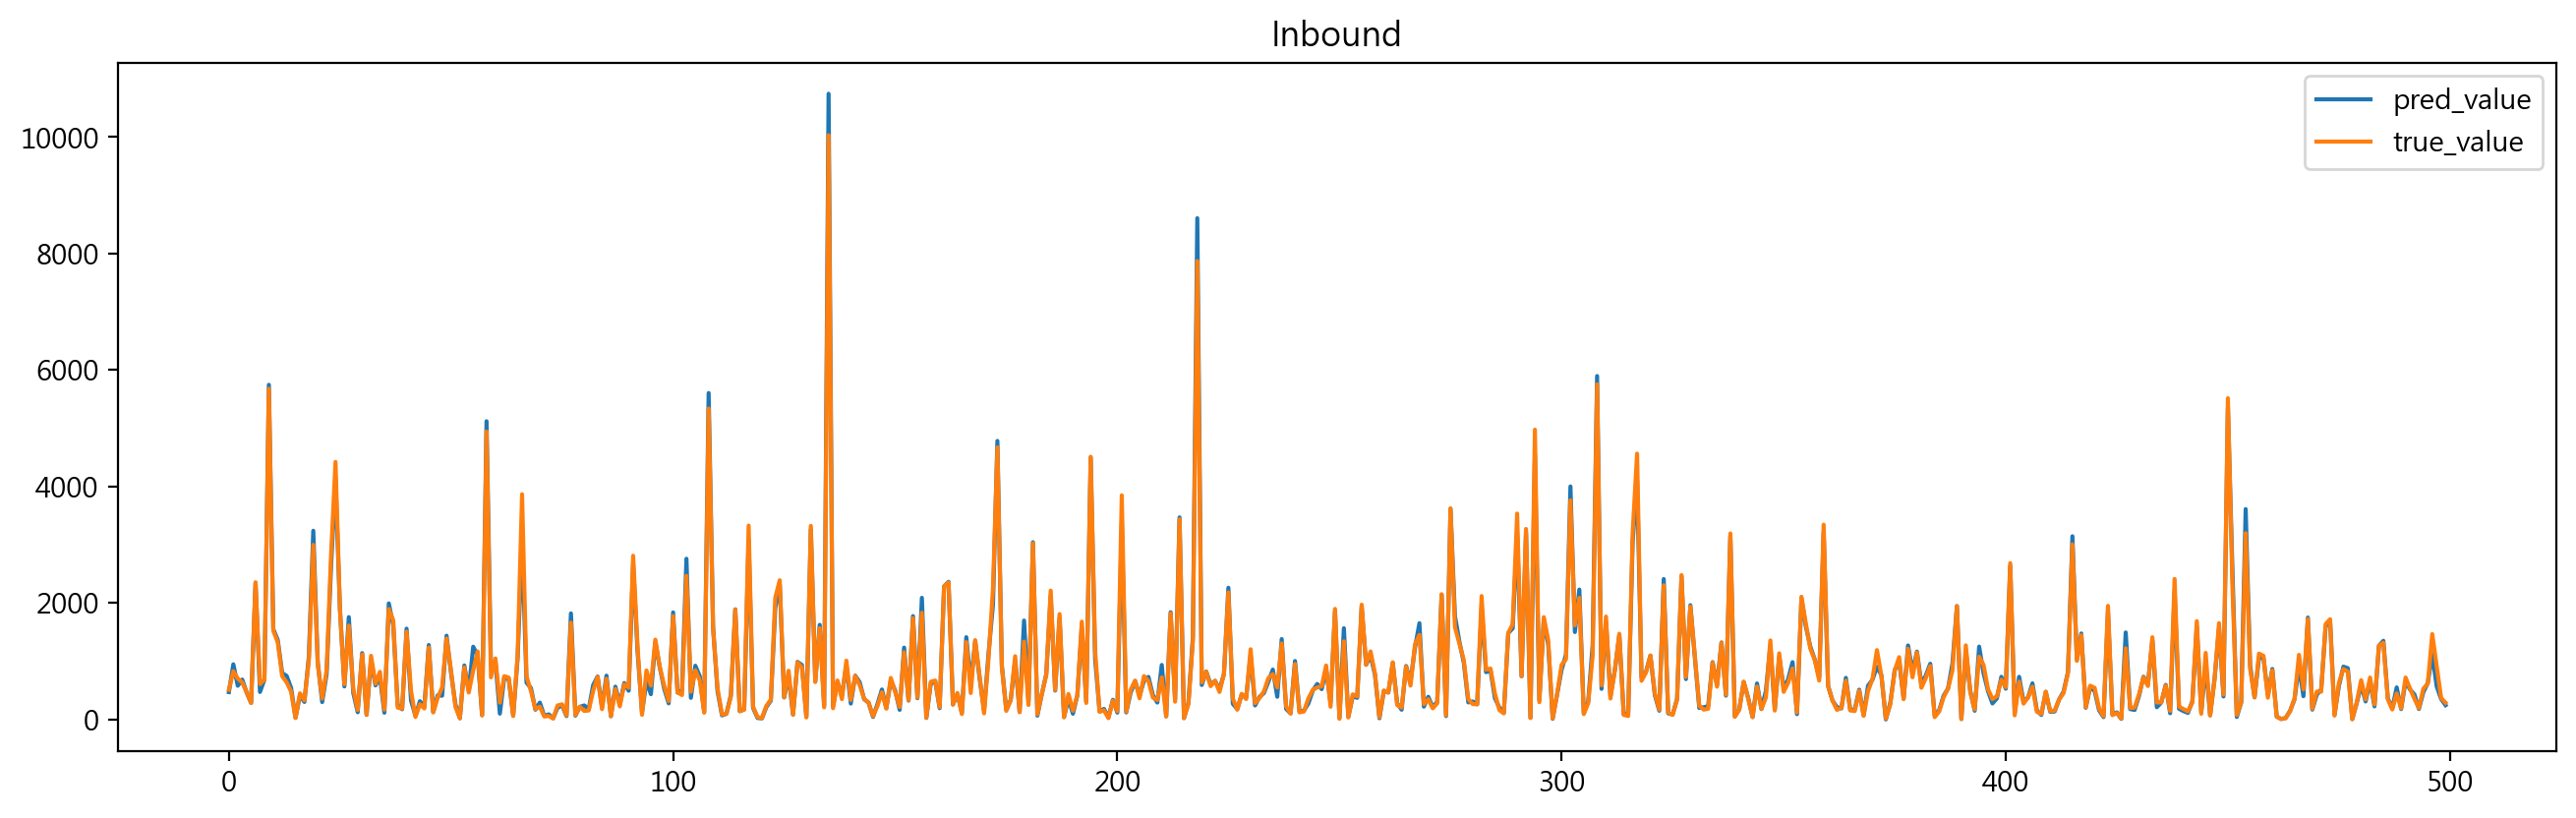

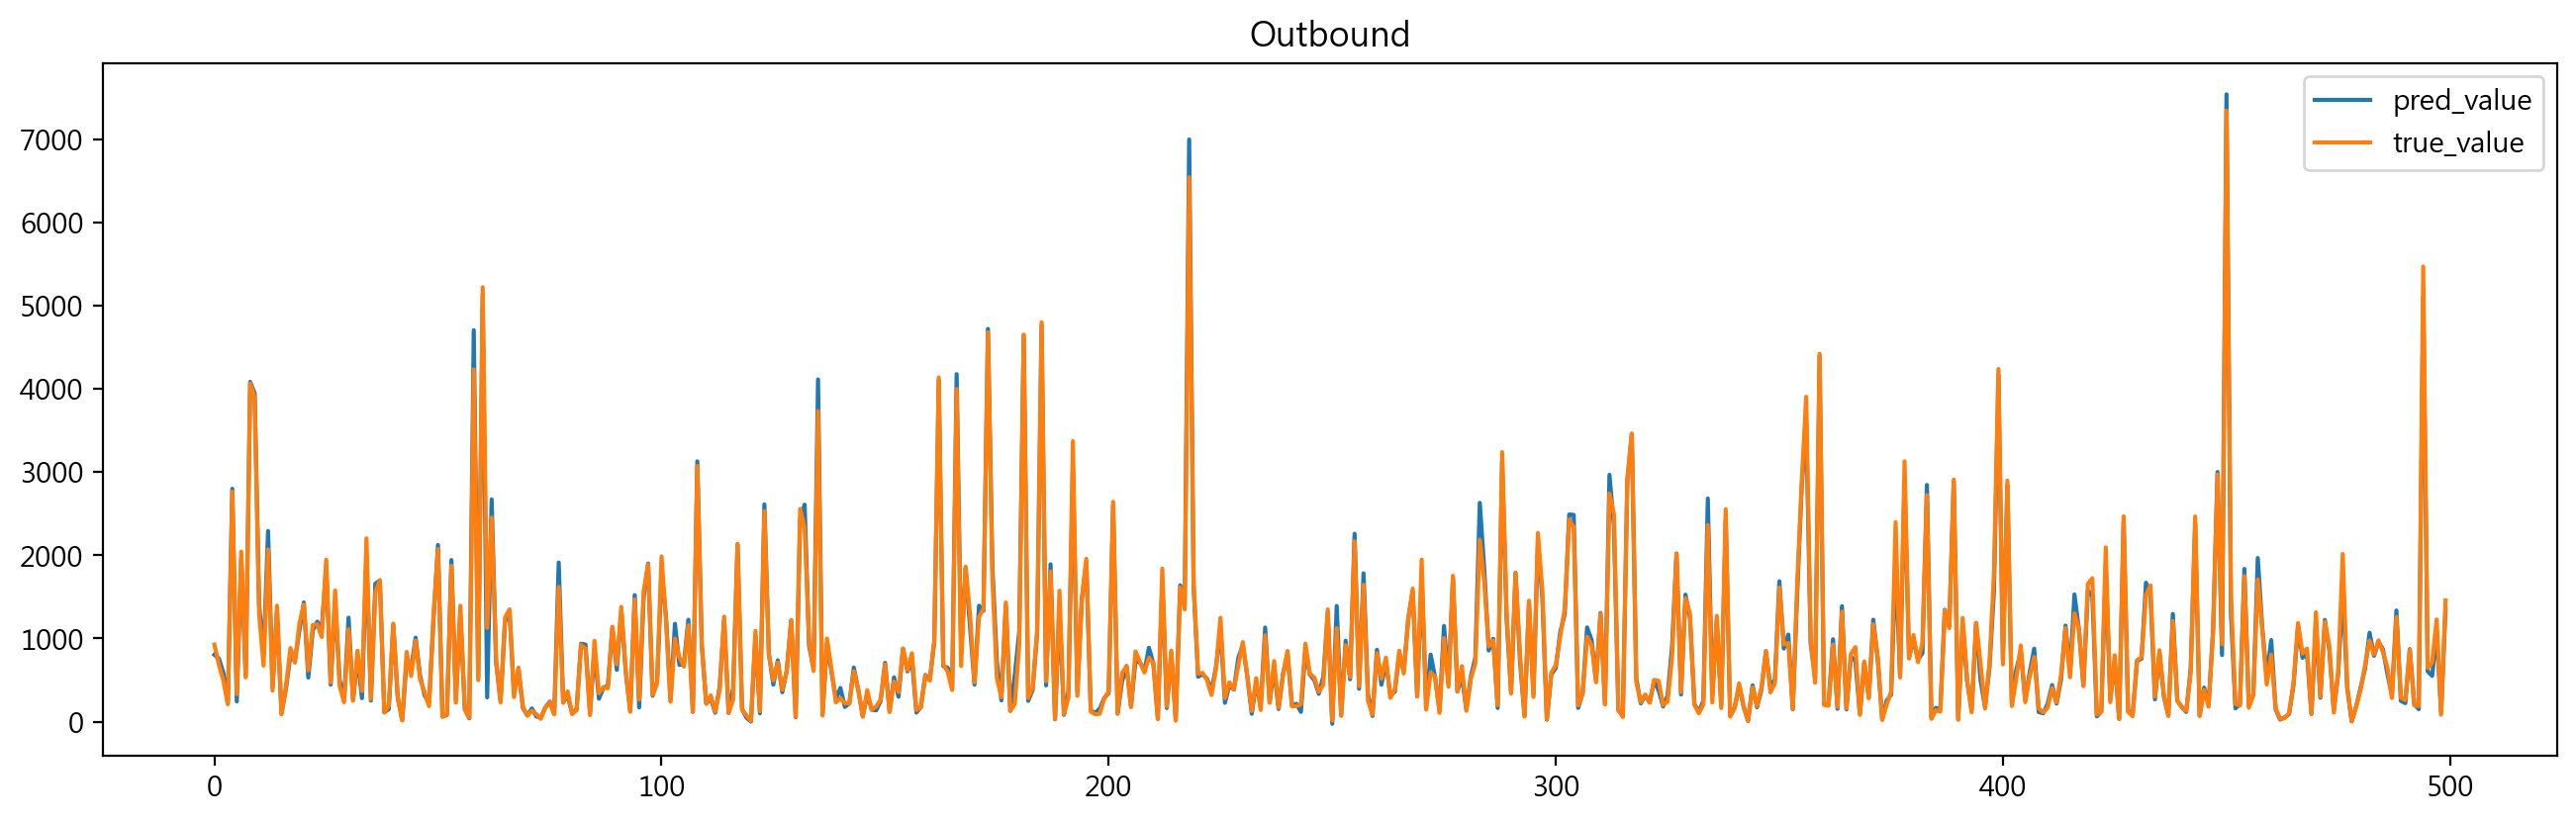

In [26]:
pred = model.predict(test_X)

test_Y = np.array(test_Y)
fig = plt.figure(figsize=(12,4))
check_number = 500

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(pred[:check_number,0], label="pred_value")
plt.plot(test_Y[:check_number,0], label="true_value")
plt.title("Inbound")
plt.legend()

plt.figure(figsize=(16,10))
plt.subplot(212)
plt.plot(pred[:check_number,1], label="pred_value")
plt.plot(test_Y[:check_number,1], label="true_value")
plt.title("Outbound")
plt.legend()

In [27]:
#==========================================================================================================================
# 以 MAPE 做為績效評估指標
# 多數 MAPE < 10%，表示此模型預測能力精準
#==========================================================================================================================
EVAL_Inbound = {"Actual Inbound": list(test_Y[:,0]), "Predict Inbound": list(pred[:,0]), "MAPE": []}
EVAL_Outbound = {"Actual Outbound": list(test_Y[:,1]), "Predict Outbound": list(pred[:,1]), "MAPE": []}
for i in range(test_Y.shape[0]):
    EVAL_Inbound["MAPE"].append(f"{abs((test_Y[i,0]-pred[i,0])/test_Y[i,0]):.2%}")
    EVAL_Outbound["MAPE"].append(f"{abs((test_Y[i,1]-pred[i,1])/test_Y[i,1]):.2%}")
    
EVAL_Inbound = pd.DataFrame(EVAL_Inbound)
EVAL_Outbound = pd.DataFrame(EVAL_Outbound)

D:\Users\63984\AppData\Local\Temp\ipykernel_26188\733800668.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  EVAL_Inbound["MAPE"].append(f"{abs((test_Y[i,0]-pred[i,0])/test_Y[i,0]):.2%}")
D:\Users\63984\AppData\Local\Temp\ipykernel_26188\733800668.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  EVAL_Outbound["MAPE"].append(f"{abs((test_Y[i,1]-pred[i,1])/test_Y[i,1]):.2%}")


In [28]:
# 顯示前 50 筆進站人數預測結果
EVAL_Inbound.head(50)

Actual Inbound  Predict Inbound    MAPE
0              509       468.051697   8.04%
1              827       945.048767  14.27%
2              698       577.347656  17.29%
3              634       683.051147   7.74%
4              464       461.213928   0.60%
5              279       283.428833   1.59%
6             2354      2339.731689   0.61%
7              605       470.677399  22.20%
8              683       682.097473   0.13%
9             5677      5745.816406   1.21%
10            1520      1549.461426   1.94%
11            1323      1363.110107   3.03%
12             740       794.712341   7.39%
13             637       746.813354  17.24%
14             477       540.108643  13.23%
15              23        27.921343  21.40%
16             447       410.344696   8.20%
17             327       298.994598   8.56%
18            1008      1075.974243   6.74%
19            2997      3238.911865   8.07%
20             946       985.341187   4.16%
21             358       296.916077  17.06%
22             848       776.553406   8.43%
23            2824      2623.958496   7.08%
24            4421      4125.727051   6.68%
25            1890      1894.796387   0.25%
26             602       565.438782   6.07%
27            1611      1755.421509   8.96%
28             525       453.974182  13.53%
29             161       121.837753  24.32%
30            1115      1137.769165   2.04%
31              79        77.016556   2.51%
32            1091      1018.822327   6.62%
33             610       582.613159   4.49%
34             816       725.806091  11.05%
35             167       113.824028  31.84%
36            1894      1990.856201   5.11%
37            1701      1614.029297   5.11%
38             201       245.478745  22.13%
39             185       173.137634   6.41%
40            1505      1557.291382   3.47%
41             486       323.738068  33.39%
42              40        61.129303  52.82%
43             260       311.628235  19.86%
44             187       214.723831  14.83%
45            1235      1276.046875   3.32%
46             120       125.745644   4.79%
47             371       411.022980  10.79%
48             548       406.592987  25.80%
49            1389      1436.268555   3.40%

In [29]:
# 顯示前 50 筆出站人數預測結果
EVAL_Outbound.head(50)

Actual Outbound  Predict Outbound    MAPE
0               927        805.121033  13.15%
1               683        758.581116  11.07%
2               492        587.442261  19.40%
3               210        216.084381   2.90%
4              2767       2800.484619   1.21%
5               331        242.694992  26.68%
6              2045       1964.888062   3.92%
7               532        547.071533   2.83%
8              4070       4087.662598   0.43%
9              3900       3948.256836   1.24%
10             1289       1405.490723   9.04%
11              674        807.370911  19.79%
12             2072       2293.631104  10.70%
13              374        422.080200  12.86%
14             1394       1318.028809   5.45%
15               87         98.092339  12.75%
16              423        394.232300   6.80%
17              885        799.937012   9.61%
18              710        732.978027   3.24%
19             1178       1093.582642   7.17%
20             1409       1433.564087   1.74%
21              617        530.456543  14.03%
22             1162       1096.615234   5.63%
23             1172       1202.537598   2.61%
24             1018       1112.598145   9.29%
25             1947       1865.390015   4.19%
26              472        444.994873   5.72%
27             1578       1446.651855   8.32%
28              429        508.767181  18.59%
29              233        260.092712  11.63%
30             1112       1250.614746  12.47%
31              254        255.125076   0.44%
32              853        774.907104   9.16%
33              368        282.068207  23.35%
34             2205       1993.432739   9.59%
35              271        252.624451   6.78%
36             1559       1660.338989   6.50%
37             1702       1697.595703   0.26%
38              109        112.331192   3.06%
39              192        150.786377  21.47%
40             1179       1160.104980   1.60%
41              303        286.114990   5.57%
42               15         18.541639  23.61%
43              839        740.301147  11.76%
44              549        642.851074  17.09%
45              975       1009.620789   3.55%
46              507        551.847412   8.85%
47              358        317.385376  11.34%
48              186        224.167450  20.52%
49             1278       1223.887695   4.23%

### 儲存驗證結果

In [30]:
EVAL_Inbound.to_csv("eval_inbound.csv", index=False)
EVAL_Outbound.to_csv("eval_outbound.csv", index=False)